# use class to encapsulate scraping functions

2021/01/03

In [ ]:
from STEP0_paths_open_save import open_files, save_files
from STEP1_scraping_cleaning_merge import scrape, app_detail_dicts
from STEP2_pre_processing import pre_processing
from STEP3_NLP_pipeline import nlp_pipeline

# 1. Scraping

In [1]:
%run -i 'STEP1_scraping_cleaning_merge.py'
from datetime import datetime

initial_panels = ['201812', '201907', '201908', '201912', '202001', '202002']
today = datetime.today()
current_panel = today.strftime("%Y%m")
print(current_panel)

for i in initial_panels:
    o = open_files(initial_panel=i)
    DF = o.open_df_to_id_for_scraping()
    d1 = scrape(initial_panel=i,
                current_panel=current_panel
                ).open_initial_panel_data(
                ).get_appids_from_initial_panel_data(
                ).scraping_apps_according_to_id()

scraping...: 100%|██████████| 8042/8042 [1:02:58<00:00,  2.13it/s] 


202104
start scraping apps with initial panel 201812
The number of IDs are: 5977
Finished scraping app details with initial panel 201812
Saved scarped app details with initial panel 201812
start scraping apps with initial panel 201907
The number of IDs are: 13144
Finished scraping app details with initial panel 201907
Saved scarped app details with initial panel 201907
start scraping apps with initial panel 201908
The number of IDs are: 13015
Finished scraping app details with initial panel 201908
Saved scarped app details with initial panel 201908
start scraping apps with initial panel 201912
The number of IDs are: 8468
Finished scraping app details with initial panel 201912
Saved scarped app details with initial panel 201912
start scraping apps with initial panel 202001
The number of IDs are: 8359
Finished scraping app details with initial panel 202001
Saved scarped app details with initial panel 202001
start scraping apps with initial panel 202002
The number of IDs are: 8042
Finishe

# Panels Track

In [1]:
panels_track = {
'201812':['201812', '201912', '202001', '202003', '202004', '202009', '202010',
          '202011', '202012', '202101', '202102', '202103', '202104'],
'201907':['201907', '201908', '201909', '201912', '202001', '202003', '202004',
          '202009', '202010', '202011', '202012', '202101', '202102', '202103',
          '202104'],
'201908':['201908', '201912', '202001', '202003', '202004', '202009', '202010',
          '202011', '202012', '202101', '202102', '202103', '202104'],
'201912':['201912', '202001', '202003', '202004', '202009', '202010', '202011',
          '202012', '202101', '202102', '202103', '202104'],
'202001':['202001', '202003', '202004', '202009', '202010', '202011', '202012',
          '202101', '202102', '202103', '202104'],
'202002':['202002', '202004', '202009', '202010', '202011', '202012', '202101',
          '202102', '202103', '202104']}

test_initial_panel = '201907'
test_all_panels = ['201907', '201908', '201909', '201912', '202001', '202003', '202004',
          '202009', '202010', '202011', '202012', '202101', '202102', '202103',
          '202104']

# 2. Convert

In [2]:
%run -i 'STEP1_scraping_cleaning_merge.py'

for initial_panel, all_panels in panels_track.items():
    d1 = convert(initial_panel=initial_panel,
                 all_panels=all_panels
                 ).open_app_detail_dict(
                 ).merge_panels_into_single_df()

panel data 201812 has shape:
(4278, 346)
panel data 201907 has shape:
(10576, 398)
panel data 201908 has shape:
(10537, 346)
panel data 201912 has shape:
(7058, 320)
panel data 202001 has shape:
(7027, 294)
panel data 202002 has shape:
(6860, 268)


# 3. Convert to Developer Index and Geocode Addresses
This only need to be run once

In [ ]:
from tqdm.auto import tqdm
tqdm.pandas()
%run -i 'STEP1_scraping_cleaning_merge.py'
%run -i 'STEP2_pre_processing.py'

# ***************************************************************************************
for initial_panel, all_panels in panels_track.items():
    o = open_files(initial_panel=initial_panel)
    merged_df = o.open_panel_df(name='MERGED')
    new_class_obj = pre_processing(
                     df=merged_df,
                     initial_panel=initial_panel,
                     all_panels=all_panels)
    DF = new_class_obj.lat_and_long_columns(
                    multiindex=False,
                    consecutive=False)
    s = save_files(df=DF, initial_panel=initial_panel)
    s.save_panel_df(name='dev_index_geocoded')
    print('finished converting', initial_panel, 'dataset')
    print()
    print()

# 4. Impute and Delete Missing
Since I will need interval data, so I will only impute from consecutive_panels

I have streamlined code and adjusted containsAds, offersIAP for ALL panels and impute
missing only if all their non-missing panels are the same value.
SAVED in 2021_04_08 / breakthrough_imputed_missing folder.

I will not impute or delete for size variable, since it contains such a large percentage of missing.

In the final regression, I will use a dummy to indicate whether size is missing.
(or simply does not include size).

In [3]:
%run -i 'STEP2_pre_processing.py'

original_vars = ['minInstalls',
                        'score',
                        'reviews',
                        'ratings',
                        'price',
                        'released',
                        'updated',
                        'free',
                        'containsAds',
                        'offersIAP',
                        'contentRating',
                        'genreId']

imputed_vars = ['Imputed' + i for i in original_vars]

# updated value has to strictly follow the previous panel's
# ***************************************************************************************
for initial_panel, all_panels in panels_track.items():
    d1 = pre_processing(
                 initial_panel=initial_panel,
                 all_panels=all_panels,
                 tcn='description'
        ).open_merged_df(
        ).count_missing(
                    var_list=original_vars,
                    name='missing_count_before_imputation'
        ).remove_rows_with_missing_in_all_text_cols(
        ).mode_text_col(
        ).clean_text_col(
        ).check_cleaned_mode_text_col(
        ).create_time_invariant_developer_col(
        ).compare_original_and_imputed_developer(
        ).impute_list_of_vars(
                    list_of_vars=original_vars
        ).count_missing(
                    var_list=imputed_vars,
                    name='missing_count_after_imputation'
        ).compare_original_and_imputed_var(
                    var_list=original_vars
        ).find_rows_to_remove_after_imputation(
            var_list=imputed_vars
        ).drop_rows(
        ).count_missing(
            var_list=imputed_vars,
            name='missing_count_after_deletion')

201812  :  missing_count_before_imputation
                      count missing
minInstalls_201812               15
minInstalls_201912               15
minInstalls_202001               15
minInstalls_202003               15
minInstalls_202004               15
minInstalls_202009               16
minInstalls_202010               62
minInstalls_202011              112
minInstalls_202012              190
minInstalls_202101              225
minInstalls_202102              266
minInstalls_202103              313
minInstalls_202104              349
score_201812                     12
score_201912                     12
score_202001                     12
score_202003                     12
score_202004                     12
score_202009                     26
score_202010                     72
score_202011                    122
score_202012                    200
score_202101                    235
score_202102                    276
score_202103                    323
score_202104         

# 5. Divide into Sub samples

In [3]:
%run -i 'STEP3_sub_samples.py'

for initial_panel, all_panels in panels_track.items():
    d1 = divide(
            initial_panel=initial_panel,
            all_panels=all_panels
            ).open_imputed_and_deleted_missing_df(
            ).create_star_developer_var(
            ).create_subsample_var_dict(
            ).count_apps_in_each_category(
            ).create_division_rules(
            ).check_subsamples()

/home/naixin/Insync/naixin88@sina.cn/OneDrive/__CODING__/PycharmProjects/GOOGLE_PLAY/scripts/STEP3_sub_samples.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)
100%|██████████| 4/4 [00:03<00:00,  1.29it/s]
/home/naixin/anaconda3/envs/GOOGLE_PLAY/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/naixin/anaconda3/envs/GOOGLE_PLAY/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydat

201812  : top digital firms.
top_digital_firms
0    3741
1    149 
dtype: int64
201812  count number of apps in each group (potential sub-samples) 
201812  finished creating division rules for sub samples and saved dataframe. 
201812  count number of apps in each sub samples
201812  :  minInstalls
201812  :  ImputedminInstalls_tier1
ImputedminInstalls_tier1
0    3229
1    661 
dtype: int64
201812  :  ImputedminInstalls_tier2
ImputedminInstalls_tier2
0    2365
1    1525
dtype: int64
201812  :  ImputedminInstalls_tier3
ImputedminInstalls_tier3
0    2186
1    1704
dtype: int64
201812  :  genreId
201812  :  VIDEO_PLAYERS
VIDEO_PLAYERS
0    3825
1    65  
dtype: int64
201812  :  ENTERTAINMENT
ENTERTAINMENT
0    3711
1    179 
dtype: int64
201812  :  GAME_BOARD
GAME_BOARD
0    3855
1    35  
dtype: int64
201812  :  EVENTS
EVENTS
0    3862
1    28  
dtype: int64
201812  :  PRODUCTIVITY
PRODUCTIVITY
0    3718
1    172 
dtype: int64
201812  :  BOOKS_AND_REFERENCE
BOOKS_AND_REFERENCE
0    3802
1

100%|██████████| 4/4 [00:08<00:00,  2.10s/it]
/home/naixin/anaconda3/envs/GOOGLE_PLAY/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/naixin/anaconda3/envs/GOOGLE_PLAY/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/naixin/anaconda3/envs/GOOGLE_PLAY/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See 

201907  : top digital firms.
top_digital_firms
0    8957
1    448 
dtype: int64
201907  count number of apps in each group (potential sub-samples) 
201907  finished creating division rules for sub samples and saved dataframe. 
201907  count number of apps in each sub samples
201907  :  minInstalls
201907  :  ImputedminInstalls_tier1
ImputedminInstalls_tier1
0    7605
1    1800
dtype: int64
201907  :  ImputedminInstalls_tier2
ImputedminInstalls_tier2
0    5174
1    4231
dtype: int64
201907  :  ImputedminInstalls_tier3
ImputedminInstalls_tier3
0    6031
1    3374
dtype: int64
201907  :  genreId
201907  :  ART_AND_DESIGN
ART_AND_DESIGN
0    9238
1    167 
dtype: int64
201907  :  COMICS
COMICS
0    9322
1    83  
dtype: int64
201907  :  PERSONALIZATION
PERSONALIZATION
0    9131
1    274 
dtype: int64
201907  :  PHOTOGRAPHY
PHOTOGRAPHY
0    9197
1    208 
dtype: int64
201907  :  AUTO_AND_VEHICLES
AUTO_AND_VEHICLES
0    9234
1    171 
dtype: int64
201907  :  GAME_ROLE_PLAYING
GAME_ROLE_PLAYI

100%|██████████| 4/4 [00:08<00:00,  2.05s/it]
/home/naixin/anaconda3/envs/GOOGLE_PLAY/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/naixin/anaconda3/envs/GOOGLE_PLAY/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/naixin/anaconda3/envs/GOOGLE_PLAY/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See 

201908  : top digital firms.
top_digital_firms
0    8900
1    469 
dtype: int64
201908  count number of apps in each group (potential sub-samples) 
201908  finished creating division rules for sub samples and saved dataframe. 
201908  count number of apps in each sub samples
201908  :  minInstalls
201908  :  ImputedminInstalls_tier1
ImputedminInstalls_tier1
0    7602
1    1767
dtype: int64
201908  :  ImputedminInstalls_tier2
ImputedminInstalls_tier2
0    5118
1    4251
dtype: int64
201908  :  ImputedminInstalls_tier3
ImputedminInstalls_tier3
0    6018
1    3351
dtype: int64
201908  :  genreId
201908  :  ART_AND_DESIGN
ART_AND_DESIGN
0    9206
1    163 
dtype: int64
201908  :  COMICS
COMICS
0    9295
1    74  
dtype: int64
201908  :  PHOTOGRAPHY
PHOTOGRAPHY
0    9159
1    210 
dtype: int64
201908  :  PERSONALIZATION
PERSONALIZATION
0    9107
1    262 
dtype: int64
201908  :  BUSINESS
BUSINESS
0    9121
1    248 
dtype: int64
201908  :  AUTO_AND_VEHICLES
AUTO_AND_VEHICLES
0    9212
1    

100%|██████████| 4/4 [00:03<00:00,  1.02it/s]
/home/naixin/anaconda3/envs/GOOGLE_PLAY/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/naixin/anaconda3/envs/GOOGLE_PLAY/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/naixin/anaconda3/envs/GOOGLE_PLAY/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See 

201912  : top digital firms.
top_digital_firms
0    5690
1    474 
dtype: int64
201912  count number of apps in each group (potential sub-samples) 
201912  finished creating division rules for sub samples and saved dataframe. 
201912  count number of apps in each sub samples
201912  :  minInstalls
201912  :  ImputedminInstalls_tier1
ImputedminInstalls_tier1
0    4168
1    1996
dtype: int64
201912  :  ImputedminInstalls_tier2
ImputedminInstalls_tier2
0    2819
1    3345
dtype: int64
201912  :  ImputedminInstalls_tier3
ImputedminInstalls_tier3
0    5341
1    823 
dtype: int64
201912  :  genreId
201912  :  EDUCATION
EDUCATION
0    5946
1    218 
dtype: int64
201912  :  GAME_ROLE_PLAYING
GAME_ROLE_PLAYING
0    5893
1    271 
dtype: int64
201912  :  GAME_STRATEGY
GAME_STRATEGY
0    5980
1    184 
dtype: int64
201912  :  GAME_SIMULATION
GAME_SIMULATION
0    5923
1    241 
dtype: int64
201912  :  GAME_ACTION
GAME_ACTION
0    5913
1    251 
dtype: int64
201912  :  BOOKS_AND_REFERENCE
BOOKS_AND

100%|██████████| 4/4 [00:03<00:00,  1.12it/s]
/home/naixin/anaconda3/envs/GOOGLE_PLAY/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/naixin/anaconda3/envs/GOOGLE_PLAY/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/naixin/anaconda3/envs/GOOGLE_PLAY/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See 

202001  : top digital firms.
top_digital_firms
0    5713
1    438 
dtype: int64
202001  count number of apps in each group (potential sub-samples) 
202001  finished creating division rules for sub samples and saved dataframe. 
202001  count number of apps in each sub samples
202001  :  minInstalls
202001  :  ImputedminInstalls_tier1
ImputedminInstalls_tier1
0    4035
1    2116
dtype: int64
202001  :  ImputedminInstalls_tier2
ImputedminInstalls_tier2
0    2762
1    3389
dtype: int64
202001  :  ImputedminInstalls_tier3
ImputedminInstalls_tier3
0    5505
1    646 
dtype: int64
202001  :  genreId
202001  :  PERSONALIZATION
PERSONALIZATION
0    6017
1    134 
dtype: int64
202001  :  GAME_ACTION
GAME_ACTION
0    5880
1    271 
dtype: int64
202001  :  GAME_SPORTS
GAME_SPORTS
0    6006
1    145 
dtype: int64
202001  :  MUSIC_AND_AUDIO
MUSIC_AND_AUDIO
0    6011
1    140 
dtype: int64
202001  :  GAME_EDUCATIONAL
GAME_EDUCATIONAL
0    5949
1    202 
dtype: int64
202001  :  MEDICAL
MEDICAL
0    58

100%|██████████| 4/4 [00:03<00:00,  1.09it/s]
/home/naixin/anaconda3/envs/GOOGLE_PLAY/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/naixin/anaconda3/envs/GOOGLE_PLAY/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/naixin/anaconda3/envs/GOOGLE_PLAY/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See 

202002  : top digital firms.
top_digital_firms
0    5525
1    452 
dtype: int64
202002  count number of apps in each group (potential sub-samples) 
202002  finished creating division rules for sub samples and saved dataframe. 
202002  count number of apps in each sub samples
202002  :  minInstalls
202002  :  ImputedminInstalls_tier1
ImputedminInstalls_tier1
0    3906
1    2071
dtype: int64
202002  :  ImputedminInstalls_tier2
ImputedminInstalls_tier2
0    2731
1    3246
dtype: int64
202002  :  ImputedminInstalls_tier3
ImputedminInstalls_tier3
0    5317
1    660 
dtype: int64
202002  :  genreId
202002  :  COMMUNICATION
COMMUNICATION
0    5874
1    103 
dtype: int64
202002  :  GAME_CASUAL
GAME_CASUAL
0    5739
1    238 
dtype: int64
202002  :  GAME_PUZZLE
GAME_PUZZLE
0    5674
1    303 
dtype: int64
202002  :  MUSIC_AND_AUDIO
MUSIC_AND_AUDIO
0    5839
1    138 
dtype: int64
202002  :  GAME_EDUCATIONAL
GAME_EDUCATIONAL
0    5758
1    219 
dtype: int64
202002  :  GAME_ADVENTURE
GAME_ADVENTU

# 6. NLP Pipeline

## 6.1 Find Optimal SVD Components

TF-IDF TRANSFORMATION
201907  --  full  --  full
(9405, 2000)
TF-IDF TRANSFORMATION
201907  --  minInstalls  --  ImputedminInstalls_tier1
(1800, 2000)
TF-IDF TRANSFORMATION
201907  --  minInstalls  --  ImputedminInstalls_tier2
(4231, 2000)
TF-IDF TRANSFORMATION
201907  --  minInstalls  --  ImputedminInstalls_tier3
(3374, 2000)
TF-IDF TRANSFORMATION
201907  --  genreId  --  ART_AND_DESIGN
(167, 2000)
TF-IDF TRANSFORMATION
201907  --  genreId  --  COMICS
(83, 2000)
TF-IDF TRANSFORMATION
201907  --  genreId  --  PERSONALIZATION
(274, 2000)
TF-IDF TRANSFORMATION
201907  --  genreId  --  PHOTOGRAPHY
(208, 2000)
TF-IDF TRANSFORMATION
201907  --  genreId  --  AUTO_AND_VEHICLES
(171, 2000)
TF-IDF TRANSFORMATION
201907  --  genreId  --  GAME_ROLE_PLAYING
(262, 2000)
TF-IDF TRANSFORMATION
201907  --  genreId  --  GAME_ACTION
(22, 1736)
TF-IDF TRANSFORMATION
201907  --  genreId  --  GAME_RACING
(188, 2000)
TF-IDF TRANSFORMATION
201907  --  genreId  --  TRAVEL_AND_LOCAL
(214, 2000)
TF-IDF TRANSFOR

  0%|          | 0/20 [00:00<?, ?it/s]

(8957, 2000)
FIND OPTIMAL SVD COMPONENTS
201907  --  full  --  full


  5%|▌         | 1/20 [00:00<00:13,  1.46it/s]

Number of components = 0 and explained variance = 0.0


 10%|█         | 2/20 [00:01<00:10,  1.71it/s]

Number of components = 105 and explained variance = 0.3017319212024319


 15%|█▌        | 3/20 [00:01<00:11,  1.51it/s]

Number of components = 210 and explained variance = 0.42513426300425594


 20%|██        | 4/20 [00:02<00:12,  1.32it/s]

Number of components = 316 and explained variance = 0.5157693972034298


 25%|██▌       | 5/20 [00:04<00:13,  1.09it/s]

Number of components = 421 and explained variance = 0.5879881108795021


 30%|███       | 6/20 [00:05<00:15,  1.10s/it]

Number of components = 526 and explained variance = 0.6484834301354063


 35%|███▌      | 7/20 [00:07<00:17,  1.36s/it]

Number of components = 631 and explained variance = 0.7005745420408611


 40%|████      | 8/20 [00:09<00:19,  1.59s/it]

Number of components = 736 and explained variance = 0.7458350874051576


 45%|████▌     | 9/20 [00:11<00:19,  1.78s/it]

Number of components = 842 and explained variance = 0.7859002836056206


 50%|█████     | 10/20 [00:14<00:22,  2.21s/it]

Number of components = 947 and explained variance = 0.8208506684253394


 55%|█████▌    | 11/20 [00:18<00:22,  2.50s/it]

Number of components = 1052 and explained variance = 0.8516060115849299


 60%|██████    | 12/20 [00:21<00:22,  2.82s/it]

Number of components = 1157 and explained variance = 0.8787779237075422


 65%|██████▌   | 13/20 [00:25<00:22,  3.15s/it]

Number of components = 1263 and explained variance = 0.9028724465822737


 70%|███████   | 14/20 [00:29<00:21,  3.50s/it]

Number of components = 1368 and explained variance = 0.923872857017096


 75%|███████▌  | 15/20 [00:34<00:19,  3.89s/it]

Number of components = 1473 and explained variance = 0.9421485638031075


 80%|████████  | 16/20 [00:39<00:16,  4.14s/it]

Number of components = 1578 and explained variance = 0.9580226319044416


 85%|████████▌ | 17/20 [00:44<00:13,  4.59s/it]

Number of components = 1683 and explained variance = 0.971678905016764


 90%|█████████ | 18/20 [00:50<00:09,  4.87s/it]

Number of components = 1789 and explained variance = 0.9833347128118153


 95%|█████████▌| 19/20 [00:56<00:05,  5.32s/it]

Number of components = 1894 and explained variance = 0.9928473470214092


100%|██████████| 20/20 [01:02<00:00,  3.14s/it]

Number of components = 1999 and explained variance = 0.9999904263396929


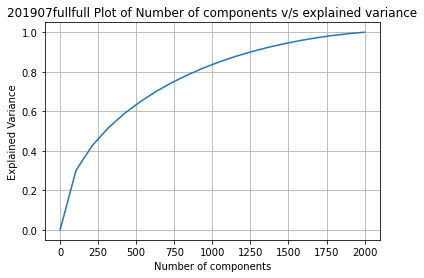

  0%|          | 0/20 [00:00<?, ?it/s]

FIND OPTIMAL SVD COMPONENTS
201907  --  minInstalls  --  ImputedminInstalls_tier1


 10%|█         | 2/20 [00:00<00:01, 11.53it/s]

Number of components = 0 and explained variance = 0.0
Number of components = 105 and explained variance = 0.37977159719625264
Number of components = 210 and explained variance = 0.5401693122214484


 20%|██        | 4/20 [00:00<00:02,  6.29it/s]

Number of components = 316 and explained variance = 0.6535683749012893


 25%|██▌       | 5/20 [00:00<00:03,  4.94it/s]

Number of components = 421 and explained variance = 0.738061878901528


 30%|███       | 6/20 [00:01<00:03,  3.86it/s]

Number of components = 526 and explained variance = 0.8035897322607141


 35%|███▌      | 7/20 [00:01<00:04,  3.02it/s]

Number of components = 631 and explained variance = 0.8547240677132515


 40%|████      | 8/20 [00:02<00:05,  2.28it/s]

Number of components = 736 and explained variance = 0.8945178476585078


 45%|████▌     | 9/20 [00:03<00:05,  2.01it/s]

Number of components = 842 and explained variance = 0.9253770469897391


 50%|█████     | 10/20 [00:03<00:05,  1.75it/s]

Number of components = 947 and explained variance = 0.9484983631341628


 55%|█████▌    | 11/20 [00:04<00:05,  1.54it/s]

Number of components = 1052 and explained variance = 0.965750050863446


 60%|██████    | 12/20 [00:05<00:05,  1.35it/s]

Number of components = 1157 and explained variance = 0.9782769565037097


 65%|██████▌   | 13/20 [00:06<00:05,  1.17it/s]

Number of components = 1263 and explained variance = 0.9871322925437553


 70%|███████   | 14/20 [00:07<00:05,  1.04it/s]

Number of components = 1368 and explained variance = 0.9929926098326665


 75%|███████▌  | 15/20 [00:09<00:05,  1.08s/it]

Number of components = 1473 and explained variance = 0.996662248521502


 80%|████████  | 16/20 [00:10<00:04,  1.18s/it]

Number of components = 1578 and explained variance = 0.9987271243895569


 85%|████████▌ | 17/20 [00:12<00:03,  1.29s/it]

Number of components = 1683 and explained variance = 0.999700027531891


 90%|█████████ | 18/20 [00:14<00:02,  1.44s/it]

Number of components = 1789 and explained variance = 0.9999963912641909


 95%|█████████▌| 19/20 [00:15<00:01,  1.48s/it]

Number of components = 1894 and explained variance = 0.9999999999999982


100%|██████████| 20/20 [00:17<00:00,  1.15it/s]

Number of components = 1999 and explained variance = 0.9999999999999982


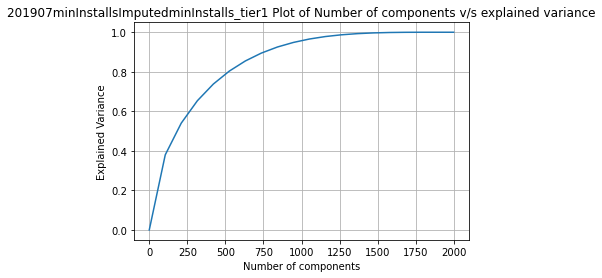

  0%|          | 0/20 [00:00<?, ?it/s]

FIND OPTIMAL SVD COMPONENTS
201907  --  minInstalls  --  ImputedminInstalls_tier2


  5%|▌         | 1/20 [00:00<00:03,  5.36it/s]

Number of components = 0 and explained variance = 0.0


 10%|█         | 2/20 [00:00<00:03,  4.87it/s]

Number of components = 105 and explained variance = 0.3375353430657038


 15%|█▌        | 3/20 [00:00<00:04,  3.88it/s]

Number of components = 210 and explained variance = 0.4720801594651501


 20%|██        | 4/20 [00:01<00:05,  3.01it/s]

Number of components = 316 and explained variance = 0.5696279636530714


 25%|██▌       | 5/20 [00:01<00:06,  2.33it/s]

Number of components = 421 and explained variance = 0.6458956593853502


 30%|███       | 6/20 [00:02<00:07,  1.88it/s]

Number of components = 526 and explained variance = 0.7087293505866883


 35%|███▌      | 7/20 [00:03<00:08,  1.49it/s]

Number of components = 631 and explained variance = 0.7609402398442766


 40%|████      | 8/20 [00:04<00:09,  1.27it/s]

Number of components = 736 and explained variance = 0.8050387983088646


 45%|████▌     | 9/20 [00:05<00:09,  1.10it/s]

Number of components = 842 and explained variance = 0.8425494475662885


 50%|█████     | 10/20 [00:07<00:10,  1.06s/it]

Number of components = 947 and explained variance = 0.8739227724776978


 55%|█████▌    | 11/20 [00:08<00:11,  1.26s/it]

Number of components = 1052 and explained variance = 0.9002836685695891


 60%|██████    | 12/20 [00:10<00:12,  1.51s/it]

Number of components = 1157 and explained variance = 0.922476675448285


 65%|██████▌   | 13/20 [00:12<00:11,  1.69s/it]

Number of components = 1263 and explained variance = 0.9410874457924703


 70%|███████   | 14/20 [00:15<00:10,  1.80s/it]

Number of components = 1368 and explained variance = 0.9563601797025324


 75%|███████▌  | 15/20 [00:17<00:09,  1.96s/it]

Number of components = 1473 and explained variance = 0.9688194503280404


 80%|████████  | 16/20 [00:19<00:08,  2.06s/it]

Number of components = 1578 and explained variance = 0.9788679957955893


 85%|████████▌ | 17/20 [00:22<00:06,  2.22s/it]

Number of components = 1683 and explained variance = 0.9867629700513187


 90%|█████████ | 18/20 [00:25<00:05,  2.57s/it]

Number of components = 1789 and explained variance = 0.9928431183526721


 95%|█████████▌| 19/20 [00:28<00:02,  2.76s/it]

Number of components = 1894 and explained variance = 0.9972182077454038


100%|██████████| 20/20 [00:31<00:00,  1.59s/it]

Number of components = 1999 and explained variance = 0.9999927338851003


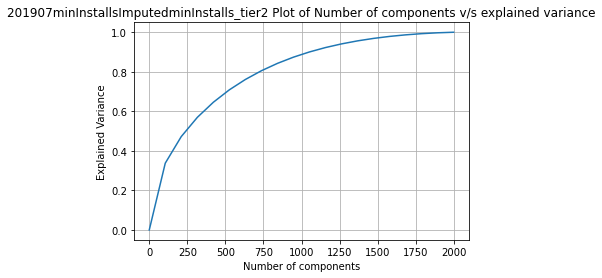

  0%|          | 0/20 [00:00<?, ?it/s]

FIND OPTIMAL SVD COMPONENTS
201907  --  minInstalls  --  ImputedminInstalls_tier3


  5%|▌         | 1/20 [00:00<00:02,  7.28it/s]

Number of components = 0 and explained variance = 0.0


 10%|█         | 2/20 [00:00<00:03,  5.72it/s]

Number of components = 105 and explained variance = 0.3145302600670701


 15%|█▌        | 3/20 [00:00<00:03,  5.07it/s]

Number of components = 210 and explained variance = 0.4511683658259559


 20%|██        | 4/20 [00:00<00:04,  3.89it/s]

Number of components = 316 and explained variance = 0.5541938990371479


 25%|██▌       | 5/20 [00:01<00:05,  2.98it/s]

Number of components = 421 and explained variance = 0.6361307346848658


 30%|███       | 6/20 [00:01<00:05,  2.35it/s]

Number of components = 526 and explained variance = 0.703429517550495


 35%|███▌      | 7/20 [00:02<00:06,  1.91it/s]

Number of components = 631 and explained variance = 0.7596693238631202


 40%|████      | 8/20 [00:03<00:07,  1.63it/s]

Number of components = 736 and explained variance = 0.8067497229129154


 45%|████▌     | 9/20 [00:04<00:08,  1.37it/s]

Number of components = 842 and explained variance = 0.8466124742975991


 50%|█████     | 10/20 [00:05<00:08,  1.16it/s]

Number of components = 947 and explained variance = 0.8794373200418741


 55%|█████▌    | 11/20 [00:07<00:09,  1.04s/it]

Number of components = 1052 and explained variance = 0.9068287685378158


 60%|██████    | 12/20 [00:08<00:09,  1.16s/it]

Number of components = 1157 and explained variance = 0.9293660494715763


 65%|██████▌   | 13/20 [00:10<00:09,  1.35s/it]

Number of components = 1263 and explained variance = 0.9478769238494793


 70%|███████   | 14/20 [00:12<00:09,  1.65s/it]

Number of components = 1368 and explained variance = 0.9626291631735503


 75%|███████▌  | 15/20 [00:14<00:09,  1.83s/it]

Number of components = 1473 and explained variance = 0.9743095361851639


 80%|████████  | 16/20 [00:16<00:07,  1.87s/it]

Number of components = 1578 and explained variance = 0.9833192864988286


 85%|████████▌ | 17/20 [00:19<00:05,  1.96s/it]

Number of components = 1683 and explained variance = 0.9900896327513209


 90%|█████████ | 18/20 [00:21<00:04,  2.21s/it]

Number of components = 1789 and explained variance = 0.9949744914494109


 95%|█████████▌| 19/20 [00:24<00:02,  2.34s/it]

Number of components = 1894 and explained variance = 0.9981995492940255


100%|██████████| 20/20 [00:27<00:00,  1.38s/it]

Number of components = 1999 and explained variance = 0.9999948399882088


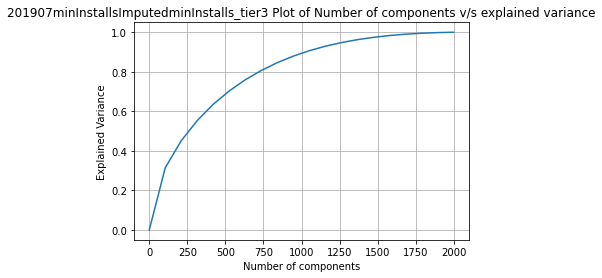

 15%|█▌        | 3/20 [00:00<00:00, 29.32it/s]

FIND OPTIMAL SVD COMPONENTS
201907  --  genreId  --  ART_AND_DESIGN
Number of components = 0 and explained variance = 0.0
Number of components = 105 and explained variance = 0.845608545888866
Number of components = 210 and explained variance = 0.9999999999999998
Number of components = 316 and explained variance = 1.0


 30%|███       | 6/20 [00:00<00:00, 21.93it/s]

Number of components = 421 and explained variance = 1.0
Number of components = 526 and explained variance = 0.9999999999999998
Number of components = 631 and explained variance = 0.9999999999999998
Number of components = 736 and explained variance = 1.0000000000000004


 55%|█████▌    | 11/20 [00:00<00:00, 16.41it/s]

Number of components = 842 and explained variance = 1.0
Number of components = 947 and explained variance = 0.9999999999999999
Number of components = 1052 and explained variance = 1.0


 65%|██████▌   | 13/20 [00:00<00:00, 14.43it/s]

Number of components = 1157 and explained variance = 1.0
Number of components = 1263 and explained variance = 1.0
Number of components = 1368 and explained variance = 1.0


 85%|████████▌ | 17/20 [00:01<00:00, 12.05it/s]

Number of components = 1473 and explained variance = 1.0
Number of components = 1578 and explained variance = 1.0000000000000002
Number of components = 1683 and explained variance = 1.0000000000000002


 95%|█████████▌| 19/20 [00:01<00:00, 11.20it/s]

Number of components = 1789 and explained variance = 1.0000000000000002
Number of components = 1894 and explained variance = 1.0000000000000002


100%|██████████| 20/20 [00:01<00:00, 13.31it/s]


Number of components = 1999 and explained variance = 1.0000000000000002


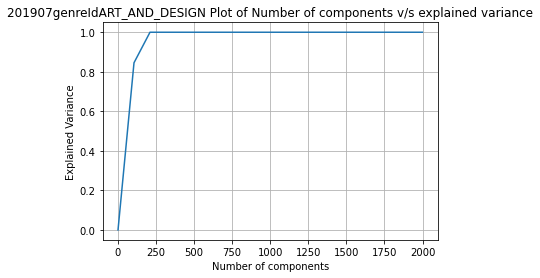

  0%|          | 0/20 [00:00<?, ?it/s]

FIND OPTIMAL SVD COMPONENTS
201907  --  genreId  --  COMICS
Number of components = 0 and explained variance = 0.0


 25%|██▌       | 5/20 [00:00<00:00, 44.06it/s]

Number of components = 105 and explained variance = 1.0000000000000009
Number of components = 210 and explained variance = 1.0000000000000004
Number of components = 316 and explained variance = 1.0000000000000009
Number of components = 421 and explained variance = 1.0000000000000004
Number of components = 526 and explained variance = 1.0000000000000004
Number of components = 631 and explained variance = 1.0000000000000004
Number of components = 736 and explained variance = 0.9999999999999999


 50%|█████     | 10/20 [00:00<00:00, 29.63it/s]

Number of components = 842 and explained variance = 1.0000000000000004
Number of components = 947 and explained variance = 1.0000000000000013
Number of components = 1052 and explained variance = 1.0000000000000009
Number of components = 1157 and explained variance = 1.0


 70%|███████   | 14/20 [00:00<00:00, 22.71it/s]

Number of components = 1263 and explained variance = 1.0000000000000007
Number of components = 1368 and explained variance = 1.0000000000000002
Number of components = 1473 and explained variance = 1.0000000000000009


 85%|████████▌ | 17/20 [00:00<00:00, 19.01it/s]

Number of components = 1578 and explained variance = 1.0000000000000007
Number of components = 1683 and explained variance = 1.0000000000000002
Number of components = 1789 and explained variance = 1.0000000000000007


100%|██████████| 20/20 [00:01<00:00, 19.66it/s]

Number of components = 1894 and explained variance = 1.0
Number of components = 1999 and explained variance = 1.0000000000000007


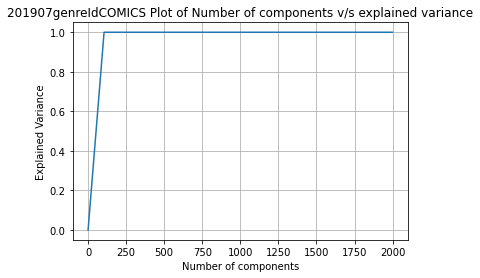

 15%|█▌        | 3/20 [00:00<00:00, 24.77it/s]

FIND OPTIMAL SVD COMPONENTS
201907  --  genreId  --  PERSONALIZATION
Number of components = 0 and explained variance = 0.0
Number of components = 105 and explained variance = 0.760270660863736
Number of components = 210 and explained variance = 0.9703891329319972


 30%|███       | 6/20 [00:00<00:00, 14.50it/s]

Number of components = 316 and explained variance = 1.0000000000000002
Number of components = 421 and explained variance = 0.9999999999999996
Number of components = 526 and explained variance = 1.0


 40%|████      | 8/20 [00:00<00:00, 12.50it/s]

Number of components = 631 and explained variance = 0.9999999999999997
Number of components = 736 and explained variance = 1.0
Number of components = 842 and explained variance = 1.0


 50%|█████     | 10/20 [00:00<00:00, 11.18it/s]

Number of components = 947 and explained variance = 1.0
Number of components = 1052 and explained variance = 1.0


 60%|██████    | 12/20 [00:01<00:00, 10.14it/s]

Number of components = 1157 and explained variance = 0.9999999999999998
Number of components = 1263 and explained variance = 0.9999999999999996


 75%|███████▌  | 15/20 [00:01<00:00,  8.70it/s]

Number of components = 1368 and explained variance = 1.0
Number of components = 1473 and explained variance = 1.0


 85%|████████▌ | 17/20 [00:01<00:00,  7.96it/s]

Number of components = 1578 and explained variance = 1.0000000000000004
Number of components = 1683 and explained variance = 1.0000000000000002


 95%|█████████▌| 19/20 [00:02<00:00,  7.37it/s]

Number of components = 1789 and explained variance = 0.9999999999999998
Number of components = 1894 and explained variance = 1.0000000000000002


100%|██████████| 20/20 [00:02<00:00,  9.14it/s]


Number of components = 1999 and explained variance = 1.0


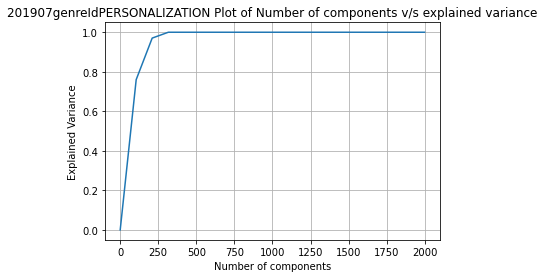

 15%|█▌        | 3/20 [00:00<00:00, 24.27it/s]

FIND OPTIMAL SVD COMPONENTS
201907  --  genreId  --  PHOTOGRAPHY
Number of components = 0 and explained variance = 0.0
Number of components = 105 and explained variance = 0.7505290097543988
Number of components = 210 and explained variance = 0.9999999999999999
Number of components = 316 and explained variance = 0.9999999999999997


 30%|███       | 6/20 [00:00<00:00, 16.33it/s]

Number of components = 421 and explained variance = 0.9999999999999998
Number of components = 526 and explained variance = 0.9999999999999999
Number of components = 631 and explained variance = 1.0


 50%|█████     | 10/20 [00:00<00:00, 12.70it/s]

Number of components = 736 and explained variance = 0.9999999999999998
Number of components = 842 and explained variance = 0.9999999999999997
Number of components = 947 and explained variance = 0.9999999999999999


 60%|██████    | 12/20 [00:00<00:00, 11.42it/s]

Number of components = 1052 and explained variance = 1.0
Number of components = 1157 and explained variance = 0.9999999999999997


 70%|███████   | 14/20 [00:01<00:00, 10.65it/s]

Number of components = 1263 and explained variance = 1.0
Number of components = 1368 and explained variance = 1.0000000000000002


 80%|████████  | 16/20 [00:01<00:00, 10.08it/s]

Number of components = 1473 and explained variance = 0.9999999999999998
Number of components = 1578 and explained variance = 0.9999999999999999


 90%|█████████ | 18/20 [00:01<00:00,  9.80it/s]

Number of components = 1683 and explained variance = 0.9999999999999997
Number of components = 1789 and explained variance = 1.0


100%|██████████| 20/20 [00:01<00:00, 10.93it/s]

Number of components = 1894 and explained variance = 1.0000000000000002
Number of components = 1999 and explained variance = 0.9999999999999999


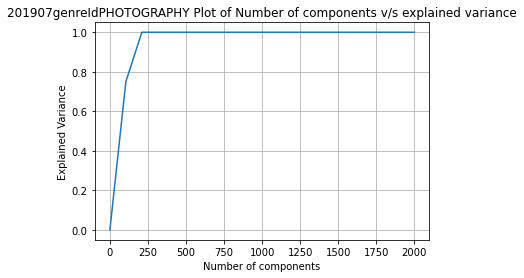

 20%|██        | 4/20 [00:00<00:00, 27.83it/s]

FIND OPTIMAL SVD COMPONENTS
201907  --  genreId  --  AUTO_AND_VEHICLES
Number of components = 0 and explained variance = 0.0
Number of components = 105 and explained variance = 0.8183293261737521
Number of components = 210 and explained variance = 0.9999999999999998
Number of components = 316 and explained variance = 0.9999999999999998
Number of components = 421 and explained variance = 0.9999999999999998


 35%|███▌      | 7/20 [00:00<00:00, 21.27it/s]

Number of components = 526 and explained variance = 1.0
Number of components = 631 and explained variance = 1.0000000000000002
Number of components = 736 and explained variance = 1.0
Number of components = 842 and explained variance = 0.9999999999999997


 60%|██████    | 12/20 [00:00<00:00, 15.30it/s]

Number of components = 947 and explained variance = 0.9999999999999998
Number of components = 1052 and explained variance = 0.9999999999999996
Number of components = 1157 and explained variance = 1.0


 70%|███████   | 14/20 [00:00<00:00, 13.83it/s]

Number of components = 1263 and explained variance = 1.0
Number of components = 1368 and explained variance = 0.9999999999999998
Number of components = 1473 and explained variance = 1.0


 90%|█████████ | 18/20 [00:01<00:00, 11.91it/s]

Number of components = 1578 and explained variance = 1.0
Number of components = 1683 and explained variance = 1.0
Number of components = 1789 and explained variance = 0.9999999999999998


100%|██████████| 20/20 [00:01<00:00, 13.54it/s]

Number of components = 1894 and explained variance = 1.0
Number of components = 1999 and explained variance = 0.9999999999999998


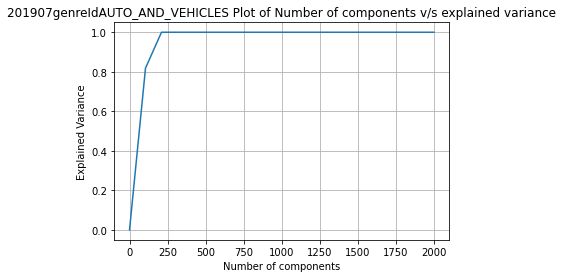

 15%|█▌        | 3/20 [00:00<00:00, 28.86it/s]

FIND OPTIMAL SVD COMPONENTS
201907  --  genreId  --  GAME_ROLE_PLAYING
Number of components = 0 and explained variance = 0.0
Number of components = 105 and explained variance = 0.6321317238099655
Number of components = 210 and explained variance = 0.9307364658399475
Number of components = 316 and explained variance = 1.0


 30%|███       | 6/20 [00:00<00:00, 16.76it/s]

Number of components = 421 and explained variance = 1.0000000000000002
Number of components = 526 and explained variance = 1.0000000000000002
Number of components = 631 and explained variance = 1.0


 50%|█████     | 10/20 [00:00<00:00, 12.72it/s]

Number of components = 736 and explained variance = 1.0000000000000002
Number of components = 842 and explained variance = 0.9999999999999999
Number of components = 947 and explained variance = 0.9999999999999999


 60%|██████    | 12/20 [00:00<00:00, 11.35it/s]

Number of components = 1052 and explained variance = 1.0
Number of components = 1157 and explained variance = 1.0


 70%|███████   | 14/20 [00:01<00:00, 10.24it/s]

Number of components = 1263 and explained variance = 1.0000000000000002
Number of components = 1368 and explained variance = 0.9999999999999999


 80%|████████  | 16/20 [00:01<00:00,  9.39it/s]

Number of components = 1473 and explained variance = 1.0000000000000004
Number of components = 1578 and explained variance = 1.0


 90%|█████████ | 18/20 [00:01<00:00,  8.62it/s]

Number of components = 1683 and explained variance = 1.0
Number of components = 1789 and explained variance = 1.0000000000000002


100%|██████████| 20/20 [00:01<00:00, 10.16it/s]

Number of components = 1894 and explained variance = 1.0
Number of components = 1999 and explained variance = 1.0000000000000002


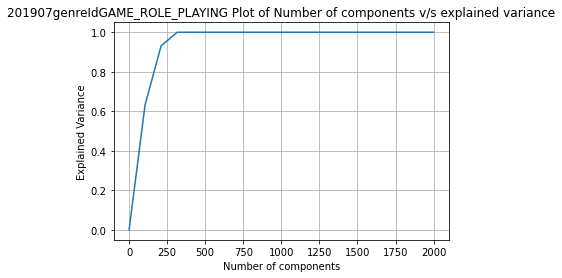

 35%|███▌      | 7/20 [00:00<00:00, 66.42it/s]

FIND OPTIMAL SVD COMPONENTS
201907  --  genreId  --  GAME_ACTION
Number of components = 0 and explained variance = 0.0
Number of components = 91 and explained variance = 1.0
Number of components = 183 and explained variance = 0.9999999999999998
Number of components = 274 and explained variance = 0.9999999999999994
Number of components = 365 and explained variance = 0.9999999999999994
Number of components = 457 and explained variance = 0.9999999999999999
Number of components = 548 and explained variance = 1.0000000000000002
Number of components = 639 and explained variance = 1.0
Number of components = 731 and explained variance = 1.000000000000001
Number of components = 822 and explained variance = 1.0000000000000002


 70%|███████   | 14/20 [00:00<00:00, 38.73it/s]

Number of components = 913 and explained variance = 0.9999999999999993
Number of components = 1004 and explained variance = 1.0000000000000007
Number of components = 1096 and explained variance = 1.0
Number of components = 1187 and explained variance = 0.9999999999999999
Number of components = 1278 and explained variance = 0.9999999999999991
Number of components = 1370 and explained variance = 0.9999999999999992


100%|██████████| 20/20 [00:00<00:00, 31.57it/s]

Number of components = 1461 and explained variance = 1.0000000000000002
Number of components = 1552 and explained variance = 1.0000000000000004
Number of components = 1644 and explained variance = 0.9999999999999983
Number of components = 1735 and explained variance = 1.0


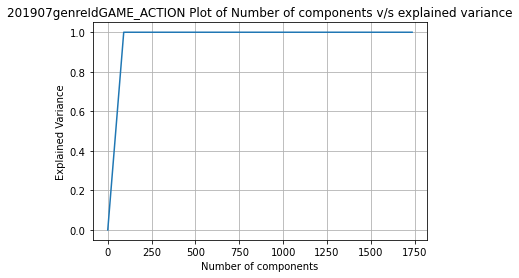

 15%|█▌        | 3/20 [00:00<00:00, 29.54it/s]

FIND OPTIMAL SVD COMPONENTS
201907  --  genreId  --  GAME_RACING
Number of components = 0 and explained variance = 0.0
Number of components = 105 and explained variance = 0.7618571884807842
Number of components = 210 and explained variance = 1.0
Number of components = 316 and explained variance = 1.0


 30%|███       | 6/20 [00:00<00:00, 21.80it/s]

Number of components = 421 and explained variance = 1.0
Number of components = 526 and explained variance = 1.0
Number of components = 631 and explained variance = 1.0000000000000002
Number of components = 736 and explained variance = 1.0


 55%|█████▌    | 11/20 [00:00<00:00, 16.10it/s]

Number of components = 842 and explained variance = 0.9999999999999998
Number of components = 947 and explained variance = 0.9999999999999998
Number of components = 1052 and explained variance = 1.0


 65%|██████▌   | 13/20 [00:00<00:00, 14.37it/s]

Number of components = 1157 and explained variance = 0.9999999999999999
Number of components = 1263 and explained variance = 0.9999999999999994
Number of components = 1368 and explained variance = 1.0000000000000002


 75%|███████▌  | 15/20 [00:00<00:00, 12.83it/s]

Number of components = 1473 and explained variance = 1.0000000000000002
Number of components = 1578 and explained variance = 1.0


 85%|████████▌ | 17/20 [00:01<00:00, 11.48it/s]

Number of components = 1683 and explained variance = 1.0
Number of components = 1789 and explained variance = 1.0


100%|██████████| 20/20 [00:01<00:00, 12.76it/s]

Number of components = 1894 and explained variance = 0.9999999999999998
Number of components = 1999 and explained variance = 0.9999999999999999


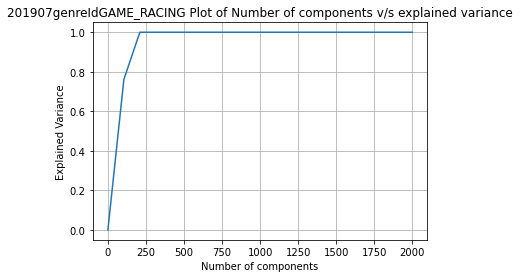

 15%|█▌        | 3/20 [00:00<00:00, 28.14it/s]

FIND OPTIMAL SVD COMPONENTS
201907  --  genreId  --  TRAVEL_AND_LOCAL
Number of components = 0 and explained variance = 0.0
Number of components = 105 and explained variance = 0.7350283279889072
Number of components = 210 and explained variance = 0.9996076690990674
Number of components = 316 and explained variance = 0.9999999999999998


 30%|███       | 6/20 [00:00<00:00, 19.83it/s]

Number of components = 421 and explained variance = 1.0000000000000007
Number of components = 526 and explained variance = 1.0000000000000002
Number of components = 631 and explained variance = 0.9999999999999999


 45%|████▌     | 9/20 [00:00<00:00, 16.29it/s]

Number of components = 736 and explained variance = 0.9999999999999999
Number of components = 842 and explained variance = 0.9999999999999999
Number of components = 947 and explained variance = 1.0


 65%|██████▌   | 13/20 [00:00<00:00, 12.86it/s]

Number of components = 1052 and explained variance = 1.0
Number of components = 1157 and explained variance = 1.0000000000000002
Number of components = 1263 and explained variance = 1.0


 75%|███████▌  | 15/20 [00:01<00:00, 11.22it/s]

Number of components = 1368 and explained variance = 1.0
Number of components = 1473 and explained variance = 1.0000000000000004


 85%|████████▌ | 17/20 [00:01<00:00, 10.45it/s]

Number of components = 1578 and explained variance = 1.0
Number of components = 1683 and explained variance = 1.0


 95%|█████████▌| 19/20 [00:01<00:00,  9.81it/s]

Number of components = 1789 and explained variance = 1.0
Number of components = 1894 and explained variance = 1.0000000000000002


100%|██████████| 20/20 [00:01<00:00, 11.76it/s]


Number of components = 1999 and explained variance = 1.0000000000000002


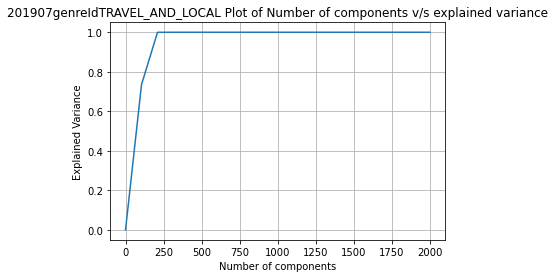

 15%|█▌        | 3/20 [00:00<00:00, 22.72it/s]

FIND OPTIMAL SVD COMPONENTS
201907  --  genreId  --  GAME_ADVENTURE
Number of components = 0 and explained variance = 0.0
Number of components = 105 and explained variance = 0.7108458567614786
Number of components = 210 and explained variance = 0.9979999210140879


 30%|███       | 6/20 [00:00<00:00, 17.41it/s]

Number of components = 316 and explained variance = 0.9999999999999996
Number of components = 421 and explained variance = 0.9999999999999997
Number of components = 526 and explained variance = 0.9999999999999999


 40%|████      | 8/20 [00:00<00:00, 15.72it/s]

Number of components = 631 and explained variance = 0.9999999999999998
Number of components = 736 and explained variance = 1.0
Number of components = 842 and explained variance = 0.9999999999999999


 60%|██████    | 12/20 [00:00<00:00, 12.80it/s]

Number of components = 947 and explained variance = 0.9999999999999998
Number of components = 1052 and explained variance = 0.9999999999999998
Number of components = 1157 and explained variance = 0.9999999999999996


 70%|███████   | 14/20 [00:01<00:00, 11.60it/s]

Number of components = 1263 and explained variance = 0.9999999999999998
Number of components = 1368 and explained variance = 0.9999999999999999


 80%|████████  | 16/20 [00:01<00:00, 10.68it/s]

Number of components = 1473 and explained variance = 0.9999999999999996
Number of components = 1578 and explained variance = 0.9999999999999998


 90%|█████████ | 18/20 [00:01<00:00,  9.92it/s]

Number of components = 1683 and explained variance = 0.9999999999999996
Number of components = 1789 and explained variance = 0.9999999999999997


100%|██████████| 20/20 [00:01<00:00, 11.42it/s]

Number of components = 1894 and explained variance = 0.9999999999999998
Number of components = 1999 and explained variance = 0.9999999999999998


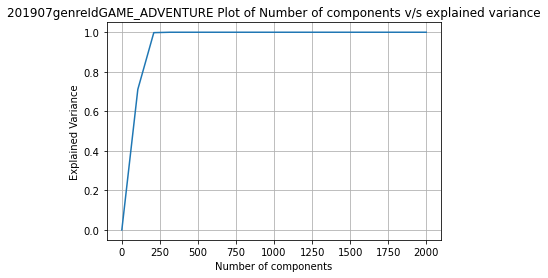

 20%|██        | 4/20 [00:00<00:00, 33.70it/s]

FIND OPTIMAL SVD COMPONENTS
201907  --  genreId  --  SOCIAL
Number of components = 0 and explained variance = 0.0
Number of components = 105 and explained variance = 0.8646075893401638
Number of components = 210 and explained variance = 1.0000000000000004
Number of components = 316 and explained variance = 1.0
Number of components = 421 and explained variance = 1.0


 40%|████      | 8/20 [00:00<00:00, 23.50it/s]

Number of components = 526 and explained variance = 0.9999999999999998
Number of components = 631 and explained variance = 1.0
Number of components = 736 and explained variance = 0.9999999999999999
Number of components = 842 and explained variance = 1.0000000000000002


 55%|█████▌    | 11/20 [00:00<00:00, 20.31it/s]

Number of components = 947 and explained variance = 1.0000000000000002
Number of components = 1052 and explained variance = 1.0000000000000004
Number of components = 1157 and explained variance = 1.0


 70%|███████   | 14/20 [00:00<00:00, 17.22it/s]

Number of components = 1263 and explained variance = 1.0000000000000002
Number of components = 1368 and explained variance = 1.0000000000000002
Number of components = 1473 and explained variance = 1.0


 90%|█████████ | 18/20 [00:01<00:00, 13.86it/s]

Number of components = 1578 and explained variance = 1.0
Number of components = 1683 and explained variance = 1.0
Number of components = 1789 and explained variance = 1.0


100%|██████████| 20/20 [00:01<00:00, 15.65it/s]


Number of components = 1894 and explained variance = 1.0
Number of components = 1999 and explained variance = 1.0


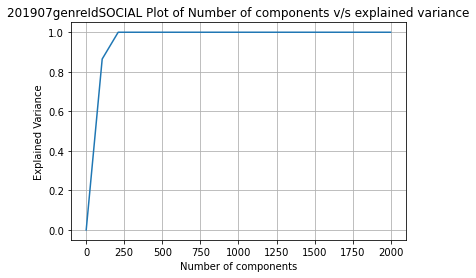

 15%|█▌        | 3/20 [00:00<00:00, 26.19it/s]

FIND OPTIMAL SVD COMPONENTS
201907  --  genreId  --  GAME_SIMULATION
Number of components = 0 and explained variance = 0.0
Number of components = 105 and explained variance = 0.662159211562257
Number of components = 210 and explained variance = 0.9479675268781238
Number of components = 316 and explained variance = 1.0


 30%|███       | 6/20 [00:00<00:00, 16.61it/s]

Number of components = 421 and explained variance = 1.0000000000000004
Number of components = 526 and explained variance = 1.0000000000000004
Number of components = 631 and explained variance = 1.0000000000000004


 50%|█████     | 10/20 [00:00<00:00, 12.57it/s]

Number of components = 736 and explained variance = 1.0000000000000004
Number of components = 842 and explained variance = 1.0000000000000004
Number of components = 947 and explained variance = 1.0000000000000004


 60%|██████    | 12/20 [00:00<00:00, 11.43it/s]

Number of components = 1052 and explained variance = 1.0
Number of components = 1157 and explained variance = 1.0


 70%|███████   | 14/20 [00:01<00:00, 10.18it/s]

Number of components = 1263 and explained variance = 1.0000000000000002
Number of components = 1368 and explained variance = 1.0000000000000004


 80%|████████  | 16/20 [00:01<00:00,  9.43it/s]

Number of components = 1473 and explained variance = 1.0000000000000004
Number of components = 1578 and explained variance = 1.0000000000000004


 90%|█████████ | 18/20 [00:01<00:00,  8.66it/s]

Number of components = 1683 and explained variance = 1.0000000000000002
Number of components = 1789 and explained variance = 1.0000000000000004


100%|██████████| 20/20 [00:01<00:00, 10.22it/s]

Number of components = 1894 and explained variance = 1.0000000000000004
Number of components = 1999 and explained variance = 1.0000000000000004


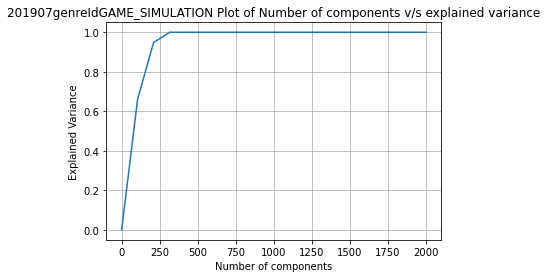

 15%|█▌        | 3/20 [00:00<00:00, 29.55it/s]

FIND OPTIMAL SVD COMPONENTS
201907  --  genreId  --  LIFESTYLE
Number of components = 0 and explained variance = 0.0
Number of components = 105 and explained variance = 0.6831143101535327
Number of components = 210 and explained variance = 0.9995904491080199
Number of components = 316 and explained variance = 1.0


 30%|███       | 6/20 [00:00<00:00, 19.46it/s]

Number of components = 421 and explained variance = 0.9999999999999998
Number of components = 526 and explained variance = 0.9999999999999998
Number of components = 631 and explained variance = 1.0


 45%|████▌     | 9/20 [00:00<00:00, 15.00it/s]

Number of components = 736 and explained variance = 1.0
Number of components = 842 and explained variance = 1.0000000000000002
Number of components = 947 and explained variance = 1.0


 65%|██████▌   | 13/20 [00:00<00:00, 12.48it/s]

Number of components = 1052 and explained variance = 0.9999999999999999
Number of components = 1157 and explained variance = 0.9999999999999997
Number of components = 1263 and explained variance = 0.9999999999999998


 75%|███████▌  | 15/20 [00:01<00:00, 11.42it/s]

Number of components = 1368 and explained variance = 1.0
Number of components = 1473 and explained variance = 1.0


 85%|████████▌ | 17/20 [00:01<00:00, 10.16it/s]

Number of components = 1578 and explained variance = 1.0000000000000002
Number of components = 1683 and explained variance = 1.0


 95%|█████████▌| 19/20 [00:01<00:00,  9.79it/s]

Number of components = 1789 and explained variance = 0.9999999999999998
Number of components = 1894 and explained variance = 1.0


100%|██████████| 20/20 [00:01<00:00, 11.62it/s]


Number of components = 1999 and explained variance = 1.0


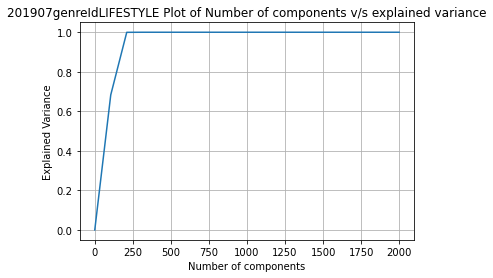

  0%|          | 0/20 [00:00<?, ?it/s]

FIND OPTIMAL SVD COMPONENTS
201907  --  genreId  --  EDUCATION


 15%|█▌        | 3/20 [00:00<00:00, 24.10it/s]

Number of components = 0 and explained variance = 0.0
Number of components = 105 and explained variance = 0.6711565946490785
Number of components = 210 and explained variance = 0.9357988901701779
Number of components = 316 and explained variance = 1.0


 30%|███       | 6/20 [00:00<00:00, 15.26it/s]

Number of components = 421 and explained variance = 0.9999999999999998
Number of components = 526 and explained variance = 1.0
Number of components = 631 and explained variance = 0.9999999999999999


 40%|████      | 8/20 [00:00<00:00, 12.16it/s]

Number of components = 736 and explained variance = 0.9999999999999999
Number of components = 842 and explained variance = 0.9999999999999998


 50%|█████     | 10/20 [00:00<00:00, 10.57it/s]

Number of components = 947 and explained variance = 0.9999999999999999
Number of components = 1052 and explained variance = 0.9999999999999999


 60%|██████    | 12/20 [00:01<00:00,  9.82it/s]

Number of components = 1157 and explained variance = 0.9999999999999999
Number of components = 1263 and explained variance = 0.9999999999999999


 70%|███████   | 14/20 [00:01<00:00,  9.15it/s]

Number of components = 1368 and explained variance = 1.0


 75%|███████▌  | 15/20 [00:01<00:00,  8.78it/s]

Number of components = 1473 and explained variance = 1.0


 80%|████████  | 16/20 [00:01<00:00,  8.56it/s]

Number of components = 1578 and explained variance = 1.0000000000000002


 85%|████████▌ | 17/20 [00:01<00:00,  8.19it/s]

Number of components = 1683 and explained variance = 0.9999999999999999


 90%|█████████ | 18/20 [00:01<00:00,  7.78it/s]

Number of components = 1789 and explained variance = 0.9999999999999998


 95%|█████████▌| 19/20 [00:02<00:00,  7.61it/s]

Number of components = 1894 and explained variance = 1.0


100%|██████████| 20/20 [00:02<00:00,  9.24it/s]

Number of components = 1999 and explained variance = 0.9999999999999997


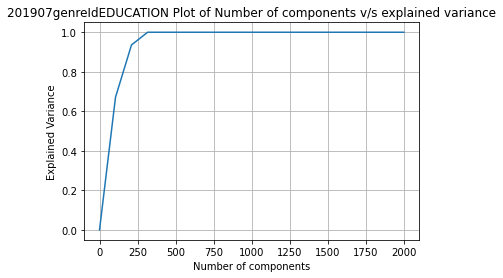

  0%|          | 0/20 [00:00<?, ?it/s]

FIND OPTIMAL SVD COMPONENTS
201907  --  genreId  --  BEAUTY
Number of components = 0 and explained variance = 0.0


 25%|██▌       | 5/20 [00:00<00:00, 44.28it/s]

Number of components = 105 and explained variance = 1.0000000000000002
Number of components = 210 and explained variance = 0.9999999999999997
Number of components = 316 and explained variance = 1.0
Number of components = 421 and explained variance = 0.9999999999999999
Number of components = 526 and explained variance = 1.0000000000000002
Number of components = 631 and explained variance = 1.0000000000000002
Number of components = 736 and explained variance = 1.0000000000000002


 50%|█████     | 10/20 [00:00<00:00, 29.93it/s]

Number of components = 842 and explained variance = 0.9999999999999999
Number of components = 947 and explained variance = 0.9999999999999996
Number of components = 1052 and explained variance = 0.9999999999999999
Number of components = 1157 and explained variance = 0.9999999999999999


 70%|███████   | 14/20 [00:00<00:00, 22.84it/s]

Number of components = 1263 and explained variance = 0.9999999999999996
Number of components = 1368 and explained variance = 1.0000000000000007
Number of components = 1473 and explained variance = 1.0000000000000009


 85%|████████▌ | 17/20 [00:00<00:00, 19.27it/s]

Number of components = 1578 and explained variance = 0.9999999999999998
Number of components = 1683 and explained variance = 0.9999999999999999
Number of components = 1789 and explained variance = 1.0000000000000004


100%|██████████| 20/20 [00:01<00:00, 19.67it/s]

Number of components = 1894 and explained variance = 0.9999999999999996
Number of components = 1999 and explained variance = 0.9999999999999998


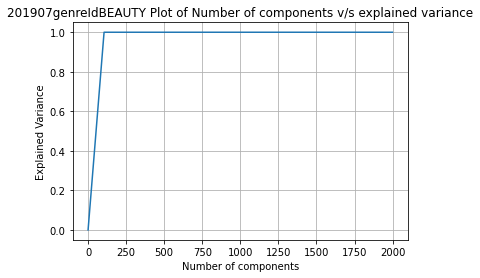

 15%|█▌        | 3/20 [00:00<00:00, 26.48it/s]

FIND OPTIMAL SVD COMPONENTS
201907  --  genreId  --  GAME_CASUAL
Number of components = 0 and explained variance = 0.0
Number of components = 105 and explained variance = 0.6774035492541713
Number of components = 210 and explained variance = 0.9675011762815843
Number of components = 316 and explained variance = 1.0000000000000002


 30%|███       | 6/20 [00:00<00:00, 16.43it/s]

Number of components = 421 and explained variance = 1.0000000000000002
Number of components = 526 and explained variance = 1.0
Number of components = 631 and explained variance = 1.0


 50%|█████     | 10/20 [00:00<00:00, 12.46it/s]

Number of components = 736 and explained variance = 1.0000000000000002
Number of components = 842 and explained variance = 1.0
Number of components = 947 and explained variance = 1.0


 60%|██████    | 12/20 [00:00<00:00, 11.49it/s]

Number of components = 1052 and explained variance = 1.0000000000000002
Number of components = 1157 and explained variance = 1.0000000000000002


 70%|███████   | 14/20 [00:01<00:00, 10.27it/s]

Number of components = 1263 and explained variance = 1.0
Number of components = 1368 and explained variance = 1.0000000000000004


 80%|████████  | 16/20 [00:01<00:00,  9.55it/s]

Number of components = 1473 and explained variance = 1.0
Number of components = 1578 and explained variance = 0.9999999999999999


 90%|█████████ | 18/20 [00:01<00:00,  8.72it/s]

Number of components = 1683 and explained variance = 1.0000000000000002
Number of components = 1789 and explained variance = 1.0


100%|██████████| 20/20 [00:01<00:00, 10.22it/s]

Number of components = 1894 and explained variance = 1.0000000000000002
Number of components = 1999 and explained variance = 1.0000000000000002


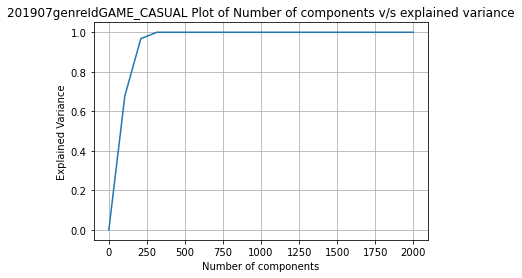

 15%|█▌        | 3/20 [00:00<00:00, 28.13it/s]

FIND OPTIMAL SVD COMPONENTS
201907  --  genreId  --  BOOKS_AND_REFERENCE
Number of components = 0 and explained variance = 0.0
Number of components = 105 and explained variance = 0.7643179257213961
Number of components = 210 and explained variance = 1.0000000000000002
Number of components = 316 and explained variance = 1.0


 30%|███       | 6/20 [00:00<00:00, 17.77it/s]

Number of components = 421 and explained variance = 1.0
Number of components = 526 and explained variance = 1.0
Number of components = 631 and explained variance = 1.0


 50%|█████     | 10/20 [00:00<00:00, 14.32it/s]

Number of components = 736 and explained variance = 0.9999999999999999
Number of components = 842 and explained variance = 0.9999999999999997
Number of components = 947 and explained variance = 0.9999999999999998


 60%|██████    | 12/20 [00:00<00:00, 12.68it/s]

Number of components = 1052 and explained variance = 0.9999999999999998
Number of components = 1157 and explained variance = 0.9999999999999999
Number of components = 1263 and explained variance = 0.9999999999999999


 70%|███████   | 14/20 [00:01<00:00, 11.62it/s]

Number of components = 1368 and explained variance = 1.0
Number of components = 1473 and explained variance = 0.9999999999999997


 80%|████████  | 16/20 [00:01<00:00, 10.78it/s]

Number of components = 1578 and explained variance = 0.9999999999999998
Number of components = 1683 and explained variance = 0.9999999999999997


 90%|█████████ | 18/20 [00:01<00:00, 10.02it/s]

Number of components = 1789 and explained variance = 1.0
Number of components = 1894 and explained variance = 0.9999999999999997


100%|██████████| 20/20 [00:01<00:00, 11.55it/s]

Number of components = 1999 and explained variance = 1.0


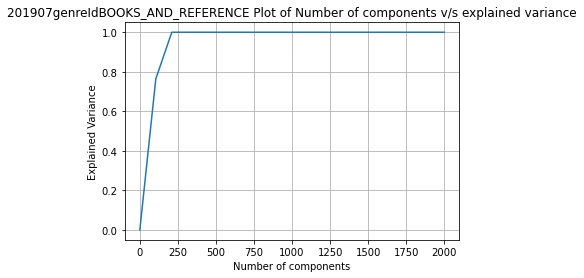

  0%|          | 0/20 [00:00<?, ?it/s]

FIND OPTIMAL SVD COMPONENTS
201907  --  genreId  --  BUSINESS


 15%|█▌        | 3/20 [00:00<00:00, 27.11it/s]

Number of components = 0 and explained variance = 0.0
Number of components = 105 and explained variance = 0.6629162712759937
Number of components = 210 and explained variance = 0.9563771148185902
Number of components = 316 and explained variance = 1.0000000000000004


 30%|███       | 6/20 [00:00<00:00, 16.74it/s]

Number of components = 421 and explained variance = 1.0000000000000004
Number of components = 526 and explained variance = 1.0000000000000002
Number of components = 631 and explained variance = 1.0000000000000004


 50%|█████     | 10/20 [00:00<00:00, 12.85it/s]

Number of components = 736 and explained variance = 1.0
Number of components = 842 and explained variance = 1.0000000000000002
Number of components = 947 and explained variance = 1.0000000000000004


 60%|██████    | 12/20 [00:00<00:00, 11.60it/s]

Number of components = 1052 and explained variance = 1.0000000000000002
Number of components = 1157 and explained variance = 1.0000000000000004


 70%|███████   | 14/20 [00:01<00:00, 10.35it/s]

Number of components = 1263 and explained variance = 1.0000000000000004
Number of components = 1368 and explained variance = 1.0


 80%|████████  | 16/20 [00:01<00:00,  9.56it/s]

Number of components = 1473 and explained variance = 1.0
Number of components = 1578 and explained variance = 1.0000000000000004


 90%|█████████ | 18/20 [00:01<00:00,  8.28it/s]

Number of components = 1683 and explained variance = 1.0000000000000004
Number of components = 1789 and explained variance = 1.0


100%|██████████| 20/20 [00:02<00:00, 10.00it/s]

Number of components = 1894 and explained variance = 1.0000000000000002
Number of components = 1999 and explained variance = 1.0000000000000004


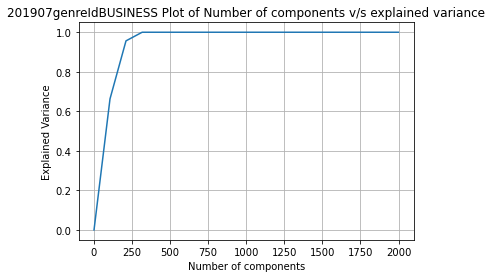

 15%|█▌        | 3/20 [00:00<00:00, 24.50it/s]

FIND OPTIMAL SVD COMPONENTS
201907  --  genreId  --  FINANCE
Number of components = 0 and explained variance = 0.0
Number of components = 105 and explained variance = 0.6587718621574943
Number of components = 210 and explained variance = 0.9453851550612316
Number of components = 316 and explained variance = 0.9999999999999999


 30%|███       | 6/20 [00:00<00:00, 16.06it/s]

Number of components = 421 and explained variance = 0.9999999999999998
Number of components = 526 and explained variance = 0.9999999999999999
Number of components = 631 and explained variance = 0.9999999999999999


 40%|████      | 8/20 [00:00<00:00, 13.90it/s]

Number of components = 736 and explained variance = 0.9999999999999999
Number of components = 842 and explained variance = 1.0


 50%|█████     | 10/20 [00:00<00:00, 12.01it/s]

Number of components = 947 and explained variance = 0.9999999999999998
Number of components = 1052 and explained variance = 0.9999999999999997


 60%|██████    | 12/20 [00:00<00:00, 10.94it/s]

Number of components = 1157 and explained variance = 1.0000000000000002
Number of components = 1263 and explained variance = 0.9999999999999999


 70%|███████   | 14/20 [00:01<00:00,  9.89it/s]

Number of components = 1368 and explained variance = 0.9999999999999998
Number of components = 1473 and explained variance = 0.9999999999999998


 85%|████████▌ | 17/20 [00:01<00:00,  9.13it/s]

Number of components = 1578 and explained variance = 0.9999999999999996
Number of components = 1683 and explained variance = 1.0


 95%|█████████▌| 19/20 [00:01<00:00,  8.33it/s]

Number of components = 1789 and explained variance = 0.9999999999999998
Number of components = 1894 and explained variance = 0.9999999999999997


100%|██████████| 20/20 [00:01<00:00, 10.07it/s]


Number of components = 1999 and explained variance = 0.9999999999999997


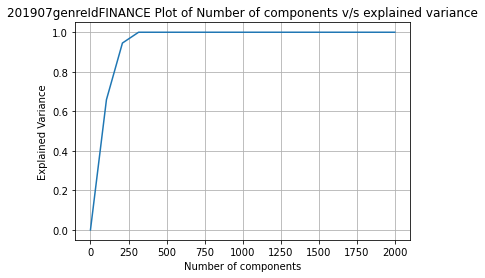

  0%|          | 0/20 [00:00<?, ?it/s]

FIND OPTIMAL SVD COMPONENTS
201907  --  genreId  --  GAME_STRATEGY


 15%|█▌        | 3/20 [00:00<00:00, 27.46it/s]

Number of components = 0 and explained variance = 0.0
Number of components = 105 and explained variance = 0.7038493242800382
Number of components = 210 and explained variance = 0.9900920976713884
Number of components = 316 and explained variance = 1.0


 30%|███       | 6/20 [00:00<00:00, 18.34it/s]

Number of components = 421 and explained variance = 0.9999999999999998
Number of components = 526 and explained variance = 1.0
Number of components = 631 and explained variance = 1.0000000000000002


 45%|████▌     | 9/20 [00:00<00:00, 15.35it/s]

Number of components = 736 and explained variance = 1.0
Number of components = 842 and explained variance = 1.0
Number of components = 947 and explained variance = 0.9999999999999998


 55%|█████▌    | 11/20 [00:00<00:00, 13.85it/s]

Number of components = 1052 and explained variance = 1.0
Number of components = 1157 and explained variance = 1.0


 65%|██████▌   | 13/20 [00:00<00:00, 12.19it/s]

Number of components = 1263 and explained variance = 0.9999999999999998
Number of components = 1368 and explained variance = 0.9999999999999998


 75%|███████▌  | 15/20 [00:01<00:00, 10.57it/s]

Number of components = 1473 and explained variance = 0.9999999999999998
Number of components = 1578 and explained variance = 0.9999999999999997


 85%|████████▌ | 17/20 [00:01<00:00,  9.70it/s]

Number of components = 1683 and explained variance = 1.0
Number of components = 1789 and explained variance = 1.0


100%|██████████| 20/20 [00:01<00:00, 10.92it/s]

Number of components = 1894 and explained variance = 1.0
Number of components = 1999 and explained variance = 1.0


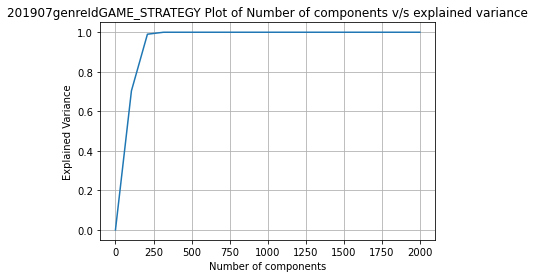

 15%|█▌        | 3/20 [00:00<00:00, 26.47it/s]

FIND OPTIMAL SVD COMPONENTS
201907  --  genreId  --  SPORTS
Number of components = 0 and explained variance = 0.0
Number of components = 105 and explained variance = 0.690340716359028
Number of components = 210 and explained variance = 0.9749018599914383
Number of components = 316 and explained variance = 1.0


 30%|███       | 6/20 [00:00<00:00, 15.87it/s]

Number of components = 421 and explained variance = 1.0000000000000002
Number of components = 526 and explained variance = 0.9999999999999999
Number of components = 631 and explained variance = 1.0


 50%|█████     | 10/20 [00:00<00:00, 12.88it/s]

Number of components = 736 and explained variance = 1.0
Number of components = 842 and explained variance = 1.0000000000000002
Number of components = 947 and explained variance = 0.9999999999999999


 60%|██████    | 12/20 [00:00<00:00, 11.47it/s]

Number of components = 1052 and explained variance = 1.0
Number of components = 1157 and explained variance = 1.0


 70%|███████   | 14/20 [00:01<00:00, 10.27it/s]

Number of components = 1263 and explained variance = 0.9999999999999998
Number of components = 1368 and explained variance = 1.0


 80%|████████  | 16/20 [00:01<00:00,  9.61it/s]

Number of components = 1473 and explained variance = 1.0000000000000004
Number of components = 1578 and explained variance = 0.9999999999999998


 90%|█████████ | 18/20 [00:01<00:00,  9.06it/s]

Number of components = 1683 and explained variance = 1.0000000000000002
Number of components = 1789 and explained variance = 1.0


100%|██████████| 20/20 [00:01<00:00, 10.43it/s]

Number of components = 1894 and explained variance = 0.9999999999999999
Number of components = 1999 and explained variance = 1.0000000000000002


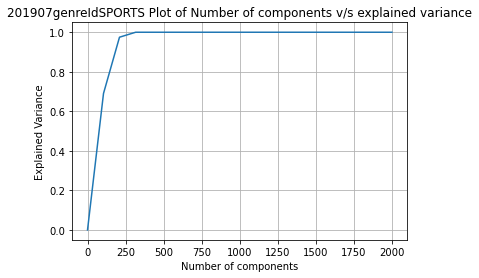

 15%|█▌        | 3/20 [00:00<00:00, 29.48it/s]

FIND OPTIMAL SVD COMPONENTS
201907  --  genreId  --  COMMUNICATION
Number of components = 0 and explained variance = 0.0
Number of components = 105 and explained variance = 0.7044379990380925
Number of components = 210 and explained variance = 0.9975190559785747
Number of components = 316 and explained variance = 1.0000000000000004


 30%|███       | 6/20 [00:00<00:00, 19.49it/s]

Number of components = 421 and explained variance = 1.0000000000000004
Number of components = 526 and explained variance = 1.0000000000000002
Number of components = 631 and explained variance = 1.0000000000000004


 45%|████▌     | 9/20 [00:00<00:00, 14.90it/s]

Number of components = 736 and explained variance = 1.0000000000000004
Number of components = 842 and explained variance = 1.0000000000000004
Number of components = 947 and explained variance = 1.0000000000000004


 55%|█████▌    | 11/20 [00:00<00:00, 13.27it/s]

Number of components = 1052 and explained variance = 1.0000000000000002
Number of components = 1157 and explained variance = 1.0000000000000004


 65%|██████▌   | 13/20 [00:00<00:00, 11.73it/s]

Number of components = 1263 and explained variance = 1.0
Number of components = 1368 and explained variance = 1.0000000000000007


 75%|███████▌  | 15/20 [00:01<00:00, 10.73it/s]

Number of components = 1473 and explained variance = 1.0000000000000002
Number of components = 1578 and explained variance = 1.0000000000000002


 85%|████████▌ | 17/20 [00:01<00:00, 10.00it/s]

Number of components = 1683 and explained variance = 1.0000000000000004
Number of components = 1789 and explained variance = 1.0000000000000004


100%|██████████| 20/20 [00:01<00:00, 11.11it/s]

Number of components = 1894 and explained variance = 1.0
Number of components = 1999 and explained variance = 1.0000000000000004


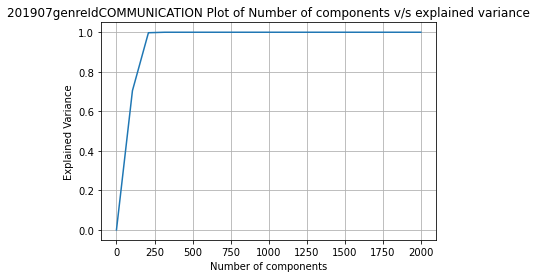

 25%|██▌       | 5/20 [00:00<00:00, 36.34it/s]

FIND OPTIMAL SVD COMPONENTS
201907  --  genreId  --  DATING
Number of components = 0 and explained variance = 0.0
Number of components = 105 and explained variance = 1.0
Number of components = 210 and explained variance = 1.0000000000000002
Number of components = 316 and explained variance = 1.0
Number of components = 421 and explained variance = 1.0000000000000002
Number of components = 526 and explained variance = 0.9999999999999999


 45%|████▌     | 9/20 [00:00<00:00, 27.71it/s]

Number of components = 631 and explained variance = 0.9999999999999999
Number of components = 736 and explained variance = 1.0
Number of components = 842 and explained variance = 0.9999999999999999
Number of components = 947 and explained variance = 1.0
Number of components = 1052 and explained variance = 1.0


 60%|██████    | 12/20 [00:00<00:00, 22.89it/s]

Number of components = 1157 and explained variance = 1.0
Number of components = 1263 and explained variance = 0.9999999999999998
Number of components = 1368 and explained variance = 1.0


 85%|████████▌ | 17/20 [00:00<00:00, 17.27it/s]

Number of components = 1473 and explained variance = 0.9999999999999999
Number of components = 1578 and explained variance = 1.0
Number of components = 1683 and explained variance = 1.0000000000000002


100%|██████████| 20/20 [00:01<00:00, 18.24it/s]

Number of components = 1789 and explained variance = 1.0
Number of components = 1894 and explained variance = 1.0
Number of components = 1999 and explained variance = 0.9999999999999997


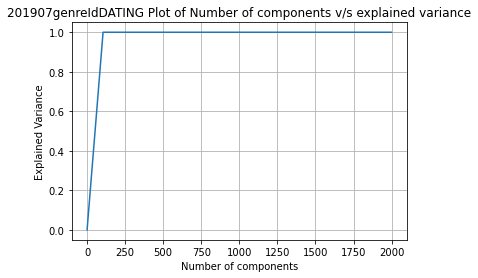

 15%|█▌        | 3/20 [00:00<00:00, 27.32it/s]

FIND OPTIMAL SVD COMPONENTS
201907  --  genreId  --  ENTERTAINMENT
Number of components = 0 and explained variance = 0.0
Number of components = 105 and explained variance = 0.6943977447099042
Number of components = 210 and explained variance = 0.9913487528500405
Number of components = 316 and explained variance = 1.0000000000000004


 30%|███       | 6/20 [00:00<00:00, 17.24it/s]

Number of components = 421 and explained variance = 1.0
Number of components = 526 and explained variance = 1.0000000000000004
Number of components = 631 and explained variance = 1.0000000000000007


 50%|█████     | 10/20 [00:00<00:00, 14.24it/s]

Number of components = 736 and explained variance = 1.0000000000000002
Number of components = 842 and explained variance = 1.0000000000000004
Number of components = 947 and explained variance = 1.0000000000000004


 60%|██████    | 12/20 [00:00<00:00, 12.98it/s]

Number of components = 1052 and explained variance = 1.0000000000000002
Number of components = 1157 and explained variance = 1.0000000000000002
Number of components = 1263 and explained variance = 1.0000000000000002


 70%|███████   | 14/20 [00:01<00:00, 11.66it/s]

Number of components = 1368 and explained variance = 1.0000000000000002
Number of components = 1473 and explained variance = 1.0000000000000002


 80%|████████  | 16/20 [00:01<00:00, 10.56it/s]

Number of components = 1578 and explained variance = 1.0000000000000004
Number of components = 1683 and explained variance = 1.0000000000000004


 90%|█████████ | 18/20 [00:01<00:00,  9.84it/s]

Number of components = 1789 and explained variance = 1.0000000000000009
Number of components = 1894 and explained variance = 1.0000000000000004


100%|██████████| 20/20 [00:01<00:00, 11.40it/s]

Number of components = 1999 and explained variance = 1.0


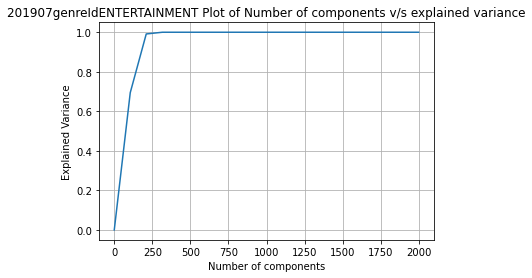

  0%|          | 0/20 [00:00<?, ?it/s]

FIND OPTIMAL SVD COMPONENTS
201907  --  genreId  --  GAME_BOARD


 15%|█▌        | 3/20 [00:00<00:00, 28.19it/s]

Number of components = 0 and explained variance = 0.0
Number of components = 105 and explained variance = 0.7536033675287099
Number of components = 210 and explained variance = 1.0000000000000002
Number of components = 316 and explained variance = 0.9999999999999998


 30%|███       | 6/20 [00:00<00:00, 19.30it/s]

Number of components = 421 and explained variance = 1.0
Number of components = 526 and explained variance = 1.0
Number of components = 631 and explained variance = 1.0


 45%|████▌     | 9/20 [00:00<00:00, 15.58it/s]

Number of components = 736 and explained variance = 1.0
Number of components = 842 and explained variance = 1.0000000000000002
Number of components = 947 and explained variance = 1.0


 55%|█████▌    | 11/20 [00:00<00:00, 13.87it/s]

Number of components = 1052 and explained variance = 1.0
Number of components = 1157 and explained variance = 1.0000000000000002


 65%|██████▌   | 13/20 [00:00<00:00, 12.16it/s]

Number of components = 1263 and explained variance = 1.0000000000000002
Number of components = 1368 and explained variance = 1.0000000000000002


 75%|███████▌  | 15/20 [00:01<00:00, 10.86it/s]

Number of components = 1473 and explained variance = 1.0000000000000002
Number of components = 1578 and explained variance = 0.9999999999999998


 85%|████████▌ | 17/20 [00:01<00:00,  9.98it/s]

Number of components = 1683 and explained variance = 1.0
Number of components = 1789 and explained variance = 1.0000000000000002


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]

Number of components = 1894 and explained variance = 1.0
Number of components = 1999 and explained variance = 1.0


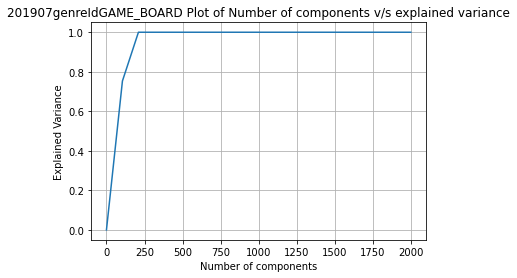

 25%|██▌       | 5/20 [00:00<00:00, 43.89it/s]

FIND OPTIMAL SVD COMPONENTS
201907  --  genreId  --  EVENTS
Number of components = 0 and explained variance = 0.0
Number of components = 105 and explained variance = 1.0000000000000002
Number of components = 210 and explained variance = 1.0000000000000002
Number of components = 316 and explained variance = 1.0
Number of components = 421 and explained variance = 1.0000000000000002
Number of components = 526 and explained variance = 1.0000000000000004
Number of components = 631 and explained variance = 1.0000000000000002


 50%|█████     | 10/20 [00:00<00:00, 30.04it/s]

Number of components = 736 and explained variance = 0.9999999999999999
Number of components = 842 and explained variance = 1.0000000000000002
Number of components = 947 and explained variance = 0.9999999999999996
Number of components = 1052 and explained variance = 0.9999999999999999
Number of components = 1157 and explained variance = 1.0000000000000002


 70%|███████   | 14/20 [00:00<00:00, 22.63it/s]

Number of components = 1263 and explained variance = 1.0000000000000002
Number of components = 1368 and explained variance = 1.0
Number of components = 1473 and explained variance = 1.0


 85%|████████▌ | 17/20 [00:00<00:00, 19.15it/s]

Number of components = 1578 and explained variance = 1.0
Number of components = 1683 and explained variance = 0.9999999999999997
Number of components = 1789 and explained variance = 0.9999999999999997


100%|██████████| 20/20 [00:01<00:00, 19.80it/s]

Number of components = 1894 and explained variance = 1.0000000000000007
Number of components = 1999 and explained variance = 0.9999999999999999


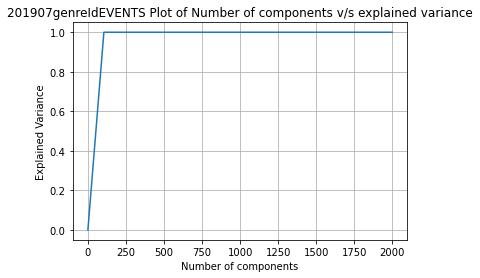

 20%|██        | 4/20 [00:00<00:00, 34.74it/s]

FIND OPTIMAL SVD COMPONENTS
201907  --  genreId  --  SHOPPING
Number of components = 0 and explained variance = 0.0
Number of components = 105 and explained variance = 0.8752313358197596
Number of components = 210 and explained variance = 1.0000000000000002
Number of components = 316 and explained variance = 1.0
Number of components = 421 and explained variance = 1.0000000000000002


 40%|████      | 8/20 [00:00<00:00, 25.01it/s]

Number of components = 526 and explained variance = 1.0
Number of components = 631 and explained variance = 1.0
Number of components = 736 and explained variance = 1.0000000000000002
Number of components = 842 and explained variance = 1.0000000000000002


 55%|█████▌    | 11/20 [00:00<00:00, 21.05it/s]

Number of components = 947 and explained variance = 1.0000000000000002
Number of components = 1052 and explained variance = 1.0
Number of components = 1157 and explained variance = 1.0


 70%|███████   | 14/20 [00:00<00:00, 17.21it/s]

Number of components = 1263 and explained variance = 1.0
Number of components = 1368 and explained variance = 1.0
Number of components = 1473 and explained variance = 1.0


 90%|█████████ | 18/20 [00:01<00:00, 13.89it/s]

Number of components = 1578 and explained variance = 0.9999999999999996
Number of components = 1683 and explained variance = 1.0
Number of components = 1789 and explained variance = 0.9999999999999998


100%|██████████| 20/20 [00:01<00:00, 15.63it/s]

Number of components = 1894 and explained variance = 1.0000000000000002
Number of components = 1999 and explained variance = 1.0000000000000002


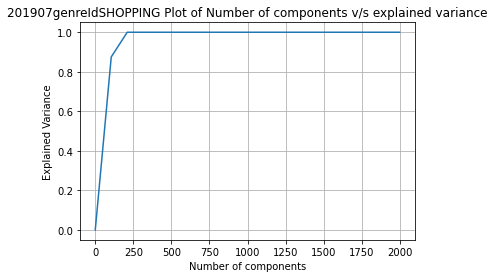

 15%|█▌        | 3/20 [00:00<00:00, 26.48it/s]

FIND OPTIMAL SVD COMPONENTS
201907  --  genreId  --  FOOD_AND_DRINK
Number of components = 0 and explained variance = 0.0
Number of components = 105 and explained variance = 0.7121706668092274
Number of components = 210 and explained variance = 1.0000000000000002
Number of components = 316 and explained variance = 0.9999999999999999


 30%|███       | 6/20 [00:00<00:00, 18.10it/s]

Number of components = 421 and explained variance = 1.0
Number of components = 526 and explained variance = 0.9999999999999999
Number of components = 631 and explained variance = 1.0


 50%|█████     | 10/20 [00:00<00:00, 14.24it/s]

Number of components = 736 and explained variance = 1.0000000000000002
Number of components = 842 and explained variance = 0.9999999999999998
Number of components = 947 and explained variance = 0.9999999999999999


 60%|██████    | 12/20 [00:00<00:00, 12.89it/s]

Number of components = 1052 and explained variance = 0.9999999999999999
Number of components = 1157 and explained variance = 0.9999999999999999
Number of components = 1263 and explained variance = 1.0


 70%|███████   | 14/20 [00:01<00:00, 11.52it/s]

Number of components = 1368 and explained variance = 1.0
Number of components = 1473 and explained variance = 1.0


 80%|████████  | 16/20 [00:01<00:00, 10.27it/s]

Number of components = 1578 and explained variance = 1.0
Number of components = 1683 and explained variance = 1.0000000000000002


 95%|█████████▌| 19/20 [00:01<00:00,  8.85it/s]

Number of components = 1789 and explained variance = 0.9999999999999999
Number of components = 1894 and explained variance = 1.0


100%|██████████| 20/20 [00:01<00:00, 11.01it/s]


Number of components = 1999 and explained variance = 1.0


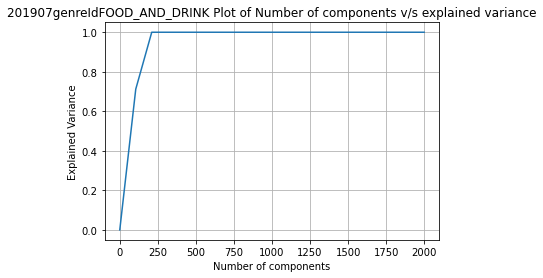

  0%|          | 0/20 [00:00<?, ?it/s]

FIND OPTIMAL SVD COMPONENTS
201907  --  genreId  --  HEALTH_AND_FITNESS


 15%|█▌        | 3/20 [00:00<00:00, 26.55it/s]

Number of components = 0 and explained variance = 0.0
Number of components = 105 and explained variance = 0.6856248911989641
Number of components = 210 and explained variance = 0.9586706019212823
Number of components = 316 and explained variance = 1.0000000000000002


 30%|███       | 6/20 [00:00<00:00, 15.51it/s]

Number of components = 421 and explained variance = 1.0
Number of components = 526 and explained variance = 0.9999999999999999
Number of components = 631 and explained variance = 1.0000000000000002


 40%|████      | 8/20 [00:00<00:00, 12.75it/s]

Number of components = 736 and explained variance = 1.0
Number of components = 842 and explained variance = 1.0


 50%|█████     | 10/20 [00:00<00:00, 11.39it/s]

Number of components = 947 and explained variance = 1.0
Number of components = 1052 and explained variance = 1.0


 60%|██████    | 12/20 [00:01<00:00, 10.44it/s]

Number of components = 1157 and explained variance = 1.0
Number of components = 1263 and explained variance = 1.0000000000000002


 70%|███████   | 14/20 [00:01<00:00,  9.50it/s]

Number of components = 1368 and explained variance = 0.9999999999999997
Number of components = 1473 and explained variance = 1.0


 85%|████████▌ | 17/20 [00:01<00:00,  8.45it/s]

Number of components = 1578 and explained variance = 0.9999999999999998
Number of components = 1683 and explained variance = 1.0000000000000004


 95%|█████████▌| 19/20 [00:01<00:00,  7.70it/s]

Number of components = 1789 and explained variance = 1.0000000000000002
Number of components = 1894 and explained variance = 1.0000000000000002


100%|██████████| 20/20 [00:02<00:00,  9.45it/s]


Number of components = 1999 and explained variance = 1.0


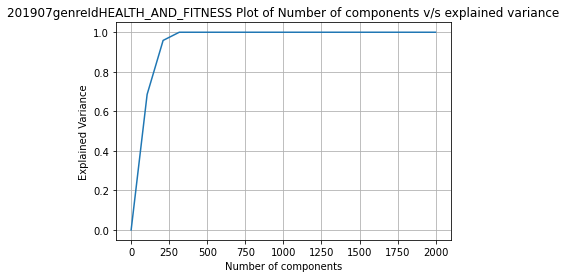

  0%|          | 0/20 [00:00<?, ?it/s]

FIND OPTIMAL SVD COMPONENTS
201907  --  genreId  --  HOUSE_AND_HOME


 20%|██        | 4/20 [00:00<00:00, 34.21it/s]

Number of components = 0 and explained variance = 0.0
Number of components = 105 and explained variance = 0.968066831807272
Number of components = 210 and explained variance = 0.9999999999999998
Number of components = 316 and explained variance = 1.0000000000000002
Number of components = 421 and explained variance = 0.9999999999999994
Number of components = 526 and explained variance = 0.9999999999999999


 40%|████      | 8/20 [00:00<00:00, 25.52it/s]

Number of components = 631 and explained variance = 0.9999999999999997
Number of components = 736 and explained variance = 1.0
Number of components = 842 and explained variance = 1.0
Number of components = 947 and explained variance = 1.0


 55%|█████▌    | 11/20 [00:00<00:00, 21.36it/s]

Number of components = 1052 and explained variance = 1.0
Number of components = 1157 and explained variance = 0.9999999999999999
Number of components = 1263 and explained variance = 0.9999999999999999


 80%|████████  | 16/20 [00:00<00:00, 16.46it/s]

Number of components = 1368 and explained variance = 0.9999999999999999
Number of components = 1473 and explained variance = 0.9999999999999999
Number of components = 1578 and explained variance = 1.0


 90%|█████████ | 18/20 [00:01<00:00, 14.77it/s]

Number of components = 1683 and explained variance = 0.9999999999999999
Number of components = 1789 and explained variance = 1.0
Number of components = 1894 and explained variance = 1.0


100%|██████████| 20/20 [00:01<00:00, 16.65it/s]


Number of components = 1999 and explained variance = 1.0


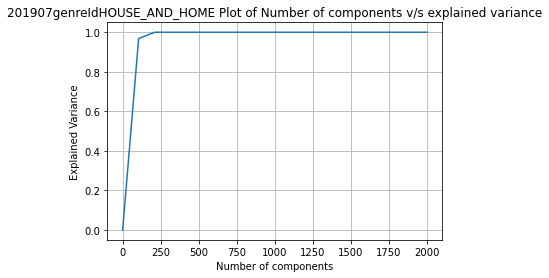

  0%|          | 0/20 [00:00<?, ?it/s]

FIND OPTIMAL SVD COMPONENTS
201907  --  genreId  --  TOOLS
Number of components = 0 and explained variance = 0.0


 15%|█▌        | 3/20 [00:00<00:00, 28.30it/s]

Number of components = 105 and explained variance = 0.7147025023078922
Number of components = 210 and explained variance = 0.9936959744395153
Number of components = 316 and explained variance = 1.0


 30%|███       | 6/20 [00:00<00:00, 18.45it/s]

Number of components = 421 and explained variance = 1.0
Number of components = 526 and explained variance = 1.0
Number of components = 631 and explained variance = 1.0


 45%|████▌     | 9/20 [00:00<00:00, 14.88it/s]

Number of components = 736 and explained variance = 1.0
Number of components = 842 and explained variance = 1.0
Number of components = 947 and explained variance = 1.0


 55%|█████▌    | 11/20 [00:00<00:00, 13.56it/s]

Number of components = 1052 and explained variance = 1.0000000000000002
Number of components = 1157 and explained variance = 1.0000000000000002


 65%|██████▌   | 13/20 [00:00<00:00, 12.05it/s]

Number of components = 1263 and explained variance = 0.9999999999999999
Number of components = 1368 and explained variance = 1.0


 75%|███████▌  | 15/20 [00:01<00:00, 10.99it/s]

Number of components = 1473 and explained variance = 1.0
Number of components = 1578 and explained variance = 1.0


 85%|████████▌ | 17/20 [00:01<00:00, 10.24it/s]

Number of components = 1683 and explained variance = 1.0
Number of components = 1789 and explained variance = 1.0


100%|██████████| 20/20 [00:01<00:00, 11.17it/s]

Number of components = 1894 and explained variance = 0.9999999999999998
Number of components = 1999 and explained variance = 1.0


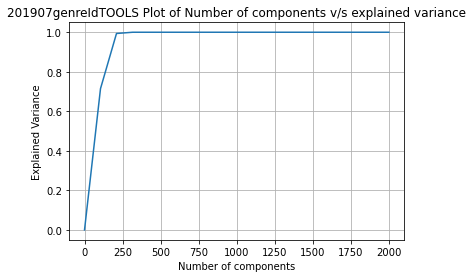

 25%|██▌       | 5/20 [00:00<00:00, 43.70it/s]

FIND OPTIMAL SVD COMPONENTS
201907  --  genreId  --  LIBRARIES_AND_DEMO
Number of components = 0 and explained variance = 0.0
Number of components = 105 and explained variance = 1.0000000000000002
Number of components = 210 and explained variance = 0.9999999999999998
Number of components = 316 and explained variance = 0.9999999999999999
Number of components = 421 and explained variance = 0.9999999999999994
Number of components = 526 and explained variance = 1.0000000000000009
Number of components = 631 and explained variance = 0.9999999999999994


 50%|█████     | 10/20 [00:00<00:00, 29.68it/s]

Number of components = 736 and explained variance = 0.9999999999999994
Number of components = 842 and explained variance = 0.9999999999999994
Number of components = 947 and explained variance = 0.9999999999999996
Number of components = 1052 and explained variance = 0.9999999999999996
Number of components = 1157 and explained variance = 0.9999999999999997


 70%|███████   | 14/20 [00:00<00:00, 22.85it/s]

Number of components = 1263 and explained variance = 1.0
Number of components = 1368 and explained variance = 1.0
Number of components = 1473 and explained variance = 0.9999999999999996
Number of components = 1578 and explained variance = 1.0


 85%|████████▌ | 17/20 [00:00<00:00, 19.56it/s]

Number of components = 1683 and explained variance = 0.9999999999999998
Number of components = 1789 and explained variance = 1.0
Number of components = 1894 and explained variance = 0.9999999999999997


100%|██████████| 20/20 [00:00<00:00, 20.00it/s]

Number of components = 1999 and explained variance = 0.9999999999999996


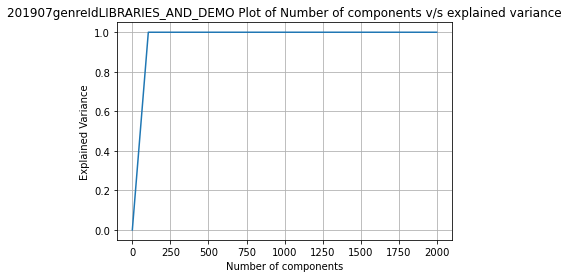

  0%|          | 0/20 [00:00<?, ?it/s]

FIND OPTIMAL SVD COMPONENTS
201907  --  genreId  --  MAPS_AND_NAVIGATION
Number of components = 0 and explained variance = 0.0


 15%|█▌        | 3/20 [00:00<00:00, 29.32it/s]

Number of components = 105 and explained variance = 0.7754619031872791
Number of components = 210 and explained variance = 1.0000000000000009
Number of components = 316 and explained variance = 1.0000000000000004
Number of components = 421 and explained variance = 1.0000000000000007


 30%|███       | 6/20 [00:00<00:00, 19.60it/s]

Number of components = 526 and explained variance = 1.0000000000000004
Number of components = 631 and explained variance = 1.0000000000000007
Number of components = 736 and explained variance = 1.0000000000000004


 45%|████▌     | 9/20 [00:00<00:00, 15.77it/s]

Number of components = 842 and explained variance = 1.0000000000000007
Number of components = 947 and explained variance = 1.0000000000000009


 55%|█████▌    | 11/20 [00:00<00:00, 14.31it/s]

Number of components = 1052 and explained variance = 1.0000000000000002


 65%|██████▌   | 13/20 [00:00<00:00, 12.75it/s]

Number of components = 1157 and explained variance = 1.0000000000000004
Number of components = 1263 and explained variance = 1.0000000000000004


 75%|███████▌  | 15/20 [00:01<00:00, 11.37it/s]

Number of components = 1368 and explained variance = 1.0000000000000007
Number of components = 1473 and explained variance = 1.0000000000000007


 85%|████████▌ | 17/20 [00:01<00:00, 10.72it/s]

Number of components = 1578 and explained variance = 1.0000000000000004
Number of components = 1683 and explained variance = 1.0000000000000004


 95%|█████████▌| 19/20 [00:01<00:00,  9.91it/s]

Number of components = 1789 and explained variance = 1.0000000000000007
Number of components = 1894 and explained variance = 1.0000000000000004


100%|██████████| 20/20 [00:01<00:00, 11.80it/s]


Number of components = 1999 and explained variance = 1.0000000000000007


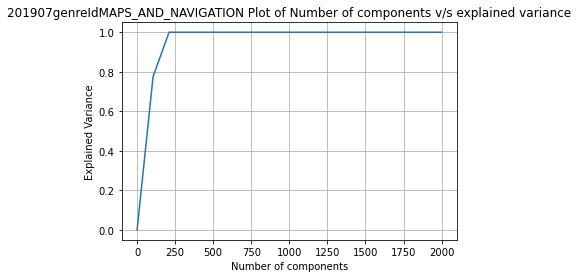

  0%|          | 0/20 [00:00<?, ?it/s]

FIND OPTIMAL SVD COMPONENTS
201907  --  genreId  --  MEDICAL


 15%|█▌        | 3/20 [00:00<00:00, 26.86it/s]

Number of components = 0 and explained variance = 0.0
Number of components = 105 and explained variance = 0.6744782263881341
Number of components = 210 and explained variance = 0.9663886040081575
Number of components = 316 and explained variance = 1.0000000000000002


 30%|███       | 6/20 [00:00<00:00, 17.29it/s]

Number of components = 421 and explained variance = 1.0
Number of components = 526 and explained variance = 1.0000000000000002
Number of components = 631 and explained variance = 1.0000000000000004


 50%|█████     | 10/20 [00:00<00:00, 13.44it/s]

Number of components = 736 and explained variance = 1.0
Number of components = 842 and explained variance = 1.0000000000000004
Number of components = 947 and explained variance = 1.0000000000000002


 60%|██████    | 12/20 [00:00<00:00, 12.05it/s]

Number of components = 1052 and explained variance = 1.0000000000000004
Number of components = 1157 and explained variance = 1.0000000000000002


 70%|███████   | 14/20 [00:01<00:00, 10.53it/s]

Number of components = 1263 and explained variance = 1.0000000000000004
Number of components = 1368 and explained variance = 1.0000000000000002


 80%|████████  | 16/20 [00:01<00:00,  9.81it/s]

Number of components = 1473 and explained variance = 1.0000000000000002
Number of components = 1578 and explained variance = 1.0000000000000002


 90%|█████████ | 18/20 [00:01<00:00,  9.06it/s]

Number of components = 1683 and explained variance = 1.0000000000000002
Number of components = 1789 and explained variance = 1.0000000000000002


100%|██████████| 20/20 [00:01<00:00, 10.65it/s]

Number of components = 1894 and explained variance = 1.0000000000000004
Number of components = 1999 and explained variance = 1.0000000000000004


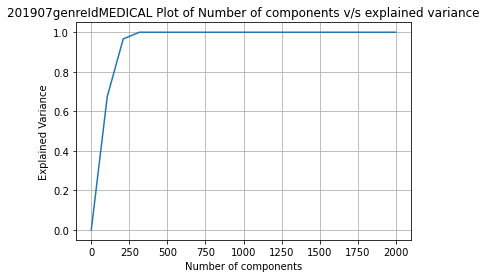

 15%|█▌        | 3/20 [00:00<00:00, 29.08it/s]

FIND OPTIMAL SVD COMPONENTS
201907  --  genreId  --  MUSIC_AND_AUDIO
Number of components = 0 and explained variance = 0.0
Number of components = 105 and explained variance = 0.7223070880250179
Number of components = 210 and explained variance = 0.9923421085670218
Number of components = 316 and explained variance = 1.0000000000000004


 30%|███       | 6/20 [00:00<00:00, 19.39it/s]

Number of components = 421 and explained variance = 1.0000000000000004
Number of components = 526 and explained variance = 1.0000000000000004
Number of components = 631 and explained variance = 1.0000000000000004


 45%|████▌     | 9/20 [00:00<00:00, 15.38it/s]

Number of components = 736 and explained variance = 1.0000000000000007
Number of components = 842 and explained variance = 1.0000000000000004
Number of components = 947 and explained variance = 1.0000000000000004


 65%|██████▌   | 13/20 [00:00<00:00, 12.54it/s]

Number of components = 1052 and explained variance = 1.0000000000000002
Number of components = 1157 and explained variance = 1.0
Number of components = 1263 and explained variance = 1.0000000000000007


 75%|███████▌  | 15/20 [00:01<00:00, 11.37it/s]

Number of components = 1368 and explained variance = 1.0000000000000004
Number of components = 1473 and explained variance = 1.0000000000000004


 85%|████████▌ | 17/20 [00:01<00:00, 10.57it/s]

Number of components = 1578 and explained variance = 1.0000000000000007
Number of components = 1683 and explained variance = 1.0000000000000004


 95%|█████████▌| 19/20 [00:01<00:00,  9.80it/s]

Number of components = 1789 and explained variance = 1.0000000000000007
Number of components = 1894 and explained variance = 1.0000000000000009


100%|██████████| 20/20 [00:01<00:00, 11.64it/s]


Number of components = 1999 and explained variance = 1.0000000000000007


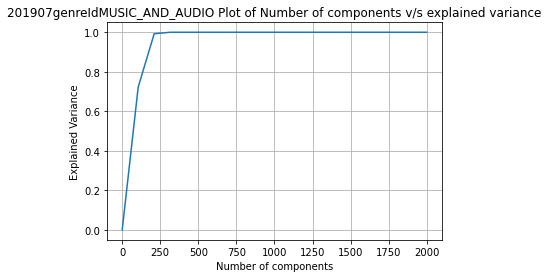

  0%|          | 0/20 [00:00<?, ?it/s]

FIND OPTIMAL SVD COMPONENTS
201907  --  genreId  --  NEWS_AND_MAGAZINES


 20%|██        | 4/20 [00:00<00:00, 26.66it/s]

Number of components = 0 and explained variance = 0.0
Number of components = 105 and explained variance = 0.8562146657893607
Number of components = 210 and explained variance = 0.9999999999999998
Number of components = 316 and explained variance = 0.9999999999999999
Number of components = 421 and explained variance = 0.9999999999999998


 35%|███▌      | 7/20 [00:00<00:00, 20.72it/s]

Number of components = 526 and explained variance = 0.9999999999999998
Number of components = 631 and explained variance = 0.9999999999999996
Number of components = 736 and explained variance = 0.9999999999999998
Number of components = 842 and explained variance = 0.9999999999999998


 50%|█████     | 10/20 [00:00<00:00, 18.36it/s]

Number of components = 947 and explained variance = 0.9999999999999994
Number of components = 1052 and explained variance = 0.9999999999999999


 60%|██████    | 12/20 [00:00<00:00, 16.52it/s]

Number of components = 1157 and explained variance = 0.9999999999999997


 70%|███████   | 14/20 [00:00<00:00, 14.65it/s]

Number of components = 1263 and explained variance = 0.9999999999999994
Number of components = 1368 and explained variance = 0.9999999999999999
Number of components = 1473 and explained variance = 0.9999999999999999


 80%|████████  | 16/20 [00:01<00:00, 13.27it/s]

Number of components = 1578 and explained variance = 0.9999999999999996
Number of components = 1683 and explained variance = 0.9999999999999997


 90%|█████████ | 18/20 [00:01<00:00, 12.29it/s]

Number of components = 1789 and explained variance = 0.9999999999999999
Number of components = 1894 and explained variance = 0.9999999999999999


100%|██████████| 20/20 [00:01<00:00, 13.94it/s]

Number of components = 1999 and explained variance = 0.9999999999999999


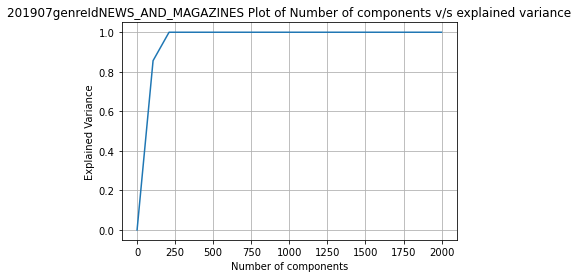

  0%|          | 0/20 [00:00<?, ?it/s]

FIND OPTIMAL SVD COMPONENTS
201907  --  genreId  --  PARENTING


 20%|██        | 4/20 [00:00<00:00, 30.88it/s]

Number of components = 0 and explained variance = 0.0
Number of components = 105 and explained variance = 0.9184639783732464
Number of components = 210 and explained variance = 0.9999999999999998
Number of components = 316 and explained variance = 1.0
Number of components = 421 and explained variance = 1.0
Number of components = 526 and explained variance = 1.0000000000000002


 40%|████      | 8/20 [00:00<00:00, 24.84it/s]

Number of components = 631 and explained variance = 0.9999999999999998
Number of components = 736 and explained variance = 0.9999999999999998
Number of components = 842 and explained variance = 1.0
Number of components = 947 and explained variance = 1.0000000000000002


 55%|█████▌    | 11/20 [00:00<00:00, 21.19it/s]

Number of components = 1052 and explained variance = 1.0
Number of components = 1157 and explained variance = 1.0
Number of components = 1263 and explained variance = 1.0


 70%|███████   | 14/20 [00:00<00:00, 17.70it/s]

Number of components = 1368 and explained variance = 1.0
Number of components = 1473 and explained variance = 1.0


 80%|████████  | 16/20 [00:00<00:00, 15.98it/s]

Number of components = 1578 and explained variance = 1.0


 90%|█████████ | 18/20 [00:01<00:00, 14.58it/s]

Number of components = 1683 and explained variance = 0.9999999999999999
Number of components = 1789 and explained variance = 1.0000000000000004
Number of components = 1894 and explained variance = 1.0


100%|██████████| 20/20 [00:01<00:00, 16.34it/s]


Number of components = 1999 and explained variance = 0.9999999999999998


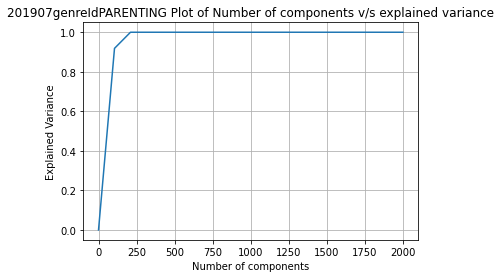

  0%|          | 0/20 [00:00<?, ?it/s]

FIND OPTIMAL SVD COMPONENTS
201907  --  genreId  --  GAME_PUZZLE


 15%|█▌        | 3/20 [00:00<00:00, 29.06it/s]

Number of components = 0 and explained variance = 0.0
Number of components = 105 and explained variance = 0.6216358488205894
Number of components = 210 and explained variance = 0.9202368399000747
Number of components = 316 and explained variance = 1.0


 30%|███       | 6/20 [00:00<00:00, 16.50it/s]

Number of components = 421 and explained variance = 1.0000000000000004
Number of components = 526 and explained variance = 1.0000000000000004
Number of components = 631 and explained variance = 1.0000000000000002


 50%|█████     | 10/20 [00:00<00:00, 12.33it/s]

Number of components = 736 and explained variance = 1.0000000000000004
Number of components = 842 and explained variance = 1.0000000000000004
Number of components = 947 and explained variance = 1.0000000000000004


 60%|██████    | 12/20 [00:00<00:00, 10.99it/s]

Number of components = 1052 and explained variance = 1.0000000000000007
Number of components = 1157 and explained variance = 1.0


 70%|███████   | 14/20 [00:01<00:00,  9.82it/s]

Number of components = 1263 and explained variance = 1.0000000000000004
Number of components = 1368 and explained variance = 1.0


 80%|████████  | 16/20 [00:01<00:00,  9.15it/s]

Number of components = 1473 and explained variance = 1.0
Number of components = 1578 and explained variance = 1.0000000000000004


 90%|█████████ | 18/20 [00:01<00:00,  8.44it/s]

Number of components = 1683 and explained variance = 1.0000000000000002
Number of components = 1789 and explained variance = 1.0000000000000002


100%|██████████| 20/20 [00:02<00:00,  9.99it/s]

Number of components = 1894 and explained variance = 1.0000000000000002
Number of components = 1999 and explained variance = 1.0


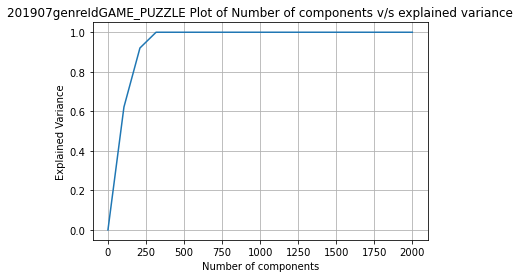

 20%|██        | 4/20 [00:00<00:00, 28.04it/s]

FIND OPTIMAL SVD COMPONENTS
201907  --  genreId  --  VIDEO_PLAYERS
Number of components = 0 and explained variance = 0.0
Number of components = 105 and explained variance = 0.8117078980355454
Number of components = 210 and explained variance = 1.0000000000000002
Number of components = 316 and explained variance = 1.0
Number of components = 421 and explained variance = 0.9999999999999998


 35%|███▌      | 7/20 [00:00<00:00, 20.54it/s]

Number of components = 526 and explained variance = 1.0000000000000002
Number of components = 631 and explained variance = 1.0000000000000002
Number of components = 736 and explained variance = 1.0


 50%|█████     | 10/20 [00:00<00:00, 17.43it/s]

Number of components = 842 and explained variance = 1.0000000000000002
Number of components = 947 and explained variance = 1.0000000000000004
Number of components = 1052 and explained variance = 1.0


 70%|███████   | 14/20 [00:00<00:00, 13.60it/s]

Number of components = 1157 and explained variance = 1.0
Number of components = 1263 and explained variance = 1.0000000000000002
Number of components = 1368 and explained variance = 1.0000000000000002


 80%|████████  | 16/20 [00:01<00:00, 12.44it/s]

Number of components = 1473 and explained variance = 1.0
Number of components = 1578 and explained variance = 0.9999999999999998


 90%|█████████ | 18/20 [00:01<00:00, 11.31it/s]

Number of components = 1683 and explained variance = 1.0000000000000004
Number of components = 1789 and explained variance = 1.0000000000000002


100%|██████████| 20/20 [00:01<00:00, 13.15it/s]

Number of components = 1894 and explained variance = 0.9999999999999998
Number of components = 1999 and explained variance = 1.0


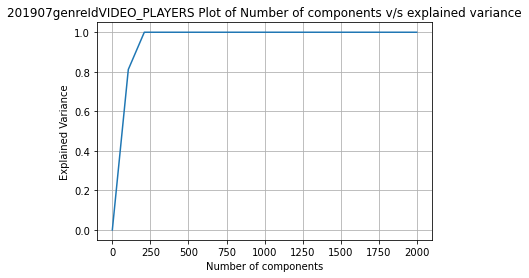

 15%|█▌        | 3/20 [00:00<00:00, 26.02it/s]

FIND OPTIMAL SVD COMPONENTS
201907  --  genreId  --  PRODUCTIVITY
Number of components = 0 and explained variance = 0.0
Number of components = 105 and explained variance = 0.6872923179166541
Number of components = 210 and explained variance = 0.9891254573178001
Number of components = 316 and explained variance = 0.9999999999999998


 30%|███       | 6/20 [00:00<00:00, 17.86it/s]

Number of components = 421 and explained variance = 0.9999999999999999
Number of components = 526 and explained variance = 1.0
Number of components = 631 and explained variance = 0.9999999999999999


 50%|█████     | 10/20 [00:00<00:00, 13.49it/s]

Number of components = 736 and explained variance = 1.0
Number of components = 842 and explained variance = 0.9999999999999999
Number of components = 947 and explained variance = 1.0


 60%|██████    | 12/20 [00:00<00:00, 12.05it/s]

Number of components = 1052 and explained variance = 0.9999999999999998
Number of components = 1157 and explained variance = 0.9999999999999998


 70%|███████   | 14/20 [00:01<00:00, 10.65it/s]

Number of components = 1263 and explained variance = 0.9999999999999998
Number of components = 1368 and explained variance = 1.0


 80%|████████  | 16/20 [00:01<00:00,  9.61it/s]

Number of components = 1473 and explained variance = 1.0
Number of components = 1578 and explained variance = 0.9999999999999998


 90%|█████████ | 18/20 [00:01<00:00,  8.89it/s]

Number of components = 1683 and explained variance = 0.9999999999999998
Number of components = 1789 and explained variance = 1.0


100%|██████████| 20/20 [00:01<00:00, 10.52it/s]

Number of components = 1894 and explained variance = 0.9999999999999996
Number of components = 1999 and explained variance = 0.9999999999999998


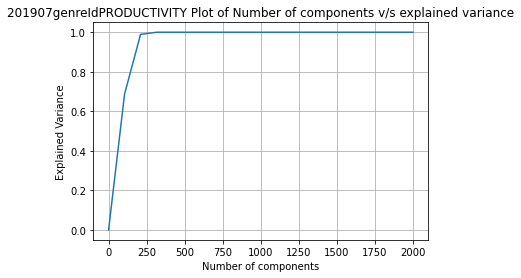

 15%|█▌        | 3/20 [00:00<00:00, 25.80it/s]

FIND OPTIMAL SVD COMPONENTS
201907  --  genreId  --  WEATHER
Number of components = 0 and explained variance = 0.0
Number of components = 105 and explained variance = 0.8138777891735458
Number of components = 210 and explained variance = 0.9999999999999999
Number of components = 316 and explained variance = 1.0


 30%|███       | 6/20 [00:00<00:00, 17.99it/s]

Number of components = 421 and explained variance = 1.0000000000000002
Number of components = 526 and explained variance = 1.0
Number of components = 631 and explained variance = 0.9999999999999998


 50%|█████     | 10/20 [00:00<00:00, 14.04it/s]

Number of components = 736 and explained variance = 1.0
Number of components = 842 and explained variance = 1.0
Number of components = 947 and explained variance = 1.0


 60%|██████    | 12/20 [00:00<00:00, 12.66it/s]

Number of components = 1052 and explained variance = 1.0
Number of components = 1157 and explained variance = 0.9999999999999999


 70%|███████   | 14/20 [00:01<00:00, 11.23it/s]

Number of components = 1263 and explained variance = 0.9999999999999998
Number of components = 1368 and explained variance = 1.0


 80%|████████  | 16/20 [00:01<00:00, 10.31it/s]

Number of components = 1473 and explained variance = 0.9999999999999998
Number of components = 1578 and explained variance = 0.9999999999999997


 90%|█████████ | 18/20 [00:01<00:00,  9.45it/s]

Number of components = 1683 and explained variance = 1.0
Number of components = 1789 and explained variance = 0.9999999999999998


100%|██████████| 20/20 [00:01<00:00, 11.08it/s]

Number of components = 1894 and explained variance = 0.9999999999999998
Number of components = 1999 and explained variance = 0.9999999999999998


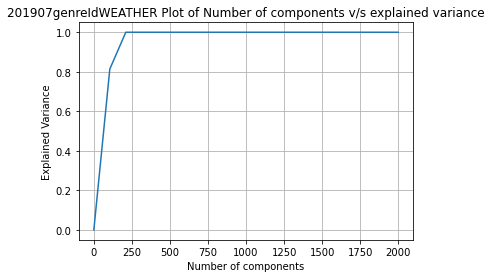

 15%|█▌        | 3/20 [00:00<00:00, 26.42it/s]

FIND OPTIMAL SVD COMPONENTS
201907  --  genreId  --  GAME_ARCADE
Number of components = 0 and explained variance = 0.0
Number of components = 105 and explained variance = 0.6938831591995824
Number of components = 210 and explained variance = 0.9842675815795573
Number of components = 316 and explained variance = 1.0000000000000002


 30%|███       | 6/20 [00:00<00:00, 16.90it/s]

Number of components = 421 and explained variance = 1.0
Number of components = 526 and explained variance = 1.0
Number of components = 631 and explained variance = 1.0


 50%|█████     | 10/20 [00:00<00:00, 13.26it/s]

Number of components = 736 and explained variance = 0.9999999999999999
Number of components = 842 and explained variance = 1.0000000000000002
Number of components = 947 and explained variance = 1.0000000000000002


 60%|██████    | 12/20 [00:00<00:00, 12.13it/s]

Number of components = 1052 and explained variance = 1.0
Number of components = 1157 and explained variance = 1.0


 70%|███████   | 14/20 [00:01<00:00, 10.84it/s]

Number of components = 1263 and explained variance = 1.0
Number of components = 1368 and explained variance = 1.0000000000000002


 80%|████████  | 16/20 [00:01<00:00, 10.19it/s]

Number of components = 1473 and explained variance = 1.0
Number of components = 1578 and explained variance = 1.0


 90%|█████████ | 18/20 [00:01<00:00,  9.58it/s]

Number of components = 1683 and explained variance = 1.0000000000000002
Number of components = 1789 and explained variance = 1.0


100%|██████████| 20/20 [00:01<00:00, 10.98it/s]

Number of components = 1894 and explained variance = 1.0
Number of components = 1999 and explained variance = 1.0000000000000002


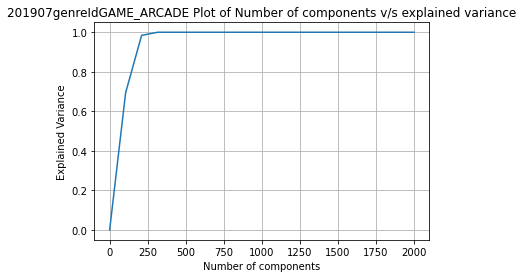

 20%|██        | 4/20 [00:00<00:00, 37.52it/s]

FIND OPTIMAL SVD COMPONENTS
201907  --  genreId  --  GAME_CASINO
Number of components = 0 and explained variance = 0.0
Number of components = 105 and explained variance = 0.971430928044542
Number of components = 210 and explained variance = 1.0000000000000002
Number of components = 316 and explained variance = 1.0000000000000002
Number of components = 421 and explained variance = 1.0000000000000004
Number of components = 526 and explained variance = 0.9999999999999994


 40%|████      | 8/20 [00:00<00:00, 28.03it/s]

Number of components = 631 and explained variance = 1.0000000000000004
Number of components = 736 and explained variance = 1.0000000000000002
Number of components = 842 and explained variance = 0.9999999999999999
Number of components = 947 and explained variance = 1.0000000000000002


 55%|█████▌    | 11/20 [00:00<00:00, 23.07it/s]

Number of components = 1052 and explained variance = 1.0000000000000002
Number of components = 1157 and explained variance = 0.9999999999999999
Number of components = 1263 and explained variance = 1.0000000000000004


 70%|███████   | 14/20 [00:00<00:00, 18.83it/s]

Number of components = 1368 and explained variance = 1.0
Number of components = 1473 and explained variance = 1.0000000000000004
Number of components = 1578 and explained variance = 1.0000000000000004


 95%|█████████▌| 19/20 [00:01<00:00, 14.96it/s]

Number of components = 1683 and explained variance = 1.0000000000000004
Number of components = 1789 and explained variance = 1.0000000000000004
Number of components = 1894 and explained variance = 1.0000000000000002


100%|██████████| 20/20 [00:01<00:00, 17.32it/s]


Number of components = 1999 and explained variance = 1.0


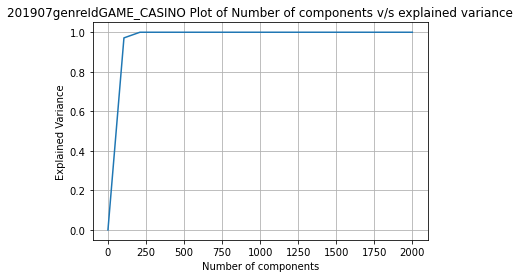

  0%|          | 0/20 [00:00<?, ?it/s]

FIND OPTIMAL SVD COMPONENTS
201907  --  genreId  --  GAME_CARD


 15%|█▌        | 3/20 [00:00<00:00, 24.16it/s]

Number of components = 0 and explained variance = 0.0
Number of components = 105 and explained variance = 0.7347310225167429
Number of components = 210 and explained variance = 0.9894059905420924
Number of components = 316 and explained variance = 1.0


 30%|███       | 6/20 [00:00<00:00, 17.57it/s]

Number of components = 421 and explained variance = 1.0000000000000002
Number of components = 526 and explained variance = 1.0000000000000004
Number of components = 631 and explained variance = 1.0000000000000004


 50%|█████     | 10/20 [00:00<00:00, 13.39it/s]

Number of components = 736 and explained variance = 1.0000000000000002
Number of components = 842 and explained variance = 1.0000000000000004
Number of components = 947 and explained variance = 1.0000000000000002


 60%|██████    | 12/20 [00:00<00:00, 12.33it/s]

Number of components = 1052 and explained variance = 1.0000000000000004
Number of components = 1157 and explained variance = 1.0000000000000002


 70%|███████   | 14/20 [00:01<00:00, 11.20it/s]

Number of components = 1263 and explained variance = 1.0000000000000002
Number of components = 1368 and explained variance = 1.0000000000000002


 80%|████████  | 16/20 [00:01<00:00, 10.42it/s]

Number of components = 1473 and explained variance = 1.0000000000000004
Number of components = 1578 and explained variance = 1.0000000000000002


 90%|█████████ | 18/20 [00:01<00:00,  9.73it/s]

Number of components = 1683 and explained variance = 1.0000000000000002
Number of components = 1789 and explained variance = 1.0000000000000002


100%|██████████| 20/20 [00:01<00:00, 11.14it/s]

Number of components = 1894 and explained variance = 1.0000000000000004
Number of components = 1999 and explained variance = 1.0


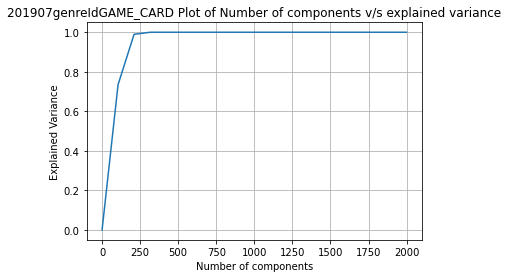

 15%|█▌        | 3/20 [00:00<00:00, 29.25it/s]

FIND OPTIMAL SVD COMPONENTS
201907  --  genreId  --  GAME_EDUCATIONAL
Number of components = 0 and explained variance = 0.0
Number of components = 105 and explained variance = 0.7238547062706048
Number of components = 210 and explained variance = 0.9690086145922296
Number of components = 316 and explained variance = 1.0


 30%|███       | 6/20 [00:00<00:00, 18.18it/s]

Number of components = 421 and explained variance = 1.0000000000000004
Number of components = 526 and explained variance = 1.0000000000000007
Number of components = 631 and explained variance = 1.0000000000000004


 45%|████▌     | 9/20 [00:00<00:00, 14.53it/s]

Number of components = 736 and explained variance = 1.0000000000000007
Number of components = 842 and explained variance = 1.0000000000000004
Number of components = 947 and explained variance = 1.0000000000000004


 55%|█████▌    | 11/20 [00:00<00:00, 13.24it/s]

Number of components = 1052 and explained variance = 1.0000000000000002
Number of components = 1157 and explained variance = 1.0000000000000004


 65%|██████▌   | 13/20 [00:00<00:00, 11.65it/s]

Number of components = 1263 and explained variance = 1.0000000000000002
Number of components = 1368 and explained variance = 1.0000000000000004


 75%|███████▌  | 15/20 [00:01<00:00, 10.63it/s]

Number of components = 1473 and explained variance = 1.0000000000000004
Number of components = 1578 and explained variance = 1.0000000000000004


 85%|████████▌ | 17/20 [00:01<00:00,  9.93it/s]

Number of components = 1683 and explained variance = 1.0000000000000007
Number of components = 1789 and explained variance = 1.0000000000000004


100%|██████████| 20/20 [00:01<00:00, 11.01it/s]

Number of components = 1894 and explained variance = 1.0000000000000004
Number of components = 1999 and explained variance = 1.0000000000000004


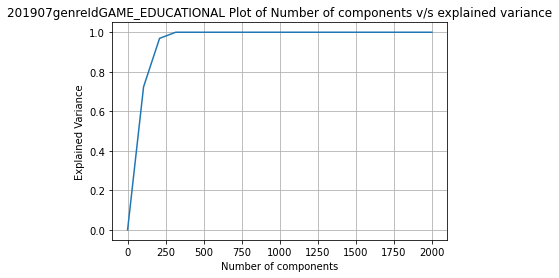

 20%|██        | 4/20 [00:00<00:00, 32.73it/s]

FIND OPTIMAL SVD COMPONENTS
201907  --  genreId  --  GAME_MUSIC
Number of components = 0 and explained variance = 0.0
Number of components = 105 and explained variance = 0.9729724927754444
Number of components = 210 and explained variance = 0.9999999999999999
Number of components = 316 and explained variance = 0.9999999999999994
Number of components = 421 and explained variance = 0.9999999999999997


 40%|████      | 8/20 [00:00<00:00, 26.29it/s]

Number of components = 526 and explained variance = 0.9999999999999996
Number of components = 631 and explained variance = 1.0
Number of components = 736 and explained variance = 0.9999999999999996
Number of components = 842 and explained variance = 0.9999999999999998


 55%|█████▌    | 11/20 [00:00<00:00, 22.38it/s]

Number of components = 947 and explained variance = 0.9999999999999997
Number of components = 1052 and explained variance = 0.9999999999999999
Number of components = 1157 and explained variance = 0.9999999999999996
Number of components = 1263 and explained variance = 1.0000000000000002


 80%|████████  | 16/20 [00:00<00:00, 16.73it/s]

Number of components = 1368 and explained variance = 0.9999999999999997
Number of components = 1473 and explained variance = 0.9999999999999998
Number of components = 1578 and explained variance = 0.9999999999999999


 90%|█████████ | 18/20 [00:00<00:00, 15.02it/s]

Number of components = 1683 and explained variance = 0.9999999999999998
Number of components = 1789 and explained variance = 0.9999999999999994
Number of components = 1894 and explained variance = 1.0


100%|██████████| 20/20 [00:01<00:00, 16.93it/s]


Number of components = 1999 and explained variance = 0.9999999999999999


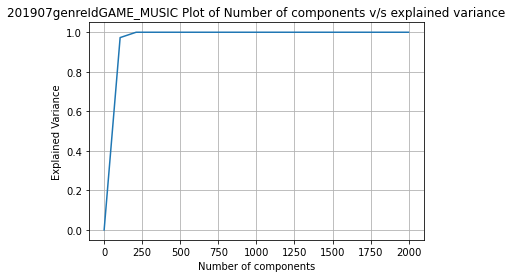

 20%|██        | 4/20 [00:00<00:00, 25.58it/s]

FIND OPTIMAL SVD COMPONENTS
201907  --  genreId  --  GAME_SPORTS
Number of components = 0 and explained variance = 0.0
Number of components = 105 and explained variance = 0.7563926119340442
Number of components = 210 and explained variance = 0.9995429614513133
Number of components = 316 and explained variance = 0.9999999999999996


 35%|███▌      | 7/20 [00:00<00:00, 18.60it/s]

Number of components = 421 and explained variance = 0.9999999999999996
Number of components = 526 and explained variance = 0.9999999999999993
Number of components = 631 and explained variance = 0.9999999999999996


 45%|████▌     | 9/20 [00:00<00:00, 16.32it/s]

Number of components = 736 and explained variance = 0.9999999999999996
Number of components = 842 and explained variance = 0.9999999999999996
Number of components = 947 and explained variance = 0.9999999999999994


 65%|██████▌   | 13/20 [00:00<00:00, 12.12it/s]

Number of components = 1052 and explained variance = 0.9999999999999994
Number of components = 1157 and explained variance = 0.9999999999999996
Number of components = 1263 and explained variance = 0.9999999999999994


 75%|███████▌  | 15/20 [00:01<00:00, 10.96it/s]

Number of components = 1368 and explained variance = 0.9999999999999993
Number of components = 1473 and explained variance = 0.9999999999999993


 85%|████████▌ | 17/20 [00:01<00:00, 10.34it/s]

Number of components = 1578 and explained variance = 0.9999999999999998
Number of components = 1683 and explained variance = 0.9999999999999998


 95%|█████████▌| 19/20 [00:01<00:00,  9.75it/s]

Number of components = 1789 and explained variance = 0.9999999999999996
Number of components = 1894 and explained variance = 0.9999999999999997


100%|██████████| 20/20 [00:01<00:00, 11.63it/s]


Number of components = 1999 and explained variance = 0.9999999999999993


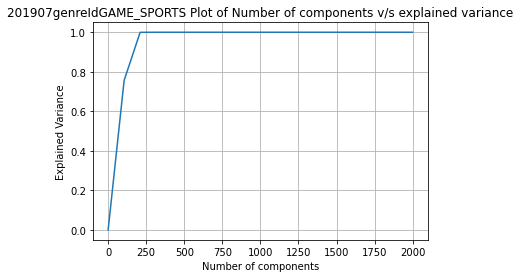

 20%|██        | 4/20 [00:00<00:00, 36.51it/s]

FIND OPTIMAL SVD COMPONENTS
201907  --  genreId  --  GAME_TRIVIA
Number of components = 0 and explained variance = 0.0
Number of components = 105 and explained variance = 0.9376668853564092
Number of components = 210 and explained variance = 1.0000000000000002
Number of components = 316 and explained variance = 1.0000000000000004
Number of components = 421 and explained variance = 1.0000000000000004
Number of components = 526 and explained variance = 1.0000000000000002


 40%|████      | 8/20 [00:00<00:00, 26.39it/s]

Number of components = 631 and explained variance = 1.0
Number of components = 736 and explained variance = 1.0000000000000002
Number of components = 842 and explained variance = 1.0000000000000002
Number of components = 947 and explained variance = 1.0000000000000004


 55%|█████▌    | 11/20 [00:00<00:00, 21.94it/s]

Number of components = 1052 and explained variance = 1.0000000000000002
Number of components = 1157 and explained variance = 1.0000000000000002
Number of components = 1263 and explained variance = 1.0


 80%|████████  | 16/20 [00:00<00:00, 16.36it/s]

Number of components = 1368 and explained variance = 1.0
Number of components = 1473 and explained variance = 1.0000000000000002
Number of components = 1578 and explained variance = 1.0000000000000004


 90%|█████████ | 18/20 [00:01<00:00, 14.47it/s]

Number of components = 1683 and explained variance = 1.0000000000000004
Number of components = 1789 and explained variance = 1.0
Number of components = 1894 and explained variance = 1.0000000000000004


100%|██████████| 20/20 [00:01<00:00, 16.56it/s]


Number of components = 1999 and explained variance = 1.0000000000000002


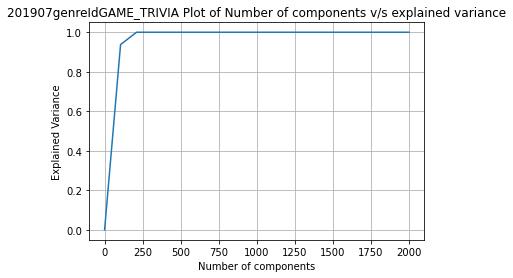

  0%|          | 0/20 [00:00<?, ?it/s]

FIND OPTIMAL SVD COMPONENTS
201907  --  genreId  --  GAME_WORD
Number of components = 0 and explained variance = 0.0


 20%|██        | 4/20 [00:00<00:00, 30.93it/s]

Number of components = 105 and explained variance = 0.8357457567389347
Number of components = 210 and explained variance = 1.0
Number of components = 316 and explained variance = 0.9999999999999998
Number of components = 421 and explained variance = 1.0000000000000002
Number of components = 526 and explained variance = 1.0000000000000002


 40%|████      | 8/20 [00:00<00:00, 21.90it/s]

Number of components = 631 and explained variance = 1.0000000000000004
Number of components = 736 and explained variance = 1.0000000000000002
Number of components = 842 and explained variance = 1.0000000000000002
Number of components = 947 and explained variance = 1.0


 55%|█████▌    | 11/20 [00:00<00:00, 18.28it/s]

Number of components = 1052 and explained variance = 1.0000000000000004
Number of components = 1157 and explained variance = 1.0


 65%|██████▌   | 13/20 [00:00<00:00, 15.94it/s]

Number of components = 1263 and explained variance = 1.0
Number of components = 1368 and explained variance = 1.0


 75%|███████▌  | 15/20 [00:00<00:00, 13.47it/s]

Number of components = 1473 and explained variance = 1.0
Number of components = 1578 and explained variance = 1.0


 85%|████████▌ | 17/20 [00:01<00:00, 12.23it/s]

Number of components = 1683 and explained variance = 1.0
Number of components = 1789 and explained variance = 1.0000000000000002


100%|██████████| 20/20 [00:01<00:00, 13.57it/s]

Number of components = 1894 and explained variance = 0.9999999999999997
Number of components = 1999 and explained variance = 1.0


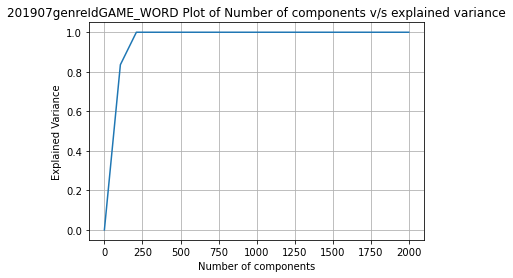

 15%|█▌        | 3/20 [00:00<00:00, 19.00it/s]

FIND OPTIMAL SVD COMPONENTS
201907  --  developer  --  top
Number of components = 0 and explained variance = 0.0
Number of components = 105 and explained variance = 0.5167225781290592
Number of components = 210 and explained variance = 0.7571727337947987


 25%|██▌       | 5/20 [00:00<00:01,  8.89it/s]

Number of components = 316 and explained variance = 0.9099128231777038
Number of components = 421 and explained variance = 0.992404841672012


 35%|███▌      | 7/20 [00:00<00:01,  6.86it/s]

Number of components = 526 and explained variance = 0.9999999999999998
Number of components = 631 and explained variance = 0.9999999999999998


 40%|████      | 8/20 [00:01<00:01,  6.34it/s]

Number of components = 736 and explained variance = 0.9999999999999999


 50%|█████     | 10/20 [00:01<00:01,  5.80it/s]

Number of components = 842 and explained variance = 1.0
Number of components = 947 and explained variance = 1.0


 60%|██████    | 12/20 [00:01<00:01,  5.53it/s]

Number of components = 1052 and explained variance = 0.9999999999999999
Number of components = 1157 and explained variance = 0.9999999999999999


 65%|██████▌   | 13/20 [00:02<00:01,  5.39it/s]

Number of components = 1263 and explained variance = 0.9999999999999999


 70%|███████   | 14/20 [00:02<00:01,  5.10it/s]

Number of components = 1368 and explained variance = 0.9999999999999999


 75%|███████▌  | 15/20 [00:02<00:01,  4.91it/s]

Number of components = 1473 and explained variance = 0.9999999999999999


 80%|████████  | 16/20 [00:02<00:00,  4.87it/s]

Number of components = 1578 and explained variance = 0.9999999999999999


 85%|████████▌ | 17/20 [00:02<00:00,  4.83it/s]

Number of components = 1683 and explained variance = 0.9999999999999997


 90%|█████████ | 18/20 [00:03<00:00,  4.58it/s]

Number of components = 1789 and explained variance = 0.9999999999999998


 95%|█████████▌| 19/20 [00:03<00:00,  4.44it/s]

Number of components = 1894 and explained variance = 1.0


100%|██████████| 20/20 [00:03<00:00,  5.39it/s]

Number of components = 1999 and explained variance = 0.9999999999999998


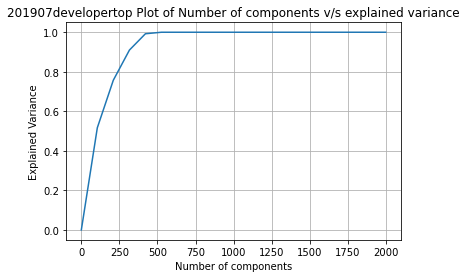

  0%|          | 0/20 [00:00<?, ?it/s]

FIND OPTIMAL SVD COMPONENTS
201907  --  developer  --  non-top


  5%|▌         | 1/20 [00:00<00:11,  1.67it/s]

Number of components = 0 and explained variance = 0.0


 10%|█         | 2/20 [00:01<00:10,  1.76it/s]

Number of components = 105 and explained variance = 0.304577104259166


 15%|█▌        | 3/20 [00:01<00:11,  1.53it/s]

Number of components = 210 and explained variance = 0.4284648354756759


 20%|██        | 4/20 [00:02<00:12,  1.30it/s]

Number of components = 316 and explained variance = 0.51915586119561


 25%|██▌       | 5/20 [00:04<00:13,  1.09it/s]

Number of components = 421 and explained variance = 0.5915146353772692


 30%|███       | 6/20 [00:05<00:16,  1.15s/it]

Number of components = 526 and explained variance = 0.6522001383615611


 35%|███▌      | 7/20 [00:07<00:19,  1.52s/it]

Number of components = 631 and explained variance = 0.7042544586510988


 40%|████      | 8/20 [00:10<00:21,  1.76s/it]

Number of components = 736 and explained variance = 0.74944960355504


 45%|████▌     | 9/20 [00:12<00:21,  1.94s/it]

Number of components = 842 and explained variance = 0.7894610069741675


 50%|█████     | 10/20 [00:15<00:23,  2.33s/it]

Number of components = 947 and explained variance = 0.824230159666107


 55%|█████▌    | 11/20 [00:18<00:23,  2.61s/it]

Number of components = 1052 and explained variance = 0.8547866429800424


 60%|██████    | 12/20 [00:22<00:23,  2.88s/it]

Number of components = 1157 and explained variance = 0.8816167606944157


 65%|██████▌   | 13/20 [00:26<00:22,  3.23s/it]

Number of components = 1263 and explained variance = 0.9053946289264733


 70%|███████   | 14/20 [00:30<00:21,  3.59s/it]

Number of components = 1368 and explained variance = 0.9259907386143513


 75%|███████▌  | 15/20 [00:35<00:20,  4.01s/it]

Number of components = 1473 and explained variance = 0.9439422326193648


 80%|████████  | 16/20 [00:41<00:17,  4.38s/it]

Number of components = 1578 and explained variance = 0.9594880114322004


 85%|████████▌ | 17/20 [00:46<00:13,  4.54s/it]

Number of components = 1683 and explained variance = 0.9727858820432158


 90%|█████████ | 18/20 [00:51<00:09,  4.75s/it]

Number of components = 1789 and explained variance = 0.9840691347602679


 95%|█████████▌| 19/20 [00:56<00:04,  4.98s/it]

Number of components = 1894 and explained variance = 0.9932313135038815


100%|██████████| 20/20 [01:02<00:00,  3.13s/it]

Number of components = 1999 and explained variance = 0.9999903667063865


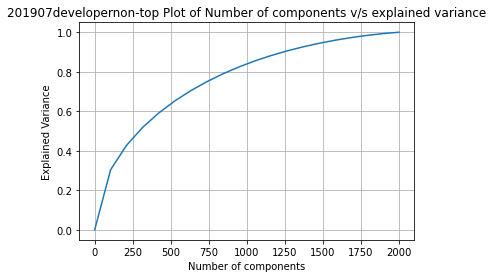

In [8]:
%run -i 'STEP4_NLP_pipeline.py'

# since this code takes too long, I will just run 201907 dataset here
d1 = nlp_pipeline(
          tcn='description',
          initial_panel=test_initial_panel,
          all_panels=test_all_panels
    ).open_divided_df(
    ).generate_save_input_text_col(
    ).tf_idf_transformation(
    ).find_optimal_svd_component_plot()

## 6.2 Find Optimal Number of Clusters (elbow method and silhouette score)

TF-IDF TRANSFORMATION
201907  --  full  --  full
(9405, 2000)
TF-IDF TRANSFORMATION
201907  --  minInstalls  --  ImputedminInstalls_tier1
(1800, 2000)
TF-IDF TRANSFORMATION
201907  --  minInstalls  --  ImputedminInstalls_tier2
(4231, 2000)
TF-IDF TRANSFORMATION
201907  --  minInstalls  --  ImputedminInstalls_tier3
(3374, 2000)
TF-IDF TRANSFORMATION
201907  --  genreId  --  ART_AND_DESIGN
(167, 2000)
TF-IDF TRANSFORMATION
201907  --  genreId  --  COMICS
(83, 2000)
TF-IDF TRANSFORMATION
201907  --  genreId  --  PERSONALIZATION
(274, 2000)
TF-IDF TRANSFORMATION
201907  --  genreId  --  PHOTOGRAPHY
(208, 2000)
TF-IDF TRANSFORMATION
201907  --  genreId  --  AUTO_AND_VEHICLES
(171, 2000)
TF-IDF TRANSFORMATION
201907  --  genreId  --  GAME_ROLE_PLAYING
(262, 2000)
TF-IDF TRANSFORMATION
201907  --  genreId  --  GAME_ACTION
(22, 1736)
TF-IDF TRANSFORMATION
201907  --  genreId  --  GAME_RACING
(188, 2000)
TF-IDF TRANSFORMATION
201907  --  genreId  --  TRAVEL_AND_LOCAL
(214, 2000)
TF-IDF TRANSFOR

  0%|          | 0/10 [00:00<?, ?it/s]

(8957, 1200)
ELBOW METHOD TO FIND OPTIMAL KM CLUSTERS
201907  --  full  --  full


100%|██████████| 10/10 [32:23<00:00, 194.36s/it]


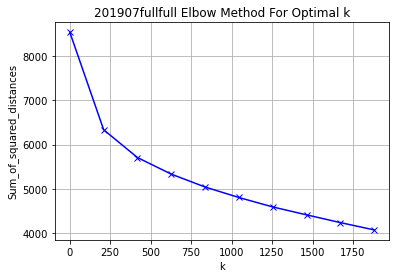

  0%|          | 0/10 [00:00<?, ?it/s]

ELBOW METHOD TO FIND OPTIMAL KM CLUSTERS
201907  --  minInstalls  --  ImputedminInstalls_tier1


100%|██████████| 10/10 [00:30<00:00,  3.05s/it]


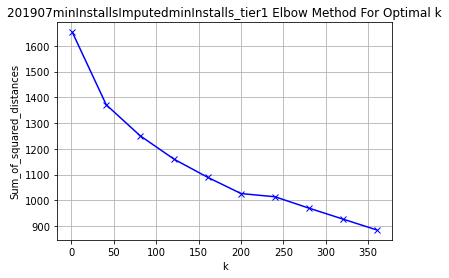

 10%|█         | 1/10 [00:00<00:01,  7.13it/s]

ELBOW METHOD TO FIND OPTIMAL KM CLUSTERS
201907  --  minInstalls  --  ImputedminInstalls_tier2


100%|██████████| 10/10 [03:58<00:00, 23.88s/it]


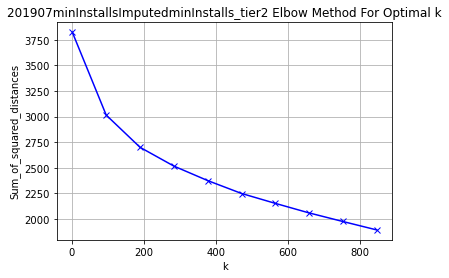

 10%|█         | 1/10 [00:00<00:01,  8.03it/s]

ELBOW METHOD TO FIND OPTIMAL KM CLUSTERS
201907  --  minInstalls  --  ImputedminInstalls_tier3


100%|██████████| 10/10 [02:35<00:00, 15.55s/it]


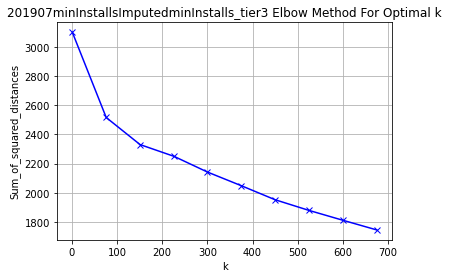

 40%|████      | 4/10 [00:00<00:00, 36.96it/s]

ELBOW METHOD TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  ART_AND_DESIGN


100%|██████████| 10/10 [00:00<00:00, 22.46it/s]


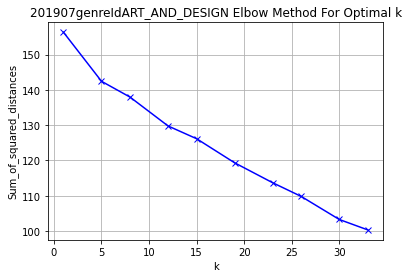

 60%|██████    | 6/10 [00:00<00:00, 59.20it/s]

ELBOW METHOD TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  COMICS


100%|██████████| 10/10 [00:00<00:00, 45.41it/s]


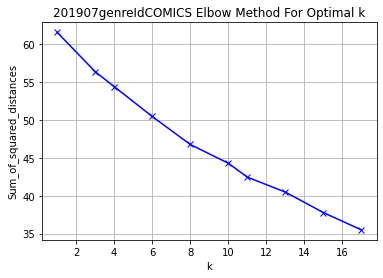

 40%|████      | 4/10 [00:00<00:00, 26.36it/s]

ELBOW METHOD TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  PERSONALIZATION


100%|██████████| 10/10 [00:00<00:00, 12.70it/s]


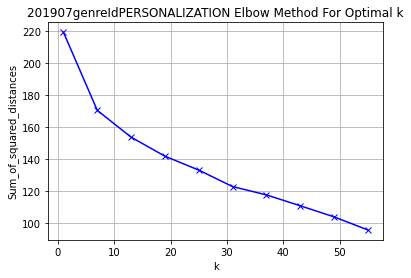

 40%|████      | 4/10 [00:00<00:00, 36.70it/s]

ELBOW METHOD TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  PHOTOGRAPHY


100%|██████████| 10/10 [00:00<00:00, 18.53it/s]


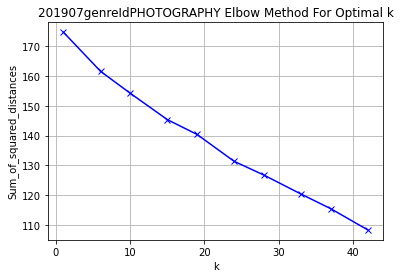

 50%|█████     | 5/10 [00:00<00:00, 37.47it/s]

ELBOW METHOD TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  AUTO_AND_VEHICLES


100%|██████████| 10/10 [00:00<00:00, 21.66it/s]


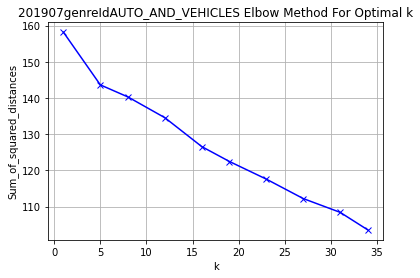

 40%|████      | 4/10 [00:00<00:00, 27.73it/s]

ELBOW METHOD TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  GAME_ROLE_PLAYING


100%|██████████| 10/10 [00:00<00:00, 13.21it/s]


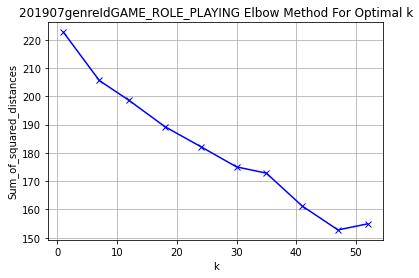

100%|██████████| 10/10 [00:00<00:00, 92.89it/s]

ELBOW METHOD TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  GAME_ACTION


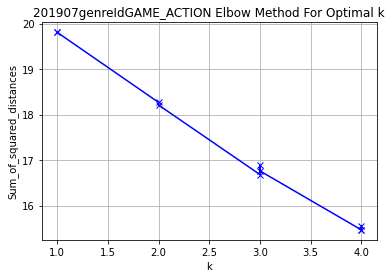

 40%|████      | 4/10 [00:00<00:00, 39.08it/s]

ELBOW METHOD TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  GAME_RACING


100%|██████████| 10/10 [00:00<00:00, 19.63it/s]


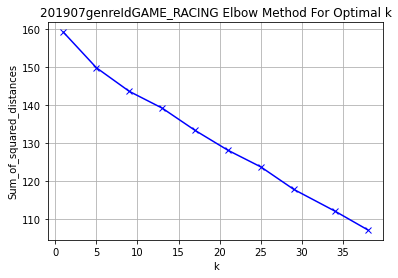

 40%|████      | 4/10 [00:00<00:00, 32.36it/s]

ELBOW METHOD TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  TRAVEL_AND_LOCAL


100%|██████████| 10/10 [00:00<00:00, 16.60it/s]


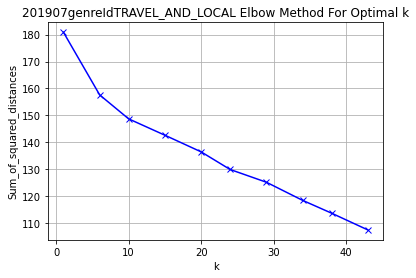

 40%|████      | 4/10 [00:00<00:00, 29.59it/s]

ELBOW METHOD TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  GAME_ADVENTURE


100%|██████████| 10/10 [00:00<00:00, 16.21it/s]


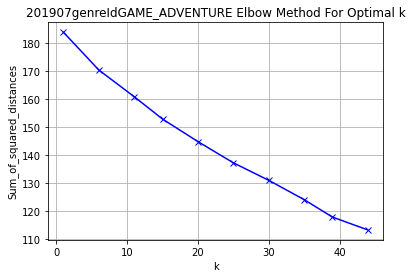

 50%|█████     | 5/10 [00:00<00:00, 45.64it/s]

ELBOW METHOD TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  SOCIAL


100%|██████████| 10/10 [00:00<00:00, 27.22it/s]


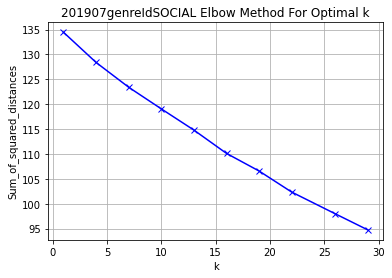

 40%|████      | 4/10 [00:00<00:00, 27.82it/s]

ELBOW METHOD TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  GAME_SIMULATION


100%|██████████| 10/10 [00:00<00:00, 12.85it/s]


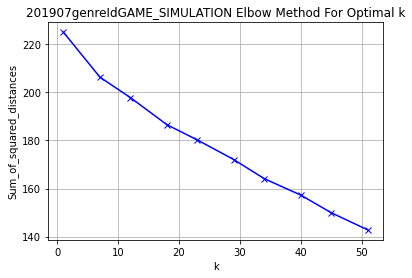

 40%|████      | 4/10 [00:00<00:00, 35.21it/s]

ELBOW METHOD TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  LIFESTYLE


100%|██████████| 10/10 [00:00<00:00, 17.44it/s]


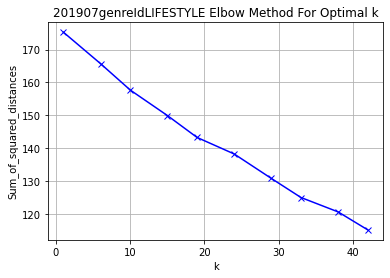

 40%|████      | 4/10 [00:00<00:00, 24.83it/s]

ELBOW METHOD TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  EDUCATION


100%|██████████| 10/10 [00:00<00:00, 12.44it/s]


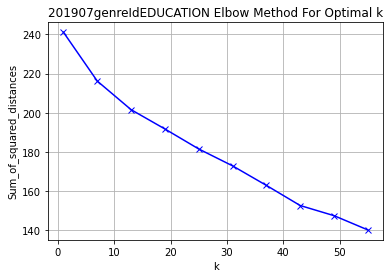

 60%|██████    | 6/10 [00:00<00:00, 56.44it/s]

ELBOW METHOD TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  BEAUTY


100%|██████████| 10/10 [00:00<00:00, 43.54it/s]


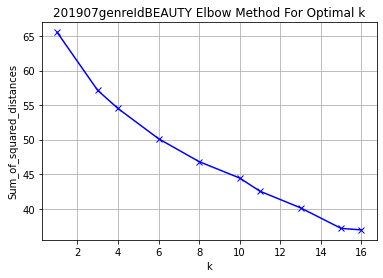

 40%|████      | 4/10 [00:00<00:00, 30.41it/s]

ELBOW METHOD TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  GAME_CASUAL


100%|██████████| 10/10 [00:00<00:00, 15.02it/s]


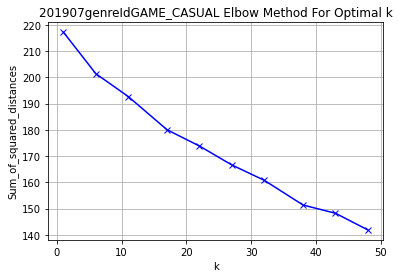

 40%|████      | 4/10 [00:00<00:00, 36.82it/s]

ELBOW METHOD TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  BOOKS_AND_REFERENCE


100%|██████████| 10/10 [00:00<00:00, 18.31it/s]


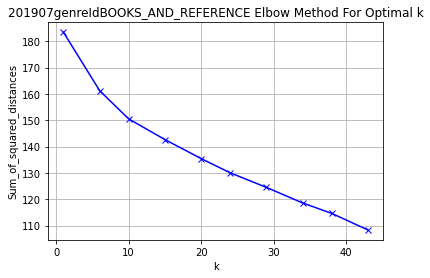

 40%|████      | 4/10 [00:00<00:00, 25.72it/s]

ELBOW METHOD TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  BUSINESS


100%|██████████| 10/10 [00:00<00:00, 13.68it/s]


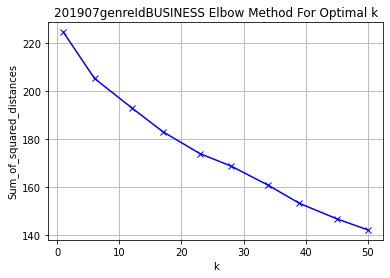

 40%|████      | 4/10 [00:00<00:00, 28.63it/s]

ELBOW METHOD TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  FINANCE


100%|██████████| 10/10 [00:00<00:00, 13.99it/s]


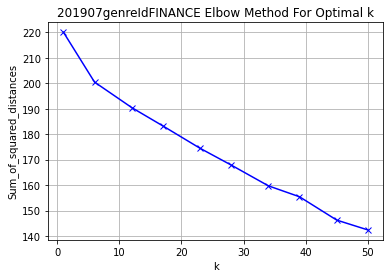

 40%|████      | 4/10 [00:00<00:00, 34.28it/s]

ELBOW METHOD TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  GAME_STRATEGY


100%|██████████| 10/10 [00:00<00:00, 16.94it/s]


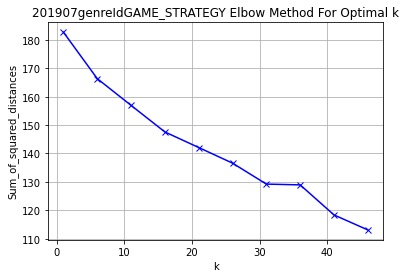

 40%|████      | 4/10 [00:00<00:00, 27.72it/s]

ELBOW METHOD TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  SPORTS


100%|██████████| 10/10 [00:00<00:00, 15.03it/s]


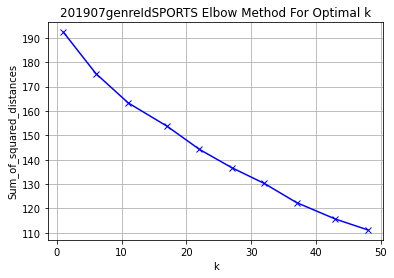

 40%|████      | 4/10 [00:00<00:00, 30.43it/s]

ELBOW METHOD TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  COMMUNICATION


100%|██████████| 10/10 [00:00<00:00, 16.83it/s]


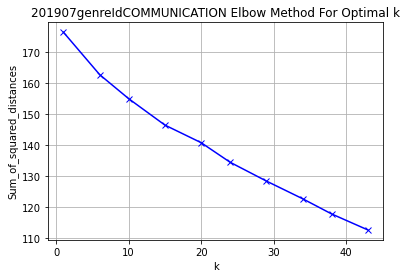

 60%|██████    | 6/10 [00:00<00:00, 51.40it/s]

ELBOW METHOD TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  DATING


100%|██████████| 10/10 [00:00<00:00, 37.53it/s]


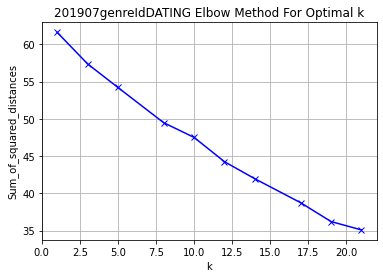

 40%|████      | 4/10 [00:00<00:00, 33.41it/s]

ELBOW METHOD TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  ENTERTAINMENT


100%|██████████| 10/10 [00:00<00:00, 16.32it/s]


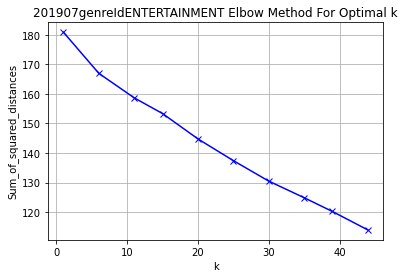

 40%|████      | 4/10 [00:00<00:00, 33.00it/s]

ELBOW METHOD TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  GAME_BOARD


100%|██████████| 10/10 [00:00<00:00, 17.19it/s]


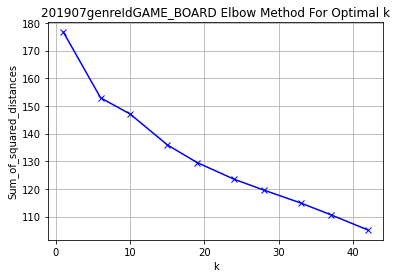

 60%|██████    | 6/10 [00:00<00:00, 59.15it/s]

ELBOW METHOD TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  EVENTS


100%|██████████| 10/10 [00:00<00:00, 44.27it/s]


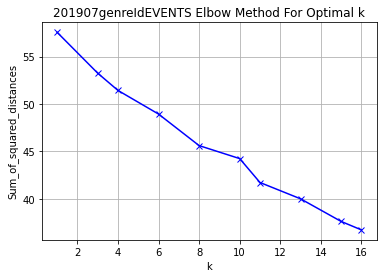

 50%|█████     | 5/10 [00:00<00:00, 45.64it/s]

ELBOW METHOD TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  SHOPPING


100%|██████████| 10/10 [00:00<00:00, 27.50it/s]


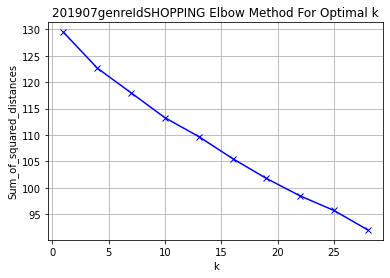

 40%|████      | 4/10 [00:00<00:00, 37.17it/s]

ELBOW METHOD TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  FOOD_AND_DRINK


100%|██████████| 10/10 [00:00<00:00, 17.17it/s]


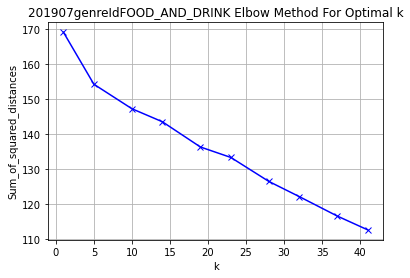

 30%|███       | 3/10 [00:00<00:00, 28.71it/s]

ELBOW METHOD TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  HEALTH_AND_FITNESS


100%|██████████| 10/10 [00:00<00:00, 13.29it/s]


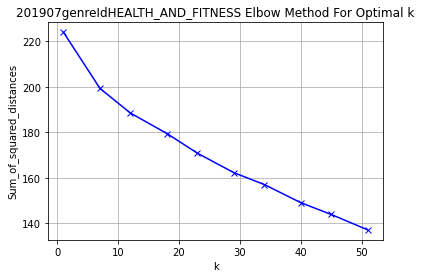

 50%|█████     | 5/10 [00:00<00:00, 43.95it/s]

ELBOW METHOD TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  HOUSE_AND_HOME


100%|██████████| 10/10 [00:00<00:00, 30.87it/s]


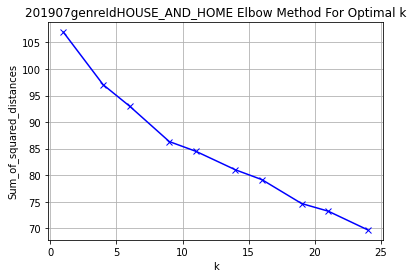

 40%|████      | 4/10 [00:00<00:00, 31.07it/s]

ELBOW METHOD TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  TOOLS


100%|██████████| 10/10 [00:00<00:00, 16.46it/s]


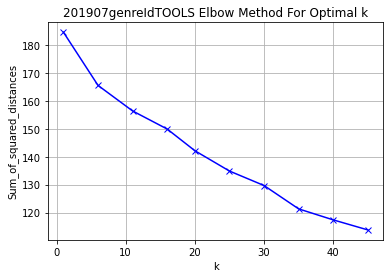

 60%|██████    | 6/10 [00:00<00:00, 52.86it/s]

ELBOW METHOD TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  LIBRARIES_AND_DEMO


100%|██████████| 10/10 [00:00<00:00, 39.20it/s]


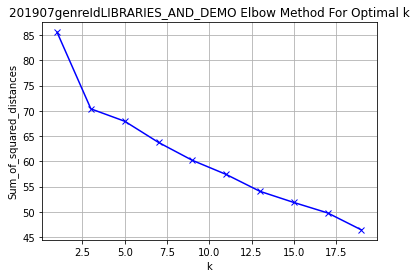

 40%|████      | 4/10 [00:00<00:00, 34.24it/s]

ELBOW METHOD TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  MAPS_AND_NAVIGATION


100%|██████████| 10/10 [00:00<00:00, 16.69it/s]


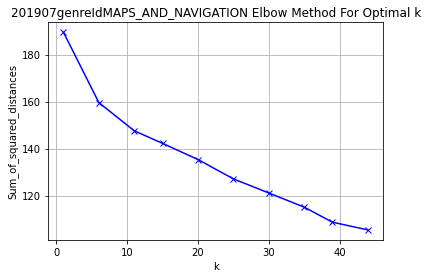

 40%|████      | 4/10 [00:00<00:00, 25.63it/s]

ELBOW METHOD TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  MEDICAL


100%|██████████| 10/10 [00:00<00:00, 13.72it/s]


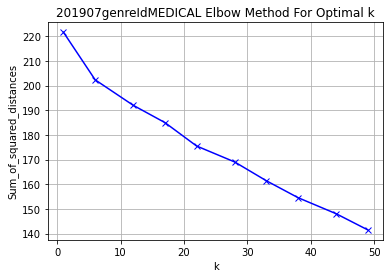

 40%|████      | 4/10 [00:00<00:00, 31.94it/s]

ELBOW METHOD TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  MUSIC_AND_AUDIO


100%|██████████| 10/10 [00:00<00:00, 16.24it/s]


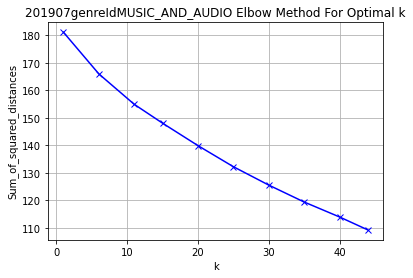

 40%|████      | 4/10 [00:00<00:00, 34.03it/s]

ELBOW METHOD TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  NEWS_AND_MAGAZINES


100%|██████████| 10/10 [00:00<00:00, 20.34it/s]


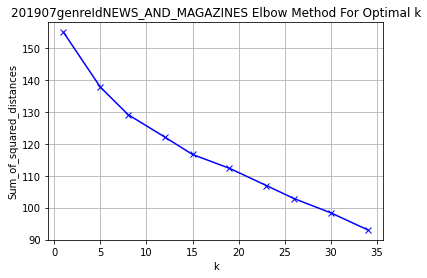

 50%|█████     | 5/10 [00:00<00:00, 49.03it/s]

ELBOW METHOD TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  PARENTING


100%|██████████| 10/10 [00:00<00:00, 31.16it/s]


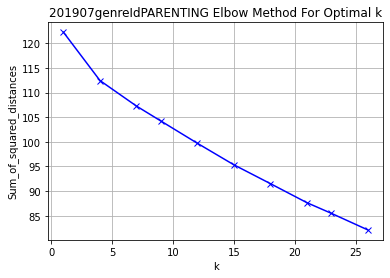

 40%|████      | 4/10 [00:00<00:00, 26.41it/s]

ELBOW METHOD TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  GAME_PUZZLE


100%|██████████| 10/10 [00:00<00:00, 12.30it/s]


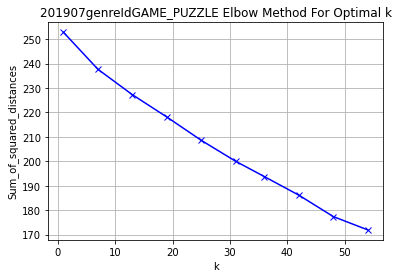

 40%|████      | 4/10 [00:00<00:00, 39.25it/s]

ELBOW METHOD TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  VIDEO_PLAYERS


100%|██████████| 10/10 [00:00<00:00, 19.51it/s]


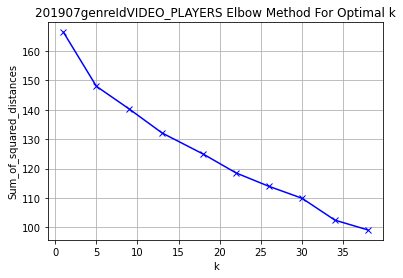

 40%|████      | 4/10 [00:00<00:00, 33.91it/s]

ELBOW METHOD TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  PRODUCTIVITY


100%|██████████| 10/10 [00:00<00:00, 17.24it/s]


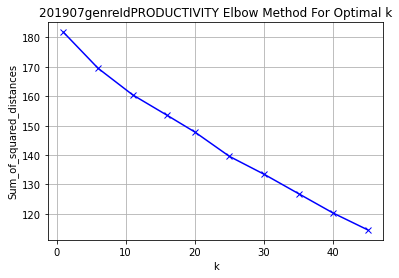

 40%|████      | 4/10 [00:00<00:00, 33.81it/s]

ELBOW METHOD TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  WEATHER


100%|██████████| 10/10 [00:00<00:00, 16.58it/s]


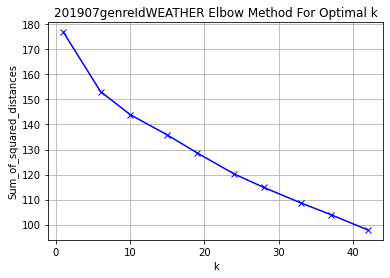

 40%|████      | 4/10 [00:00<00:00, 34.36it/s]

ELBOW METHOD TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  GAME_ARCADE


100%|██████████| 10/10 [00:00<00:00, 15.59it/s]


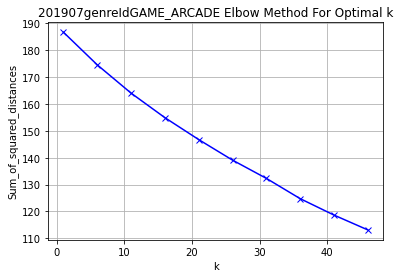

 50%|█████     | 5/10 [00:00<00:00, 48.23it/s]

ELBOW METHOD TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  GAME_CASINO


100%|██████████| 10/10 [00:00<00:00, 31.75it/s]


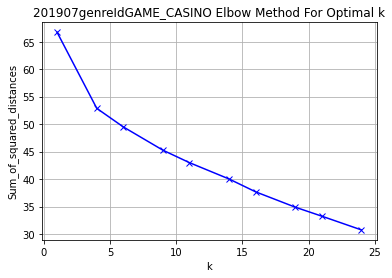

 40%|████      | 4/10 [00:00<00:00, 33.00it/s]

ELBOW METHOD TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  GAME_CARD


100%|██████████| 10/10 [00:00<00:00, 16.08it/s]


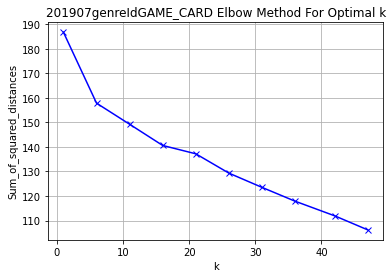

 40%|████      | 4/10 [00:00<00:00, 29.97it/s]

ELBOW METHOD TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  GAME_EDUCATIONAL


100%|██████████| 10/10 [00:00<00:00, 15.18it/s]


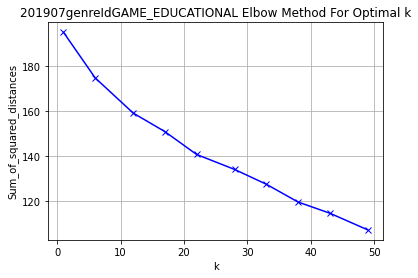

 50%|█████     | 5/10 [00:00<00:00, 48.25it/s]

ELBOW METHOD TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  GAME_MUSIC


100%|██████████| 10/10 [00:00<00:00, 33.08it/s]


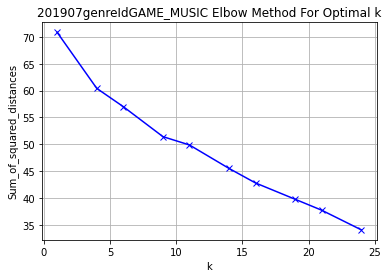

 40%|████      | 4/10 [00:00<00:00, 34.23it/s]

ELBOW METHOD TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  GAME_SPORTS


100%|██████████| 10/10 [00:00<00:00, 17.50it/s]


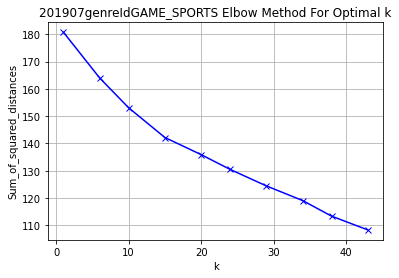

 50%|█████     | 5/10 [00:00<00:00, 49.32it/s]

ELBOW METHOD TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  GAME_TRIVIA


100%|██████████| 10/10 [00:00<00:00, 30.63it/s]


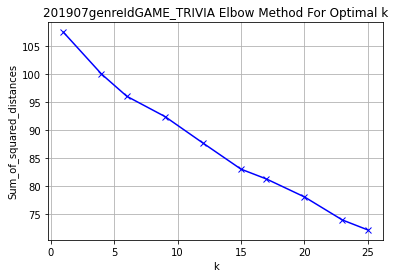

 50%|█████     | 5/10 [00:00<00:00, 39.80it/s]

ELBOW METHOD TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  GAME_WORD


100%|██████████| 10/10 [00:00<00:00, 23.78it/s]


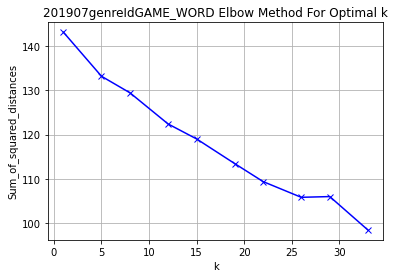

 30%|███       | 3/10 [00:00<00:00, 16.63it/s]

ELBOW METHOD TO FIND OPTIMAL KM CLUSTERS
201907  --  developer  --  top


100%|██████████| 10/10 [00:01<00:00,  6.24it/s]


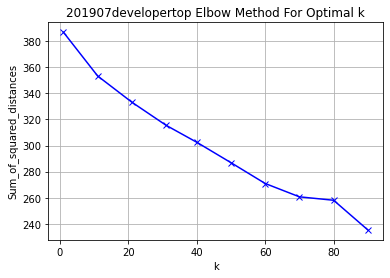

  0%|          | 0/10 [00:00<?, ?it/s]

ELBOW METHOD TO FIND OPTIMAL KM CLUSTERS
201907  --  developer  --  non-top


100%|██████████| 10/10 [21:15<00:00, 127.60s/it]


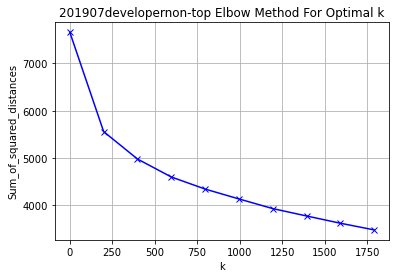

  0%|          | 0/10 [00:00<?, ?it/s]

SILHOUETTE SCORE TO FIND OPTIMAL KM CLUSTERS
201907  --  full  --  full


100%|██████████| 10/10 [32:37<00:00, 195.80s/it]


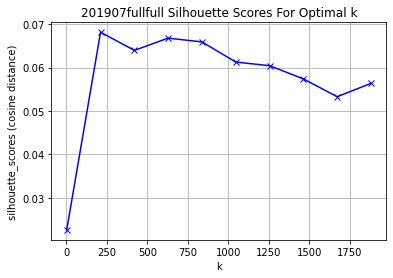

 10%|█         | 1/10 [00:00<00:01,  5.95it/s]

SILHOUETTE SCORE TO FIND OPTIMAL KM CLUSTERS
201907  --  minInstalls  --  ImputedminInstalls_tier1


100%|██████████| 10/10 [00:36<00:00,  3.67s/it]


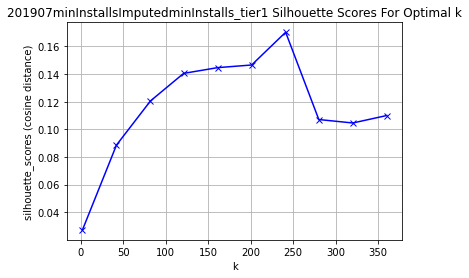

  0%|          | 0/10 [00:00<?, ?it/s]

SILHOUETTE SCORE TO FIND OPTIMAL KM CLUSTERS
201907  --  minInstalls  --  ImputedminInstalls_tier2


100%|██████████| 10/10 [04:13<00:00, 25.31s/it]


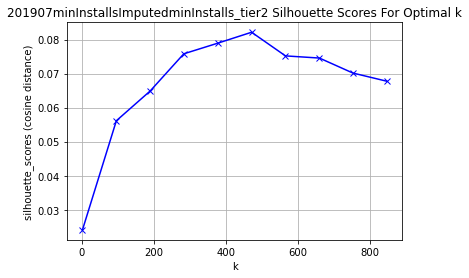

  0%|          | 0/10 [00:00<?, ?it/s]

SILHOUETTE SCORE TO FIND OPTIMAL KM CLUSTERS
201907  --  minInstalls  --  ImputedminInstalls_tier3


100%|██████████| 10/10 [02:46<00:00, 16.61s/it]


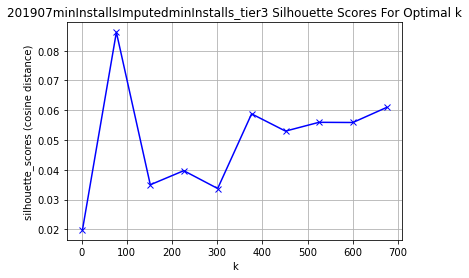

 40%|████      | 4/10 [00:00<00:00, 37.21it/s]

SILHOUETTE SCORE TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  ART_AND_DESIGN


100%|██████████| 10/10 [00:00<00:00, 21.40it/s]


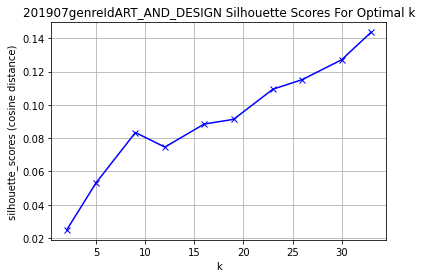

 60%|██████    | 6/10 [00:00<00:00, 48.51it/s]

SILHOUETTE SCORE TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  COMICS


100%|██████████| 10/10 [00:00<00:00, 35.89it/s]


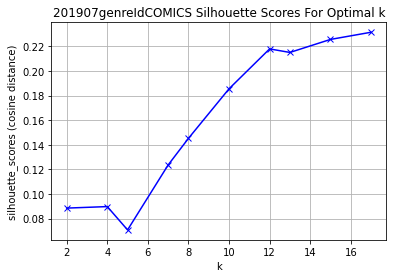

 30%|███       | 3/10 [00:00<00:00, 29.12it/s]

SILHOUETTE SCORE TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  PERSONALIZATION


100%|██████████| 10/10 [00:00<00:00, 11.44it/s]


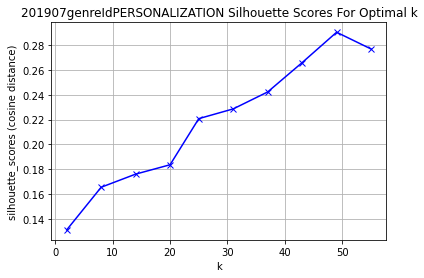

 40%|████      | 4/10 [00:00<00:00, 31.16it/s]

SILHOUETTE SCORE TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  PHOTOGRAPHY


100%|██████████| 10/10 [00:00<00:00, 16.27it/s]


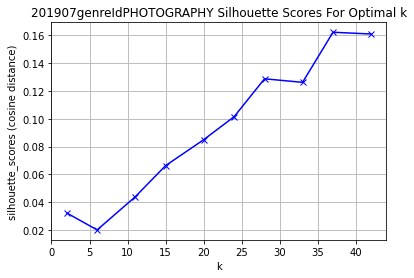

 40%|████      | 4/10 [00:00<00:00, 32.71it/s]

SILHOUETTE SCORE TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  AUTO_AND_VEHICLES


100%|██████████| 10/10 [00:00<00:00, 19.62it/s]


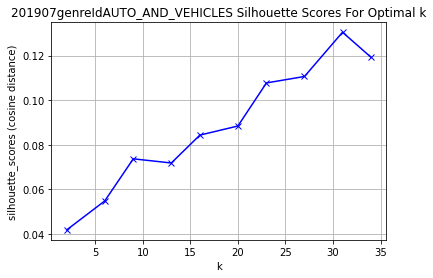

 30%|███       | 3/10 [00:00<00:00, 29.73it/s]

SILHOUETTE SCORE TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  GAME_ROLE_PLAYING


100%|██████████| 10/10 [00:00<00:00, 12.22it/s]


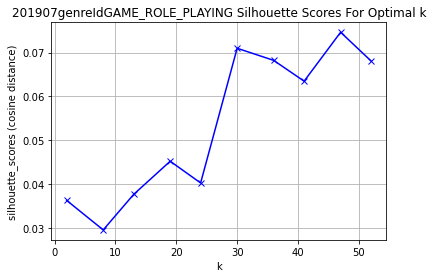

100%|██████████| 10/10 [00:00<00:00, 96.84it/s]

SILHOUETTE SCORE TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  GAME_ACTION


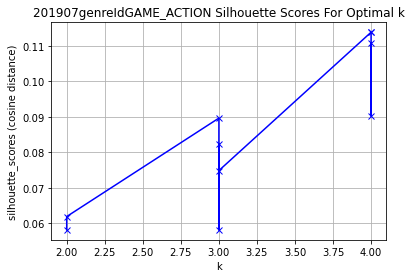

 40%|████      | 4/10 [00:00<00:00, 33.69it/s]

SILHOUETTE SCORE TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  GAME_RACING


100%|██████████| 10/10 [00:00<00:00, 15.91it/s]


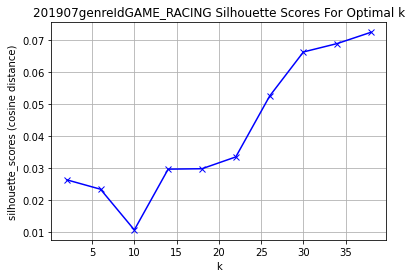

 30%|███       | 3/10 [00:00<00:00, 29.87it/s]

SILHOUETTE SCORE TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  TRAVEL_AND_LOCAL


100%|██████████| 10/10 [00:00<00:00, 13.90it/s]


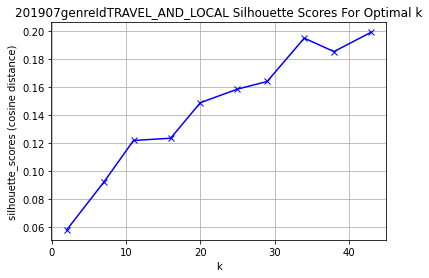

 40%|████      | 4/10 [00:00<00:00, 28.06it/s]

SILHOUETTE SCORE TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  GAME_ADVENTURE


100%|██████████| 10/10 [00:00<00:00, 14.89it/s]


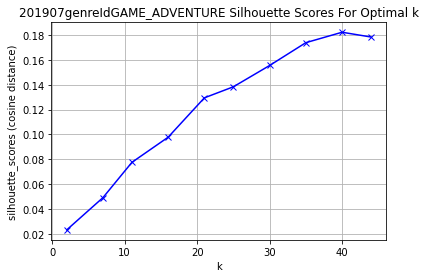

 40%|████      | 4/10 [00:00<00:00, 37.02it/s]

SILHOUETTE SCORE TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  SOCIAL


100%|██████████| 10/10 [00:00<00:00, 23.17it/s]


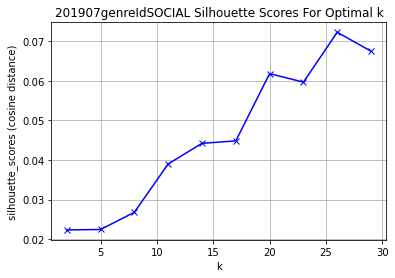

 30%|███       | 3/10 [00:00<00:00, 26.59it/s]

SILHOUETTE SCORE TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  GAME_SIMULATION


100%|██████████| 10/10 [00:00<00:00, 12.19it/s]


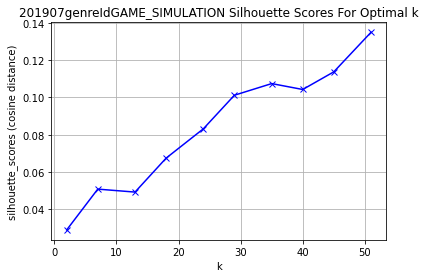

 40%|████      | 4/10 [00:00<00:00, 26.69it/s]

SILHOUETTE SCORE TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  LIFESTYLE


100%|██████████| 10/10 [00:00<00:00, 14.32it/s]


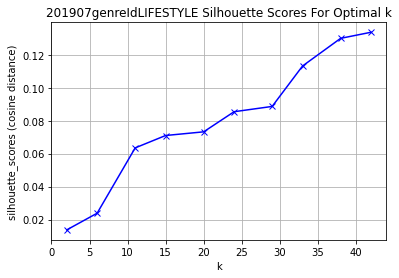

 30%|███       | 3/10 [00:00<00:00, 21.47it/s]

SILHOUETTE SCORE TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  EDUCATION


100%|██████████| 10/10 [00:00<00:00, 10.84it/s]


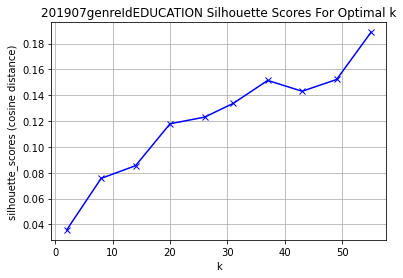

 60%|██████    | 6/10 [00:00<00:00, 47.72it/s]

SILHOUETTE SCORE TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  BEAUTY


100%|██████████| 10/10 [00:00<00:00, 37.67it/s]


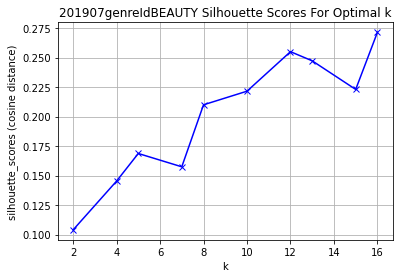

 30%|███       | 3/10 [00:00<00:00, 29.71it/s]

SILHOUETTE SCORE TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  GAME_CASUAL


100%|██████████| 10/10 [00:00<00:00, 13.21it/s]


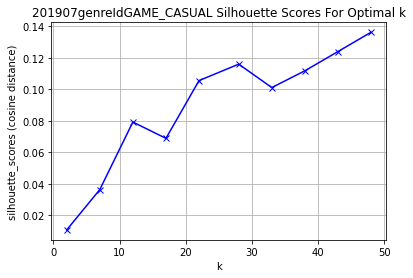

 40%|████      | 4/10 [00:00<00:00, 31.81it/s]

SILHOUETTE SCORE TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  BOOKS_AND_REFERENCE


100%|██████████| 10/10 [00:00<00:00, 15.98it/s]


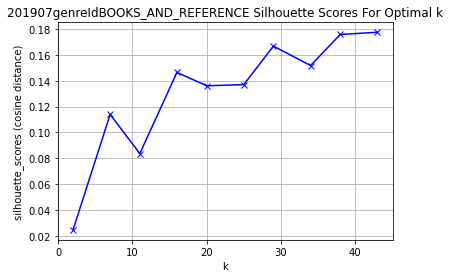

 30%|███       | 3/10 [00:00<00:00, 24.43it/s]

SILHOUETTE SCORE TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  BUSINESS


100%|██████████| 10/10 [00:00<00:00, 12.43it/s]


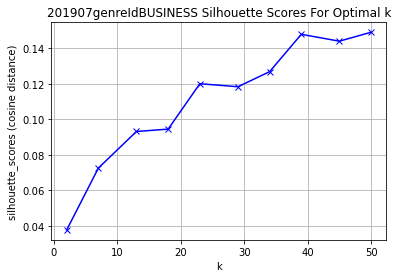

 30%|███       | 3/10 [00:00<00:00, 28.86it/s]

SILHOUETTE SCORE TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  FINANCE


100%|██████████| 10/10 [00:00<00:00, 12.78it/s]


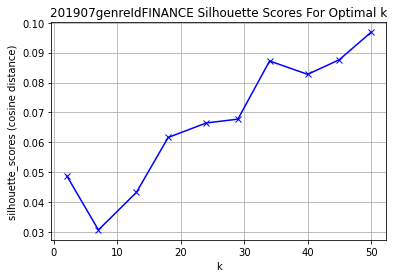

 40%|████      | 4/10 [00:00<00:00, 27.31it/s]

SILHOUETTE SCORE TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  GAME_STRATEGY


100%|██████████| 10/10 [00:00<00:00, 15.03it/s]


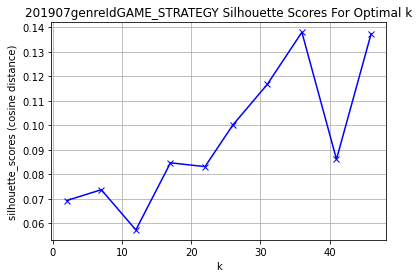

 30%|███       | 3/10 [00:00<00:00, 25.89it/s]

SILHOUETTE SCORE TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  SPORTS


100%|██████████| 10/10 [00:00<00:00, 13.23it/s]


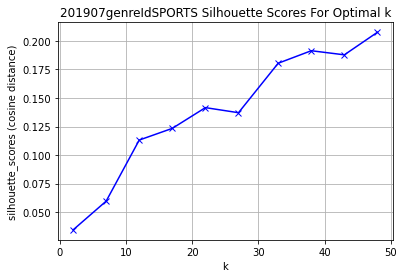

 40%|████      | 4/10 [00:00<00:00, 27.63it/s]

SILHOUETTE SCORE TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  COMMUNICATION


100%|██████████| 10/10 [00:00<00:00, 15.78it/s]


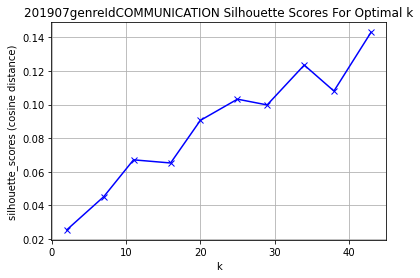

 50%|█████     | 5/10 [00:00<00:00, 49.81it/s]

SILHOUETTE SCORE TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  DATING


100%|██████████| 10/10 [00:00<00:00, 33.53it/s]


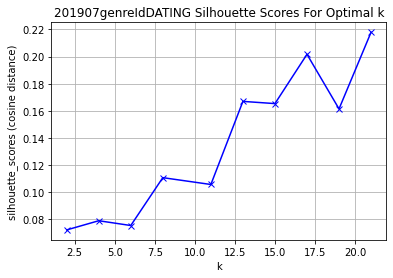

 40%|████      | 4/10 [00:00<00:00, 29.09it/s]

SILHOUETTE SCORE TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  ENTERTAINMENT


100%|██████████| 10/10 [00:00<00:00, 15.46it/s]


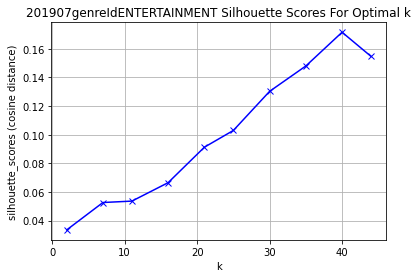

 40%|████      | 4/10 [00:00<00:00, 28.62it/s]

SILHOUETTE SCORE TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  GAME_BOARD


100%|██████████| 10/10 [00:00<00:00, 14.82it/s]


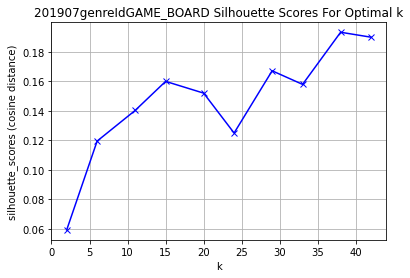

 50%|█████     | 5/10 [00:00<00:00, 48.48it/s]

SILHOUETTE SCORE TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  EVENTS


100%|██████████| 10/10 [00:00<00:00, 34.69it/s]


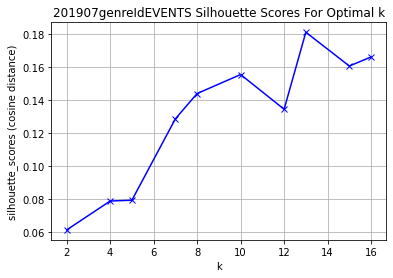

 50%|█████     | 5/10 [00:00<00:00, 37.58it/s]

SILHOUETTE SCORE TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  SHOPPING


100%|██████████| 10/10 [00:00<00:00, 24.49it/s]


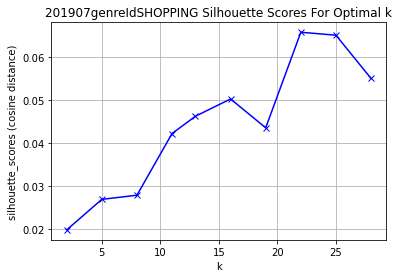

 40%|████      | 4/10 [00:00<00:00, 28.75it/s]

SILHOUETTE SCORE TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  FOOD_AND_DRINK


100%|██████████| 10/10 [00:00<00:00, 15.04it/s]


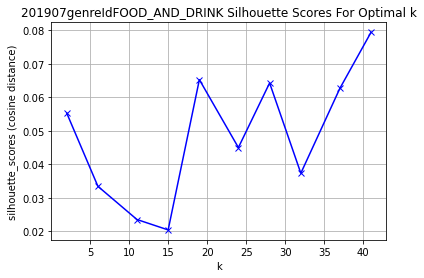

 30%|███       | 3/10 [00:00<00:00, 27.20it/s]

SILHOUETTE SCORE TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  HEALTH_AND_FITNESS


100%|██████████| 10/10 [00:00<00:00, 12.38it/s]


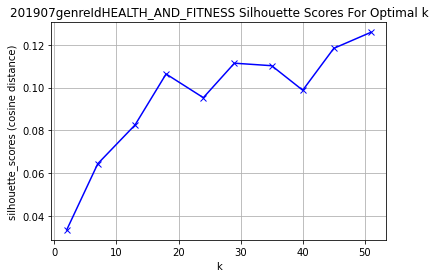

 50%|█████     | 5/10 [00:00<00:00, 43.48it/s]

SILHOUETTE SCORE TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  HOUSE_AND_HOME


100%|██████████| 10/10 [00:00<00:00, 28.88it/s]


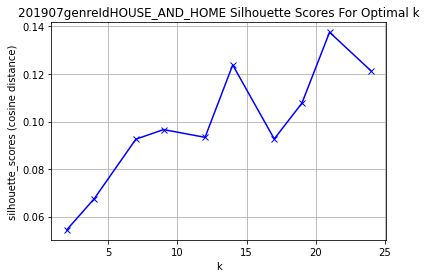

 30%|███       | 3/10 [00:00<00:00, 29.29it/s]

SILHOUETTE SCORE TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  TOOLS


100%|██████████| 10/10 [00:00<00:00, 15.47it/s]


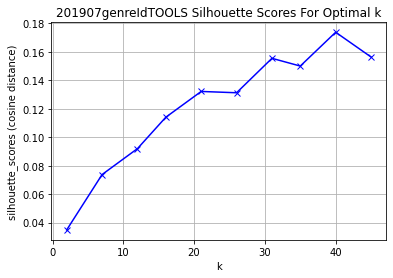

 50%|█████     | 5/10 [00:00<00:00, 49.78it/s]

SILHOUETTE SCORE TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  LIBRARIES_AND_DEMO


100%|██████████| 10/10 [00:00<00:00, 35.96it/s]


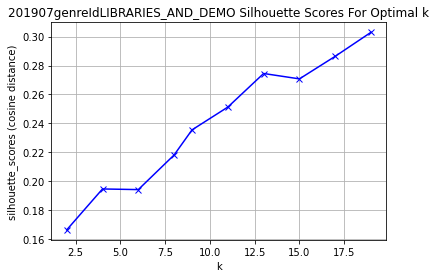

 40%|████      | 4/10 [00:00<00:00, 31.66it/s]

SILHOUETTE SCORE TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  MAPS_AND_NAVIGATION


100%|██████████| 10/10 [00:00<00:00, 15.98it/s]


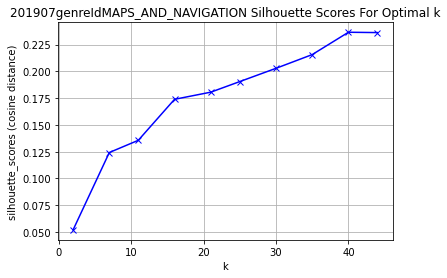

 30%|███       | 3/10 [00:00<00:00, 29.03it/s]

SILHOUETTE SCORE TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  MEDICAL


100%|██████████| 10/10 [00:00<00:00, 13.33it/s]


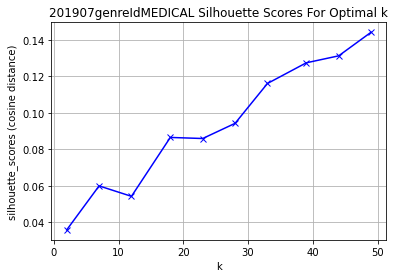

 40%|████      | 4/10 [00:00<00:00, 28.57it/s]

SILHOUETTE SCORE TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  MUSIC_AND_AUDIO


100%|██████████| 10/10 [00:00<00:00, 14.83it/s]


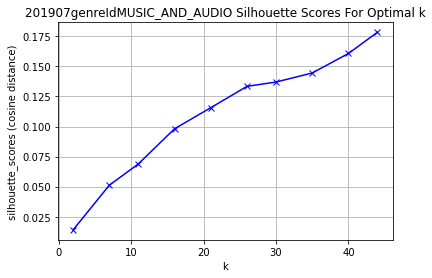

 40%|████      | 4/10 [00:00<00:00, 32.58it/s]

SILHOUETTE SCORE TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  NEWS_AND_MAGAZINES


100%|██████████| 10/10 [00:00<00:00, 17.30it/s]


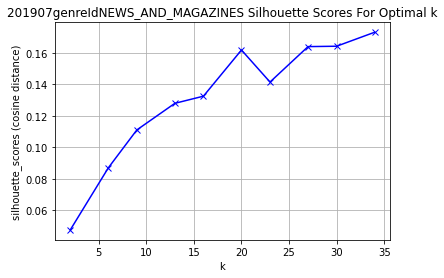

 40%|████      | 4/10 [00:00<00:00, 39.39it/s]

SILHOUETTE SCORE TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  PARENTING


100%|██████████| 10/10 [00:00<00:00, 23.59it/s]


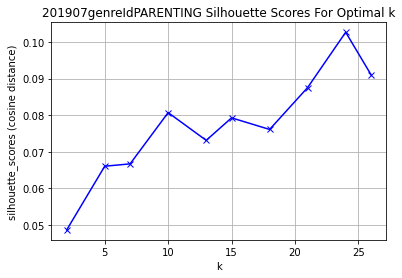

 30%|███       | 3/10 [00:00<00:00, 22.24it/s]

SILHOUETTE SCORE TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  GAME_PUZZLE


100%|██████████| 10/10 [00:00<00:00, 10.85it/s]


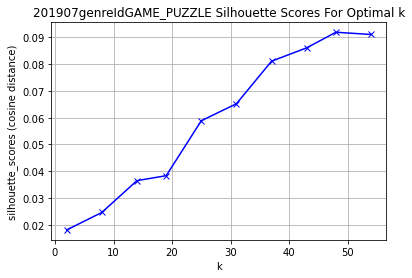

 40%|████      | 4/10 [00:00<00:00, 32.29it/s]

SILHOUETTE SCORE TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  VIDEO_PLAYERS


100%|██████████| 10/10 [00:00<00:00, 17.02it/s]


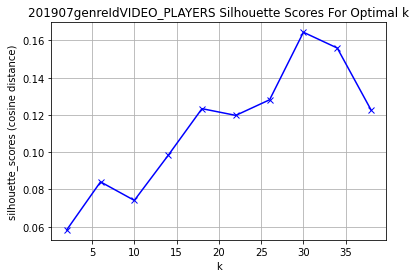

 30%|███       | 3/10 [00:00<00:00, 28.90it/s]

SILHOUETTE SCORE TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  PRODUCTIVITY


100%|██████████| 10/10 [00:00<00:00, 14.54it/s]


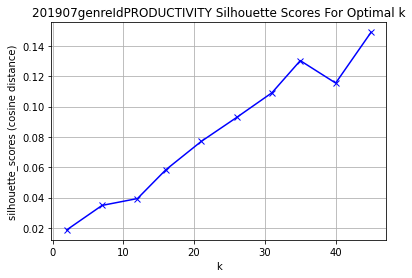

 40%|████      | 4/10 [00:00<00:00, 29.45it/s]

SILHOUETTE SCORE TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  WEATHER


100%|██████████| 10/10 [00:00<00:00, 15.32it/s]


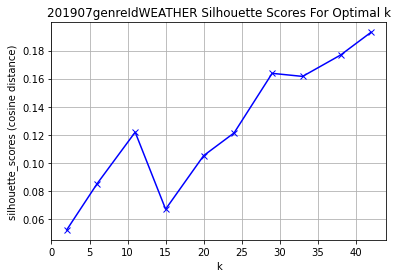

 30%|███       | 3/10 [00:00<00:00, 28.85it/s]

SILHOUETTE SCORE TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  GAME_ARCADE


100%|██████████| 10/10 [00:00<00:00, 14.93it/s]


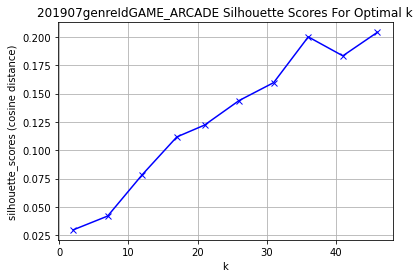

 50%|█████     | 5/10 [00:00<00:00, 44.28it/s]

SILHOUETTE SCORE TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  GAME_CASINO


100%|██████████| 10/10 [00:00<00:00, 28.99it/s]


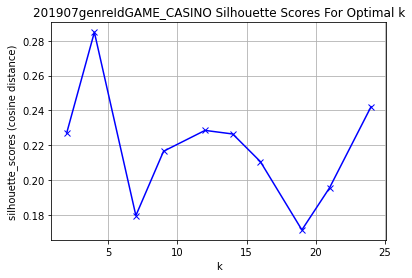

 40%|████      | 4/10 [00:00<00:00, 28.90it/s]

SILHOUETTE SCORE TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  GAME_CARD


100%|██████████| 10/10 [00:00<00:00, 14.87it/s]


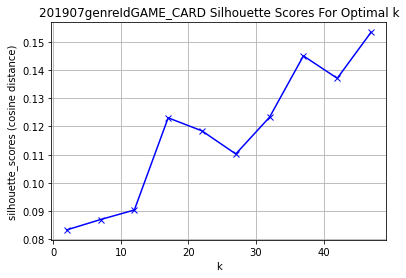

 30%|███       | 3/10 [00:00<00:00, 27.05it/s]

SILHOUETTE SCORE TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  GAME_EDUCATIONAL


100%|██████████| 10/10 [00:00<00:00, 12.49it/s]


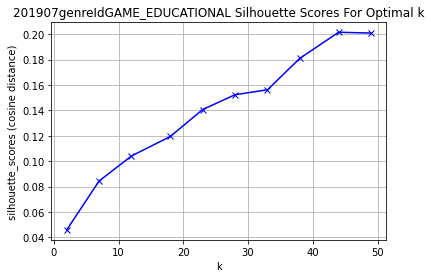

 50%|█████     | 5/10 [00:00<00:00, 41.56it/s]

SILHOUETTE SCORE TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  GAME_MUSIC


100%|██████████| 10/10 [00:00<00:00, 29.28it/s]


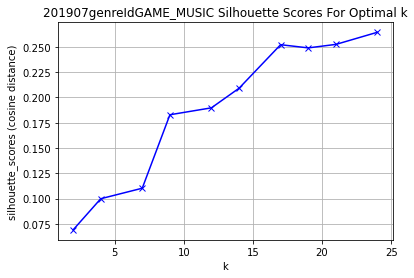

 40%|████      | 4/10 [00:00<00:00, 28.87it/s]

SILHOUETTE SCORE TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  GAME_SPORTS


100%|██████████| 10/10 [00:00<00:00, 15.95it/s]


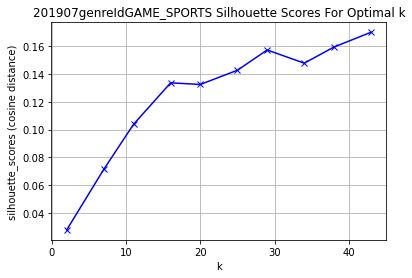

 50%|█████     | 5/10 [00:00<00:00, 40.29it/s]

SILHOUETTE SCORE TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  GAME_TRIVIA


100%|██████████| 10/10 [00:00<00:00, 26.96it/s]


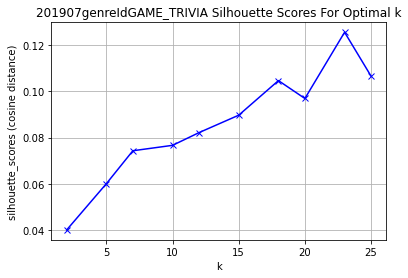

 40%|████      | 4/10 [00:00<00:00, 39.21it/s]

SILHOUETTE SCORE TO FIND OPTIMAL KM CLUSTERS
201907  --  genreId  --  GAME_WORD


100%|██████████| 10/10 [00:00<00:00, 21.10it/s]


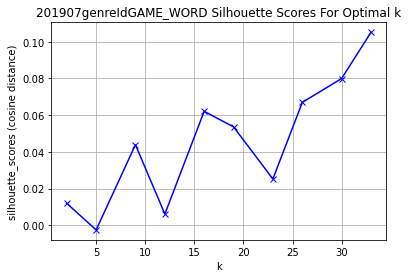

 30%|███       | 3/10 [00:00<00:00, 15.97it/s]

SILHOUETTE SCORE TO FIND OPTIMAL KM CLUSTERS
201907  --  developer  --  top


100%|██████████| 10/10 [00:01<00:00,  5.91it/s]


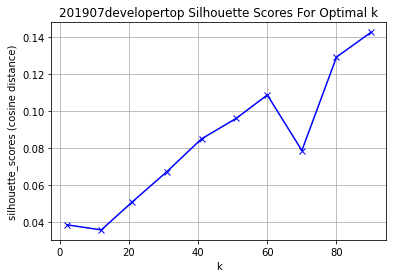

  0%|          | 0/10 [00:00<?, ?it/s]

SILHOUETTE SCORE TO FIND OPTIMAL KM CLUSTERS
201907  --  developer  --  non-top


100%|██████████| 10/10 [22:12<00:00, 133.27s/it]


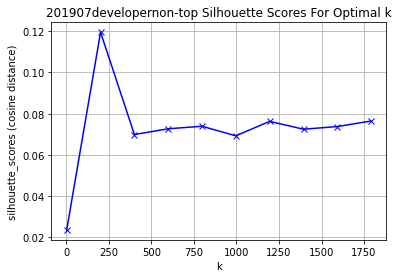

In [6]:
%run -i 'STEP4_NLP_pipeline.py'

# since this code takes too long, I will just run 201907 dataset here
d1 = nlp_pipeline(
          tcn='description',
          initial_panel=test_initial_panel,
          all_panels=test_all_panels
    ).open_divided_df(
    ).generate_save_input_text_col(
    ).tf_idf_transformation(
    ).truncate_svd(
        random_state=0
    ).find_optimal_cluster_elbow(
    ).find_optimal_cluster_silhouette()

## 6.3 Predict Text Labels

In [7]:
%run -i 'STEP4_NLP_pipeline.py'

# since this code takes too long, I will just run 201907 dataset here
d1 = nlp_pipeline(
          tcn='description',
          initial_panel=test_initial_panel,
          all_panels=test_all_panels
    ).open_divided_df(
    ).generate_save_input_text_col(
    ).tf_idf_transformation(
    ).truncate_svd(
        random_state=0
    ).kmeans_cluster(
       init='k-means++',
       random_state=0)

TF-IDF TRANSFORMATION
201907  --  full  --  full
(9405, 2000)
TF-IDF TRANSFORMATION
201907  --  minInstalls  --  ImputedminInstalls_tier1
(1800, 2000)
TF-IDF TRANSFORMATION
201907  --  minInstalls  --  ImputedminInstalls_tier2
(4231, 2000)
TF-IDF TRANSFORMATION
201907  --  minInstalls  --  ImputedminInstalls_tier3
(3374, 2000)
TF-IDF TRANSFORMATION
201907  --  genreId  --  ART_AND_DESIGN
(167, 2000)
TF-IDF TRANSFORMATION
201907  --  genreId  --  COMICS
(83, 2000)
TF-IDF TRANSFORMATION
201907  --  genreId  --  PERSONALIZATION
(274, 2000)
TF-IDF TRANSFORMATION
201907  --  genreId  --  PHOTOGRAPHY
(208, 2000)
TF-IDF TRANSFORMATION
201907  --  genreId  --  AUTO_AND_VEHICLES
(171, 2000)
TF-IDF TRANSFORMATION
201907  --  genreId  --  GAME_ROLE_PLAYING
(262, 2000)
TF-IDF TRANSFORMATION
201907  --  genreId  --  GAME_ACTION
(22, 1736)
TF-IDF TRANSFORMATION
201907  --  genreId  --  GAME_RACING
(188, 2000)
TF-IDF TRANSFORMATION
201907  --  genreId  --  TRAVEL_AND_LOCAL
(214, 2000)
TF-IDF TRANSFOR

# 7. Descriptive Statistics

In [5]:
%run -i 'STEP5_Regression.py'

d1 = regression_analysis(
         initial_panel=test_initial_panel,
         all_panels=test_all_panels,
         tcn = 'description'
    ).open_imputed_deleted_divided_df(
    ).open_predicted_labels_dict(
    ).combine_text_labels_with_df(
    ).check_text_label_contents()

/home/naixin/Insync/naixin88@sina.cn/OneDrive/__CODING__/PycharmProjects/GOOGLE_PLAY/scripts/STEP4_Regression.py:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)
